In [1]:

import os, math
import time
import tensorflow as tf
import numpy as np
from tensorflow.python.framework import ops

from ops import *
from utils import *

In [2]:
print(tf.__version__)

1.4.0


In [3]:
def plot_image(image_array):
    print(image_array.shape)
    if image_array.shape != (28,28):
        image_array = image_array.reshape((28, 28))
    plt.imshow(image_array, cmap='gray')
    plt.show()
    
def get_images_mean(images_array):
        if images_array.shape != (None,28,28,1):
            image_stack = np.concatenate([im[..., None] for im in images_array], axis=1)
        #else:
        median_image = np.median(image_stack, axis=1)
        pixels = np.array(median_image, dtype='uint8')
        return pixels
    

In [4]:
model_name = "WGAN-Quickdraw-multi"  

## Params 

In [5]:
checkpoint_dir = './checkpoints/' # checkpoint_dir
result_dir = './results/' #result_dir
log_dir = './logs/' #log_dir

In [6]:
epoch = 50 #epoch
batch_size = 64# batch_size

# image sizing
input_height = 28
input_width = 28
output_height = 28
output_width = 28

z_dim = 100       # dimension of noise-vector
c_dim = 1

# WGAN parameter
disc_iters = 2     # The number of critic iterations for one-step of generator
    
# train
learning_rate = 0.0002
beta1 = 0.5

# test
sample_num = 64  # number of generated images to be saved

## Load Data

In [7]:
def make_labels(amount, category):
    a = np.empty(amount)
    a.fill(category)
    a = a.astype(int)
    return a

def unison_shuffled_copies(a, b):
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]

In [8]:
num_examples = 40000

In [9]:
# load and make image arrays
bicycles = np.load("../../data/bicycle.npy")[:num_examples]
bicycles = bicycles.reshape(num_examples,28,28,1)
print(bicycles.shape)
print(bicycles[0].shape)

angels = np.load("../../data/angel.npy")[:num_examples]
angels = angels.reshape(num_examples,28,28,1)
print(angels.shape)
print(angels[0].shape)

bananas = np.load("../../data/banana.npy")[:num_examples]
bananas = bananas.reshape(num_examples,28,28,1)
print(bananas.shape)
print(bananas[0].shape)


data_X = np.concatenate((bicycles, angels,bananas), axis=0)
print(data_X.shape)

(40000, 28, 28, 1)
(28, 28, 1)
(40000, 28, 28, 1)
(28, 28, 1)
(40000, 28, 28, 1)
(28, 28, 1)
(120000, 28, 28, 1)


In [10]:
# Make make labels
nb_classes = 3
bicycles_labels = make_labels(num_examples,0)
bicycles_labels = np.eye(nb_classes)[bicycles_labels]
angels_labels = make_labels(num_examples,1)
angels_labels = np.eye(nb_classes)[angels_labels]
bananas_labels = make_labels(num_examples,2)
bananas_labels = np.eye(nb_classes)[bananas_labels]

data_y = np.concatenate((bicycles_labels, angels_labels,bananas_labels), axis=0)
print(bicycles_labels.shape)
print(angels_labels.shape)
print(bananas_labels.shape)
print(data_y.shape)

data_y[0]

(40000, 3)
(40000, 3)
(40000, 3)
(120000, 3)


array([ 1.,  0.,  0.])

In [11]:
data_X, data_y = unison_shuffled_copies(data_X,data_y)

(28, 28, 1)


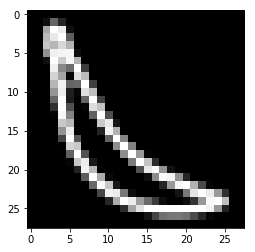

[ 0.  0.  1.]


In [12]:
plot_image(data_X[5])
print(data_y[5])

In [13]:
data_X = data_X/255.

In [14]:
# number of batches for a single epoch
num_batches = len(data_X) // batch_size

dataset_name = 'quickdraw'

model_dir = "{}_{}_{}_{}".format(
            model_name, dataset_name,
            batch_size, z_dim)

In [15]:
#data_y.shape

In [16]:
def discriminator( x, is_training=True, reuse=False):
    # Network Architecture is exactly same as in infoGAN (https://arxiv.org/abs/1606.03657)
    # Architecture : (64)4c2s-(128)4c2s_BL-FC1024_BL-FC1_S
    with tf.variable_scope("discriminator", reuse=reuse):

        net = lrelu(conv2d(x, 64, 4, 4, 2, 2, name='d_conv1'))
        net = lrelu(bn(conv2d(net, 128, 4, 4, 2, 2, name='d_conv2'), is_training=is_training, scope='d_bn2'))
        net = tf.reshape(net, [batch_size, -1])
        net = lrelu(bn(linear(net, 1024, scope='d_fc3'), is_training=is_training, scope='d_bn3'))
        out_logit = linear(net, 1, scope='d_fc4')
        out = tf.nn.sigmoid(out_logit)

        return out, out_logit, net

In [17]:
def generator( z, is_training=True, reuse=False):
    # Network Architecture is exactly same as in infoGAN (https://arxiv.org/abs/1606.03657)
    # Architecture : FC1024_BR-FC7x7x128_BR-(64)4dc2s_BR-(1)4dc2s_S
    with tf.variable_scope("generator", reuse=reuse):
        net = tf.nn.relu(bn(linear(z, 1024, scope='g_fc1'), is_training=is_training, scope='g_bn1'))
        net = tf.nn.relu(bn(linear(net, 128 * 7 * 7, scope='g_fc2'), is_training=is_training, scope='g_bn2'))
        net = tf.reshape(net, [batch_size, 7, 7, 128])
        net = tf.nn.relu(
            bn(deconv2d(net, [batch_size, 14, 14, 64], 4, 4, 2, 2, name='g_dc3'), is_training=is_training,
               scope='g_bn3'))

        out = tf.nn.sigmoid(deconv2d(net, [batch_size, 28, 28, 1], 4, 4, 2, 2, name='g_dc4'))

        return out

## Build the model

In [ ]:
# some parameters
image_dims = [input_height, input_width, c_dim]
bs = batch_size

""" Graph Input """
# images
inputs = tf.placeholder(tf.float32, [bs] + image_dims, name='real_images')

# noises
z = tf.placeholder(tf.float32, [bs, z_dim], name='z')

## Loss Function

In [ ]:
# output of D for real images
D_real, D_real_logits, _ = discriminator(inputs, is_training=True, reuse=False)

# output of D for fake images
G = generator(z, is_training=True, reuse=False)
D_fake, D_fake_logits, _ = discriminator(G, is_training=True, reuse=True)

# get loss for discriminator
d_loss_real = - tf.reduce_mean(D_real_logits)
d_loss_fake = tf.reduce_mean(D_fake_logits)

d_loss = d_loss_real + d_loss_fake

# get loss for generator
g_loss = - d_loss_fake

In [ ]:
# divide trainable variables into a group for D and a group for G
t_vars = tf.trainable_variables()
d_vars = [var for var in t_vars if 'd_' in var.name]
g_vars = [var for var in t_vars if 'g_' in var.name]

## Optimizers

In [ ]:
# optimizers
with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
    d_optim = tf.train.AdamOptimizer(learning_rate, beta1=beta1) \
              .minimize(d_loss, var_list=d_vars)
    g_optim = tf.train.AdamOptimizer(learning_rate*5, beta1=beta1) \
              .minimize(g_loss, var_list=g_vars)

## Weight clipping

In [ ]:
# weight clipping this is key to Wassstein GAN
clip_D = [p.assign(tf.clip_by_value(p, -0.01, 0.01)) for p in d_vars]

In [ ]:
# for test
fake_images = generator(z, is_training=False, reuse=True)

### For Tensorboard

In [ ]:
""" Summary """
d_loss_real_sum = tf.summary.scalar("d_loss_real", d_loss_real)
d_loss_fake_sum = tf.summary.scalar("d_loss_fake", d_loss_fake)
d_loss_sum = tf.summary.scalar("d_loss", d_loss)
g_loss_sum = tf.summary.scalar("g_loss", g_loss)

# final summary operations
g_sum = tf.summary.merge([d_loss_fake_sum, g_loss_sum])
d_sum = tf.summary.merge([d_loss_real_sum, d_loss_sum])

In [19]:
def visualize_results( epoch):
    tot_num_samples = min(sample_num, batch_size)
    image_frame_dim = int(np.floor(np.sqrt(tot_num_samples)))

    """ random condition, random noise """

    z_sample = np.random.uniform(-1, 1, size=(batch_size, z_dim))

    samples = sess.run(fake_images, feed_dict={z: z_sample})

    save_images(samples[:image_frame_dim * image_frame_dim, :, :, :], [image_frame_dim, image_frame_dim],
                check_folder(result_dir + '/' + model_dir) + '/' + model_name + '_epoch%03d' % epoch + '_test_all_classes.png')

In [20]:
def load( checkpoint_dir):
    import re
    print(" [*] Reading checkpoints...")
    checkpoint_dir = os.path.join(checkpoint_dir, model_dir, model_name)

    ckpt = tf.train.get_checkpoint_state(checkpoint_dir)
    if ckpt and ckpt.model_checkpoint_path:
        ckpt_name = os.path.basename(ckpt.model_checkpoint_path)
        saver.restore(sess, os.path.join(checkpoint_dir, ckpt_name))
        counter = int(next(re.finditer("(\d+)(?!.*\d)",ckpt_name)).group(0))
        print(" [*] Successfully read {}".format(ckpt_name))
        return True, counter
    else:
        print(" [*] Failed to find a checkpoint")
        return False, 0

In [21]:
def save(checkpoint_dir, step):
    checkpoint_dir = os.path.join(checkpoint_dir, model_dir, model_name)

    if not os.path.exists(checkpoint_dir):
        os.makedirs(checkpoint_dir)

    saver.save(sess,os.path.join(checkpoint_dir, model_name+'.model'), global_step=step)

In [24]:

with tf.Session(config=tf.ConfigProto(allow_soft_placement=False)) as sess:
    # initialize all variables
    tf.global_variables_initializer().run()

    # graph inputs for visualize training results
    sample_z = np.random.uniform(-1, 1, size=(batch_size , z_dim))

    # saver to save model
    saver = tf.train.Saver()

    # summary writer
    writer = tf.summary.FileWriter(log_dir + '/' + model_name, sess.graph)

    # restore check-point if it exits
    could_load, checkpoint_counter = load(checkpoint_dir)
    if could_load:
        start_epoch = (int)(checkpoint_counter / num_batches)
        start_batch_id = checkpoint_counter - start_epoch * num_batches
        counter = checkpoint_counter
        print(" [*] Load SUCCESS")
    else:
        start_epoch = 0
        start_batch_id = 0
        counter = 1
        print(" [!] Load failed...")

    # loop for epoch
    start_time = time.time()
    print(start_time)
    for temp_epoch in range(start_epoch, epoch):

        # get batch data
        for idx in range(start_batch_id, num_batches):
            batch_images = data_X[idx*batch_size:(idx+1)*batch_size]
            batch_z = np.random.uniform(-1, 1, [batch_size, z_dim]).astype(np.float32)
            
            # update D network
            _, _, summary_str, dd_loss = sess.run([d_optim, clip_D, d_sum, d_loss], feed_dict={inputs: batch_images, z: batch_z})
            writer.add_summary(summary_str, counter)

            # update G network
            if (counter - 1) % disc_iters == 0:
                _, summary_str, gg_loss = sess.run([g_optim, g_sum, g_loss], feed_dict={z: batch_z})
                writer.add_summary(summary_str, counter)

            # display training status
            counter += 1
            print("Epoch: [%2d] [%4d/%4d] time: %4.4f, d_loss: %.8f, g_loss: %.8f" \
                  % (temp_epoch, idx, num_batches, time.time() - start_time, dd_loss, gg_loss))

            # save training results for every 300 steps
            if np.mod(counter, 300) == 0:
                samples = sess.run(fake_images, feed_dict={z: sample_z})
                tot_num_samples = min(sample_num, batch_size)
                manifold_h = int(np.floor(np.sqrt(tot_num_samples)))
                manifold_w = int(np.floor(np.sqrt(tot_num_samples)))
                save_images(samples[:manifold_h * manifold_w, :, :, :], [manifold_h, manifold_w],
                            './' + check_folder(result_dir + '/' + model_dir) + '/' + model_name + '_train_{:02d}_{:04d}.png'.format(
                                temp_epoch, idx))

        # After an epoch, start_batch_id is set to zero
        # non-zero value is only for the first epoch after loading pre-trained model
        start_batch_id = 0

        # save model
        save(checkpoint_dir, counter)

        # show temporal results
        visualize_results(temp_epoch)

    # save model for final step
    save(checkpoint_dir, counter)

 [*] Reading checkpoints...
 [*] Failed to find a checkpoint
 [!] Load failed...
1510540828.7133482
Epoch: [ 0] [   0/1875] time: 0.4563, d_loss: -0.00053800, g_loss: -0.00009866
Epoch: [ 0] [   1/1875] time: 0.6091, d_loss: -0.00134738, g_loss: -0.00009866
Epoch: [ 0] [   2/1875] time: 0.9125, d_loss: -0.00247186, g_loss: -0.00020315
Epoch: [ 0] [   3/1875] time: 1.0679, d_loss: -0.00373468, g_loss: -0.00020315
Epoch: [ 0] [   4/1875] time: 1.3735, d_loss: -0.00518192, g_loss: -0.00009977
Epoch: [ 0] [   5/1875] time: 1.5302, d_loss: -0.00599049, g_loss: -0.00009977
Epoch: [ 0] [   6/1875] time: 1.8410, d_loss: -0.00700400, g_loss: -0.00049849
Epoch: [ 0] [   7/1875] time: 1.9944, d_loss: -0.00533824, g_loss: -0.00049849
Epoch: [ 0] [   8/1875] time: 2.2926, d_loss: -0.00654784, g_loss: -0.00113620
Epoch: [ 0] [   9/1875] time: 2.4495, d_loss: -0.00325450, g_loss: -0.00113620
Epoch: [ 0] [  10/1875] time: 2.7477, d_loss: -0.00527792, g_loss: -0.00064462
Epoch: [ 0] [  11/1875] time: 2

Epoch: [ 0] [ 104/1875] time: 25.4873, d_loss: -0.01794185, g_loss: 0.00736749
Epoch: [ 0] [ 105/1875] time: 25.6842, d_loss: -0.01799002, g_loss: 0.00736749
Epoch: [ 0] [ 106/1875] time: 26.0603, d_loss: -0.01783945, g_loss: 0.00710546
Epoch: [ 0] [ 107/1875] time: 26.2439, d_loss: -0.01806523, g_loss: 0.00710546
Epoch: [ 0] [ 108/1875] time: 26.5598, d_loss: -0.01841418, g_loss: 0.00709530
Epoch: [ 0] [ 109/1875] time: 26.7316, d_loss: -0.01778481, g_loss: 0.00709530
Epoch: [ 0] [ 110/1875] time: 27.0535, d_loss: -0.01754461, g_loss: 0.00620230
Epoch: [ 0] [ 111/1875] time: 27.2188, d_loss: -0.01677074, g_loss: 0.00620230
Epoch: [ 0] [ 112/1875] time: 27.5353, d_loss: -0.01783827, g_loss: 0.00692895
Epoch: [ 0] [ 113/1875] time: 27.7067, d_loss: -0.01773700, g_loss: 0.00692895
Epoch: [ 0] [ 114/1875] time: 28.0327, d_loss: -0.01764777, g_loss: 0.00755513
Epoch: [ 0] [ 115/1875] time: 28.1969, d_loss: -0.01788868, g_loss: 0.00755513
Epoch: [ 0] [ 116/1875] time: 28.4962, d_loss: -0.01

Epoch: [ 0] [ 208/1875] time: 50.3533, d_loss: -0.01961350, g_loss: 0.00762484
Epoch: [ 0] [ 209/1875] time: 50.5244, d_loss: -0.01997892, g_loss: 0.00762484
Epoch: [ 0] [ 210/1875] time: 50.8484, d_loss: -0.01961941, g_loss: 0.00752179
Epoch: [ 0] [ 211/1875] time: 51.0181, d_loss: -0.02008945, g_loss: 0.00752179
Epoch: [ 0] [ 212/1875] time: 51.3386, d_loss: -0.01975347, g_loss: 0.00756135
Epoch: [ 0] [ 213/1875] time: 51.4913, d_loss: -0.02002199, g_loss: 0.00756135
Epoch: [ 0] [ 214/1875] time: 51.7909, d_loss: -0.01939401, g_loss: 0.00759304
Epoch: [ 0] [ 215/1875] time: 51.9476, d_loss: -0.01990010, g_loss: 0.00759304
Epoch: [ 0] [ 216/1875] time: 52.2510, d_loss: -0.01936371, g_loss: 0.00751996
Epoch: [ 0] [ 217/1875] time: 52.4084, d_loss: -0.01985444, g_loss: 0.00751996
Epoch: [ 0] [ 218/1875] time: 52.7029, d_loss: -0.01965563, g_loss: 0.00751755
Epoch: [ 0] [ 219/1875] time: 52.8610, d_loss: -0.02049818, g_loss: 0.00751755
Epoch: [ 0] [ 220/1875] time: 53.1535, d_loss: -0.02

Epoch: [ 0] [ 312/1875] time: 74.4759, d_loss: -0.01646884, g_loss: 0.00473171
Epoch: [ 0] [ 313/1875] time: 74.6356, d_loss: -0.01031389, g_loss: 0.00473171
Epoch: [ 0] [ 314/1875] time: 74.9381, d_loss: -0.00694509, g_loss: 0.00576027
Epoch: [ 0] [ 315/1875] time: 75.0944, d_loss: -0.01542712, g_loss: 0.00576027
Epoch: [ 0] [ 316/1875] time: 75.3841, d_loss: -0.01367160, g_loss: 0.00888849
Epoch: [ 0] [ 317/1875] time: 75.5541, d_loss: -0.01898111, g_loss: 0.00888849
Epoch: [ 0] [ 318/1875] time: 75.8813, d_loss: -0.01954479, g_loss: 0.00732873
Epoch: [ 0] [ 319/1875] time: 76.0564, d_loss: -0.01429184, g_loss: 0.00732873
Epoch: [ 0] [ 320/1875] time: 76.3898, d_loss: -0.01134492, g_loss: 0.00762568
Epoch: [ 0] [ 321/1875] time: 76.5572, d_loss: -0.01682829, g_loss: 0.00762568
Epoch: [ 0] [ 322/1875] time: 76.8619, d_loss: -0.01854247, g_loss: 0.00820163
Epoch: [ 0] [ 323/1875] time: 77.0183, d_loss: -0.01809198, g_loss: 0.00820163
Epoch: [ 0] [ 324/1875] time: 77.3219, d_loss: -0.01

Epoch: [ 0] [ 416/1875] time: 98.5913, d_loss: -0.01491385, g_loss: 0.00628226
Epoch: [ 0] [ 417/1875] time: 98.7488, d_loss: -0.01607505, g_loss: 0.00628226
Epoch: [ 0] [ 418/1875] time: 99.0555, d_loss: -0.01571824, g_loss: 0.00603916
Epoch: [ 0] [ 419/1875] time: 99.2241, d_loss: -0.01149104, g_loss: 0.00603916
Epoch: [ 0] [ 420/1875] time: 99.5458, d_loss: -0.01454181, g_loss: 0.00644575
Epoch: [ 0] [ 421/1875] time: 99.7192, d_loss: -0.01643291, g_loss: 0.00644575
Epoch: [ 0] [ 422/1875] time: 100.0569, d_loss: -0.01735352, g_loss: 0.00437738
Epoch: [ 0] [ 423/1875] time: 100.2155, d_loss: -0.01405801, g_loss: 0.00437738
Epoch: [ 0] [ 424/1875] time: 100.5152, d_loss: -0.01721443, g_loss: 0.00646173
Epoch: [ 0] [ 425/1875] time: 100.6667, d_loss: -0.01542990, g_loss: 0.00646173
Epoch: [ 0] [ 426/1875] time: 100.9691, d_loss: -0.01628606, g_loss: 0.00674733
Epoch: [ 0] [ 427/1875] time: 101.1239, d_loss: -0.01565546, g_loss: 0.00674733
Epoch: [ 0] [ 428/1875] time: 101.4223, d_loss

Epoch: [ 0] [ 520/1875] time: 122.9426, d_loss: -0.01474895, g_loss: 0.00653224
Epoch: [ 0] [ 521/1875] time: 123.1137, d_loss: -0.01681644, g_loss: 0.00653224
Epoch: [ 0] [ 522/1875] time: 123.4084, d_loss: -0.01759661, g_loss: 0.00722774
Epoch: [ 0] [ 523/1875] time: 123.5599, d_loss: -0.01493249, g_loss: 0.00722774
Epoch: [ 0] [ 524/1875] time: 123.8606, d_loss: -0.01705442, g_loss: 0.00767931
Epoch: [ 0] [ 525/1875] time: 124.0167, d_loss: -0.01759349, g_loss: 0.00767931
Epoch: [ 0] [ 526/1875] time: 124.3215, d_loss: -0.01330211, g_loss: 0.00579220
Epoch: [ 0] [ 527/1875] time: 124.4921, d_loss: -0.01285905, g_loss: 0.00579220
Epoch: [ 0] [ 528/1875] time: 124.8418, d_loss: -0.01217925, g_loss: 0.00554701
Epoch: [ 0] [ 529/1875] time: 125.0191, d_loss: -0.01425130, g_loss: 0.00554701
Epoch: [ 0] [ 530/1875] time: 125.3448, d_loss: -0.00989329, g_loss: 0.00012942
Epoch: [ 0] [ 531/1875] time: 125.5165, d_loss: -0.01134331, g_loss: 0.00012942
Epoch: [ 0] [ 532/1875] time: 125.8265, 

Epoch: [ 0] [ 624/1875] time: 147.2529, d_loss: -0.01555204, g_loss: 0.00679066
Epoch: [ 0] [ 625/1875] time: 147.4088, d_loss: -0.01655281, g_loss: 0.00679066
Epoch: [ 0] [ 626/1875] time: 147.7122, d_loss: -0.01448620, g_loss: 0.00173861
Epoch: [ 0] [ 627/1875] time: 147.8665, d_loss: -0.01063442, g_loss: 0.00173861
Epoch: [ 0] [ 628/1875] time: 148.1698, d_loss: -0.01348227, g_loss: 0.00634931
Epoch: [ 0] [ 629/1875] time: 148.3255, d_loss: -0.01158747, g_loss: 0.00634931
Epoch: [ 0] [ 630/1875] time: 148.6211, d_loss: -0.01040268, g_loss: 0.00578807
Epoch: [ 0] [ 631/1875] time: 148.7790, d_loss: -0.01397699, g_loss: 0.00578807
Epoch: [ 0] [ 632/1875] time: 149.0815, d_loss: -0.01237355, g_loss: 0.00381754
Epoch: [ 0] [ 633/1875] time: 149.2433, d_loss: -0.01248696, g_loss: 0.00381754
Epoch: [ 0] [ 634/1875] time: 149.5454, d_loss: -0.01370890, g_loss: 0.00675005
Epoch: [ 0] [ 635/1875] time: 149.6999, d_loss: -0.01265470, g_loss: 0.00675005
Epoch: [ 0] [ 636/1875] time: 149.9916, 

Epoch: [ 0] [ 728/1875] time: 171.4283, d_loss: -0.01504489, g_loss: 0.00644062
Epoch: [ 0] [ 729/1875] time: 171.5830, d_loss: -0.01593925, g_loss: 0.00644062
Epoch: [ 0] [ 730/1875] time: 171.8846, d_loss: -0.01511857, g_loss: 0.00222630
Epoch: [ 0] [ 731/1875] time: 172.0475, d_loss: -0.01385187, g_loss: 0.00222630
Epoch: [ 0] [ 732/1875] time: 172.3524, d_loss: -0.01520812, g_loss: 0.00436285
Epoch: [ 0] [ 733/1875] time: 172.5033, d_loss: -0.01486591, g_loss: 0.00436285
Epoch: [ 0] [ 734/1875] time: 172.8039, d_loss: -0.01351611, g_loss: 0.00625180
Epoch: [ 0] [ 735/1875] time: 172.9559, d_loss: -0.01477488, g_loss: 0.00625180
Epoch: [ 0] [ 736/1875] time: 173.2519, d_loss: -0.01505663, g_loss: 0.00613276
Epoch: [ 0] [ 737/1875] time: 173.4088, d_loss: -0.01493241, g_loss: 0.00613276
Epoch: [ 0] [ 738/1875] time: 173.7243, d_loss: -0.01388214, g_loss: 0.00076701
Epoch: [ 0] [ 739/1875] time: 173.8962, d_loss: -0.00976969, g_loss: 0.00076701
Epoch: [ 0] [ 740/1875] time: 174.2178, 

Epoch: [ 0] [ 832/1875] time: 195.6071, d_loss: -0.01499289, g_loss: 0.00526949
Epoch: [ 0] [ 833/1875] time: 195.7603, d_loss: -0.01417681, g_loss: 0.00526949
Epoch: [ 0] [ 834/1875] time: 196.0604, d_loss: -0.01398478, g_loss: 0.00539784
Epoch: [ 0] [ 835/1875] time: 196.2159, d_loss: -0.01292014, g_loss: 0.00539784
Epoch: [ 0] [ 836/1875] time: 196.5212, d_loss: -0.01404745, g_loss: 0.00115121
Epoch: [ 0] [ 837/1875] time: 196.6745, d_loss: -0.01180018, g_loss: 0.00115121
Epoch: [ 0] [ 838/1875] time: 196.9670, d_loss: -0.01445981, g_loss: 0.00507657
Epoch: [ 0] [ 839/1875] time: 197.1194, d_loss: -0.01271500, g_loss: 0.00507657
Epoch: [ 0] [ 840/1875] time: 197.4186, d_loss: -0.01507585, g_loss: 0.00638012
Epoch: [ 0] [ 841/1875] time: 197.5736, d_loss: -0.01624851, g_loss: 0.00638012
Epoch: [ 0] [ 842/1875] time: 197.8705, d_loss: -0.01584541, g_loss: 0.00415660
Epoch: [ 0] [ 843/1875] time: 198.0248, d_loss: -0.01471678, g_loss: 0.00415660
Epoch: [ 0] [ 844/1875] time: 198.3206, 

Epoch: [ 0] [ 936/1875] time: 219.7473, d_loss: -0.01199703, g_loss: 0.00236976
Epoch: [ 0] [ 937/1875] time: 219.9101, d_loss: -0.01289131, g_loss: 0.00236976
Epoch: [ 0] [ 938/1875] time: 220.2086, d_loss: -0.01567656, g_loss: 0.00582321
Epoch: [ 0] [ 939/1875] time: 220.3630, d_loss: -0.01460208, g_loss: 0.00582321
Epoch: [ 0] [ 940/1875] time: 220.6673, d_loss: -0.01439999, g_loss: 0.00705487
Epoch: [ 0] [ 941/1875] time: 220.8340, d_loss: -0.01521014, g_loss: 0.00705487
Epoch: [ 0] [ 942/1875] time: 221.1285, d_loss: -0.01607373, g_loss: 0.00399414
Epoch: [ 0] [ 943/1875] time: 221.2843, d_loss: -0.01442860, g_loss: 0.00399414
Epoch: [ 0] [ 944/1875] time: 221.5789, d_loss: -0.01626273, g_loss: 0.00411805
Epoch: [ 0] [ 945/1875] time: 221.7370, d_loss: -0.01373932, g_loss: 0.00411805
Epoch: [ 0] [ 946/1875] time: 222.0349, d_loss: -0.01456005, g_loss: 0.00309172
Epoch: [ 0] [ 947/1875] time: 222.1910, d_loss: -0.01296194, g_loss: 0.00309172
Epoch: [ 0] [ 948/1875] time: 222.4927, 

Epoch: [ 0] [1040/1875] time: 244.0138, d_loss: -0.01500932, g_loss: 0.00318873
Epoch: [ 0] [1041/1875] time: 244.1789, d_loss: -0.01345964, g_loss: 0.00318873
Epoch: [ 0] [1042/1875] time: 244.5010, d_loss: -0.01395270, g_loss: 0.00640613
Epoch: [ 0] [1043/1875] time: 244.6695, d_loss: -0.01370459, g_loss: 0.00640613
Epoch: [ 0] [1044/1875] time: 244.9872, d_loss: -0.01540718, g_loss: 0.00730233
Epoch: [ 0] [1045/1875] time: 245.1542, d_loss: -0.01430670, g_loss: 0.00730233
Epoch: [ 0] [1046/1875] time: 245.4750, d_loss: -0.01502397, g_loss: 0.00680777
Epoch: [ 0] [1047/1875] time: 245.6365, d_loss: -0.01635411, g_loss: 0.00680777
Epoch: [ 0] [1048/1875] time: 245.9498, d_loss: -0.01517967, g_loss: 0.00649561
Epoch: [ 0] [1049/1875] time: 246.1068, d_loss: -0.01460407, g_loss: 0.00649561
Epoch: [ 0] [1050/1875] time: 246.4141, d_loss: -0.01471474, g_loss: 0.00631312
Epoch: [ 0] [1051/1875] time: 246.5771, d_loss: -0.01480688, g_loss: 0.00631312
Epoch: [ 0] [1052/1875] time: 246.9039, 

Epoch: [ 0] [1144/1875] time: 268.8834, d_loss: -0.01468940, g_loss: 0.00122061
Epoch: [ 0] [1145/1875] time: 269.0373, d_loss: -0.01143603, g_loss: 0.00122061
Epoch: [ 0] [1146/1875] time: 269.3358, d_loss: -0.01295678, g_loss: 0.00706594
Epoch: [ 0] [1147/1875] time: 269.4921, d_loss: -0.01432294, g_loss: 0.00706594
Epoch: [ 0] [1148/1875] time: 269.7865, d_loss: -0.01221472, g_loss: 0.00479549
Epoch: [ 0] [1149/1875] time: 269.9471, d_loss: -0.01377144, g_loss: 0.00479549
Epoch: [ 0] [1150/1875] time: 270.2793, d_loss: -0.01306534, g_loss: -0.00260401
Epoch: [ 0] [1151/1875] time: 270.4489, d_loss: -0.01109620, g_loss: -0.00260401
Epoch: [ 0] [1152/1875] time: 270.7768, d_loss: -0.01373610, g_loss: 0.00621547
Epoch: [ 0] [1153/1875] time: 270.9490, d_loss: -0.01456366, g_loss: 0.00621547
Epoch: [ 0] [1154/1875] time: 271.2687, d_loss: -0.01423366, g_loss: 0.00606336
Epoch: [ 0] [1155/1875] time: 271.4390, d_loss: -0.01437775, g_loss: 0.00606336
Epoch: [ 0] [1156/1875] time: 271.7672

Epoch: [ 0] [1248/1875] time: 293.2850, d_loss: -0.01559278, g_loss: 0.00553049
Epoch: [ 0] [1249/1875] time: 293.4414, d_loss: -0.01450483, g_loss: 0.00553049
Epoch: [ 0] [1250/1875] time: 293.7391, d_loss: -0.01441524, g_loss: 0.00714991
Epoch: [ 0] [1251/1875] time: 293.9115, d_loss: -0.01307698, g_loss: 0.00714991
Epoch: [ 0] [1252/1875] time: 294.2345, d_loss: -0.01187946, g_loss: 0.00530415
Epoch: [ 0] [1253/1875] time: 294.4027, d_loss: -0.01445890, g_loss: 0.00530415
Epoch: [ 0] [1254/1875] time: 294.7246, d_loss: -0.01429965, g_loss: 0.00295059
Epoch: [ 0] [1255/1875] time: 294.8963, d_loss: -0.01311575, g_loss: 0.00295059
Epoch: [ 0] [1256/1875] time: 295.2048, d_loss: -0.01446240, g_loss: 0.00654291
Epoch: [ 0] [1257/1875] time: 295.3624, d_loss: -0.01686919, g_loss: 0.00654291
Epoch: [ 0] [1258/1875] time: 295.6551, d_loss: -0.01601751, g_loss: 0.00500895
Epoch: [ 0] [1259/1875] time: 295.8208, d_loss: -0.01408566, g_loss: 0.00500895
Epoch: [ 0] [1260/1875] time: 296.1174, 

Epoch: [ 0] [1352/1875] time: 317.3637, d_loss: -0.01485705, g_loss: 0.00327010
Epoch: [ 0] [1353/1875] time: 317.5172, d_loss: -0.01460079, g_loss: 0.00327010
Epoch: [ 0] [1354/1875] time: 317.8134, d_loss: -0.01551107, g_loss: 0.00701053
Epoch: [ 0] [1355/1875] time: 317.9702, d_loss: -0.01516420, g_loss: 0.00701053
Epoch: [ 0] [1356/1875] time: 318.2681, d_loss: -0.01068366, g_loss: 0.00482659
Epoch: [ 0] [1357/1875] time: 318.4228, d_loss: -0.01478212, g_loss: 0.00482659
Epoch: [ 0] [1358/1875] time: 318.7233, d_loss: -0.01542647, g_loss: 0.00517756
Epoch: [ 0] [1359/1875] time: 318.8767, d_loss: -0.01565585, g_loss: 0.00517756
Epoch: [ 0] [1360/1875] time: 319.1753, d_loss: -0.01464792, g_loss: 0.00711703
Epoch: [ 0] [1361/1875] time: 319.3469, d_loss: -0.01438917, g_loss: 0.00711703
Epoch: [ 0] [1362/1875] time: 319.6683, d_loss: -0.01526179, g_loss: 0.00246917
Epoch: [ 0] [1363/1875] time: 319.8435, d_loss: -0.01285068, g_loss: 0.00246917
Epoch: [ 0] [1364/1875] time: 320.1753, 

Epoch: [ 0] [1456/1875] time: 341.4805, d_loss: -0.01703915, g_loss: 0.00709768
Epoch: [ 0] [1457/1875] time: 341.6417, d_loss: -0.01484160, g_loss: 0.00709768
Epoch: [ 0] [1458/1875] time: 341.9351, d_loss: -0.01465735, g_loss: 0.00513785
Epoch: [ 0] [1459/1875] time: 342.0836, d_loss: -0.01242729, g_loss: 0.00513785
Epoch: [ 0] [1460/1875] time: 342.3810, d_loss: -0.01316898, g_loss: 0.00649344
Epoch: [ 0] [1461/1875] time: 342.5333, d_loss: -0.01367597, g_loss: 0.00649344
Epoch: [ 0] [1462/1875] time: 342.8296, d_loss: -0.01389076, g_loss: 0.00674303
Epoch: [ 0] [1463/1875] time: 342.9852, d_loss: -0.01435638, g_loss: 0.00674303
Epoch: [ 0] [1464/1875] time: 343.2800, d_loss: -0.01477635, g_loss: 0.00627264
Epoch: [ 0] [1465/1875] time: 343.4349, d_loss: -0.01460666, g_loss: 0.00627264
Epoch: [ 0] [1466/1875] time: 343.7381, d_loss: -0.01578889, g_loss: 0.00639459
Epoch: [ 0] [1467/1875] time: 343.8922, d_loss: -0.01661941, g_loss: 0.00639459
Epoch: [ 0] [1468/1875] time: 344.2162, 

Epoch: [ 0] [1560/1875] time: 365.6679, d_loss: -0.01393635, g_loss: 0.00620526
Epoch: [ 0] [1561/1875] time: 365.8283, d_loss: -0.01518756, g_loss: 0.00620526
Epoch: [ 0] [1562/1875] time: 366.1335, d_loss: -0.01549779, g_loss: 0.00555317
Epoch: [ 0] [1563/1875] time: 366.3073, d_loss: -0.01532047, g_loss: 0.00555317
Epoch: [ 0] [1564/1875] time: 366.6287, d_loss: -0.01563663, g_loss: 0.00702280
Epoch: [ 0] [1565/1875] time: 366.7999, d_loss: -0.01544755, g_loss: 0.00702280
Epoch: [ 0] [1566/1875] time: 367.1289, d_loss: -0.01531033, g_loss: 0.00399992
Epoch: [ 0] [1567/1875] time: 367.2874, d_loss: -0.01248299, g_loss: 0.00399992
Epoch: [ 0] [1568/1875] time: 367.5806, d_loss: -0.01475484, g_loss: 0.00670069
Epoch: [ 0] [1569/1875] time: 367.7350, d_loss: -0.01398319, g_loss: 0.00670069
Epoch: [ 0] [1570/1875] time: 368.0326, d_loss: -0.01545443, g_loss: 0.00384473
Epoch: [ 0] [1571/1875] time: 368.1853, d_loss: -0.01472856, g_loss: 0.00384473
Epoch: [ 0] [1572/1875] time: 368.4804, 

Epoch: [ 0] [1664/1875] time: 389.9321, d_loss: -0.01370259, g_loss: 0.00503594
Epoch: [ 0] [1665/1875] time: 390.1051, d_loss: -0.01547307, g_loss: 0.00503594
Epoch: [ 0] [1666/1875] time: 390.4296, d_loss: -0.01411055, g_loss: 0.00236131
Epoch: [ 0] [1667/1875] time: 390.6163, d_loss: -0.01303265, g_loss: 0.00236131
Epoch: [ 0] [1668/1875] time: 390.9715, d_loss: -0.01392101, g_loss: 0.00672097
Epoch: [ 0] [1669/1875] time: 391.1575, d_loss: -0.01226958, g_loss: 0.00672097
Epoch: [ 0] [1670/1875] time: 391.4584, d_loss: -0.01616208, g_loss: 0.00580284
Epoch: [ 0] [1671/1875] time: 391.6123, d_loss: -0.01529369, g_loss: 0.00580284
Epoch: [ 0] [1672/1875] time: 391.9131, d_loss: -0.01448642, g_loss: 0.00624446
Epoch: [ 0] [1673/1875] time: 392.0653, d_loss: -0.01525038, g_loss: 0.00624446
Epoch: [ 0] [1674/1875] time: 392.3699, d_loss: -0.01508062, g_loss: 0.00705431
Epoch: [ 0] [1675/1875] time: 392.5233, d_loss: -0.01615090, g_loss: 0.00705431
Epoch: [ 0] [1676/1875] time: 392.8317, 

Epoch: [ 0] [1768/1875] time: 414.3273, d_loss: -0.01630712, g_loss: 0.00554719
Epoch: [ 0] [1769/1875] time: 414.4925, d_loss: -0.01583236, g_loss: 0.00554719
Epoch: [ 0] [1770/1875] time: 414.8078, d_loss: -0.01624578, g_loss: 0.00766360
Epoch: [ 0] [1771/1875] time: 414.9626, d_loss: -0.01669358, g_loss: 0.00766360
Epoch: [ 0] [1772/1875] time: 415.2564, d_loss: -0.01478137, g_loss: 0.00727806
Epoch: [ 0] [1773/1875] time: 415.4115, d_loss: -0.01563819, g_loss: 0.00727806
Epoch: [ 0] [1774/1875] time: 415.7051, d_loss: -0.01452936, g_loss: 0.00684261
Epoch: [ 0] [1775/1875] time: 415.8651, d_loss: -0.01436193, g_loss: 0.00684261
Epoch: [ 0] [1776/1875] time: 416.1680, d_loss: -0.01358440, g_loss: 0.00631320
Epoch: [ 0] [1777/1875] time: 416.3260, d_loss: -0.01485852, g_loss: 0.00631320
Epoch: [ 0] [1778/1875] time: 416.6190, d_loss: -0.01571800, g_loss: 0.00482797
Epoch: [ 0] [1779/1875] time: 416.7720, d_loss: -0.01435077, g_loss: 0.00482797
Epoch: [ 0] [1780/1875] time: 417.0654, 

Epoch: [ 0] [1872/1875] time: 438.3531, d_loss: -0.01432097, g_loss: 0.00650190
Epoch: [ 0] [1873/1875] time: 438.5091, d_loss: -0.01438019, g_loss: 0.00650190
Epoch: [ 0] [1874/1875] time: 438.8312, d_loss: -0.01440606, g_loss: 0.00603219
Epoch: [ 1] [   0/1875] time: 439.2631, d_loss: -0.01278418, g_loss: 0.00603219
Epoch: [ 1] [   1/1875] time: 439.5852, d_loss: -0.01596057, g_loss: 0.00664650
Epoch: [ 1] [   2/1875] time: 439.7555, d_loss: -0.01424640, g_loss: 0.00664650
Epoch: [ 1] [   3/1875] time: 440.0817, d_loss: -0.01514070, g_loss: 0.00373147
Epoch: [ 1] [   4/1875] time: 440.2495, d_loss: -0.01296991, g_loss: 0.00373147
Epoch: [ 1] [   5/1875] time: 440.5744, d_loss: -0.01499988, g_loss: 0.00736486
Epoch: [ 1] [   6/1875] time: 440.7472, d_loss: -0.01458925, g_loss: 0.00736486
Epoch: [ 1] [   7/1875] time: 441.0675, d_loss: -0.01238623, g_loss: 0.00525485
Epoch: [ 1] [   8/1875] time: 441.2297, d_loss: -0.01513198, g_loss: 0.00525485
Epoch: [ 1] [   9/1875] time: 441.5544, 

Epoch: [ 1] [ 101/1875] time: 463.8847, d_loss: -0.01456363, g_loss: 0.00583964
Epoch: [ 1] [ 102/1875] time: 464.0392, d_loss: -0.01516961, g_loss: 0.00583964
Epoch: [ 1] [ 103/1875] time: 464.3321, d_loss: -0.01579084, g_loss: 0.00691155
Epoch: [ 1] [ 104/1875] time: 464.4852, d_loss: -0.01459695, g_loss: 0.00691155
Epoch: [ 1] [ 105/1875] time: 464.7800, d_loss: -0.01460866, g_loss: 0.00710678
Epoch: [ 1] [ 106/1875] time: 464.9320, d_loss: -0.01664340, g_loss: 0.00710678
Epoch: [ 1] [ 107/1875] time: 465.2342, d_loss: -0.01637224, g_loss: 0.00588829
Epoch: [ 1] [ 108/1875] time: 465.4223, d_loss: -0.01441077, g_loss: 0.00588829
Epoch: [ 1] [ 109/1875] time: 465.7402, d_loss: -0.01499313, g_loss: 0.00521802
Epoch: [ 1] [ 110/1875] time: 465.9024, d_loss: -0.01386555, g_loss: 0.00521802
Epoch: [ 1] [ 111/1875] time: 466.2294, d_loss: -0.01512516, g_loss: 0.00670514
Epoch: [ 1] [ 112/1875] time: 466.3828, d_loss: -0.01450353, g_loss: 0.00670514
Epoch: [ 1] [ 113/1875] time: 466.6777, 

Epoch: [ 1] [ 205/1875] time: 488.9434, d_loss: -0.01498867, g_loss: 0.00638512
Epoch: [ 1] [ 206/1875] time: 489.1076, d_loss: -0.01388177, g_loss: 0.00638512
Epoch: [ 1] [ 207/1875] time: 489.4498, d_loss: -0.01396667, g_loss: 0.00651465
Epoch: [ 1] [ 208/1875] time: 489.6187, d_loss: -0.01429391, g_loss: 0.00651465
Epoch: [ 1] [ 209/1875] time: 489.9457, d_loss: -0.01414086, g_loss: 0.00459038
Epoch: [ 1] [ 210/1875] time: 490.1150, d_loss: -0.01359006, g_loss: 0.00459038
Epoch: [ 1] [ 211/1875] time: 490.4412, d_loss: -0.01417220, g_loss: 0.00607443
Epoch: [ 1] [ 212/1875] time: 490.6152, d_loss: -0.01307565, g_loss: 0.00607443
Epoch: [ 1] [ 213/1875] time: 490.9453, d_loss: -0.01458036, g_loss: 0.00611402
Epoch: [ 1] [ 214/1875] time: 491.1380, d_loss: -0.01417673, g_loss: 0.00611402
Epoch: [ 1] [ 215/1875] time: 491.5172, d_loss: -0.01393845, g_loss: 0.00638598
Epoch: [ 1] [ 216/1875] time: 491.7100, d_loss: -0.01431057, g_loss: 0.00638598
Epoch: [ 1] [ 217/1875] time: 492.0479, 

Epoch: [ 1] [ 309/1875] time: 513.9982, d_loss: -0.01518059, g_loss: 0.00565062
Epoch: [ 1] [ 310/1875] time: 514.1505, d_loss: -0.01363465, g_loss: 0.00565062
Epoch: [ 1] [ 311/1875] time: 514.4503, d_loss: -0.01342994, g_loss: 0.00418321
Epoch: [ 1] [ 312/1875] time: 514.6074, d_loss: -0.01438032, g_loss: 0.00418321
Epoch: [ 1] [ 313/1875] time: 514.9069, d_loss: -0.01420204, g_loss: 0.00574889
Epoch: [ 1] [ 314/1875] time: 515.0650, d_loss: -0.01499057, g_loss: 0.00574889
Epoch: [ 1] [ 315/1875] time: 515.3761, d_loss: -0.01325564, g_loss: 0.00145470
Epoch: [ 1] [ 316/1875] time: 515.5333, d_loss: -0.01135336, g_loss: 0.00145470
Epoch: [ 1] [ 317/1875] time: 515.8342, d_loss: -0.01314015, g_loss: 0.00659870
Epoch: [ 1] [ 318/1875] time: 515.9833, d_loss: -0.01456683, g_loss: 0.00659870
Epoch: [ 1] [ 319/1875] time: 516.2803, d_loss: -0.01297699, g_loss: 0.00114818
Epoch: [ 1] [ 320/1875] time: 516.4314, d_loss: -0.01316976, g_loss: 0.00114818
Epoch: [ 1] [ 321/1875] time: 516.7423, 

Epoch: [ 1] [ 413/1875] time: 538.4595, d_loss: -0.01595186, g_loss: 0.00609337
Epoch: [ 1] [ 414/1875] time: 538.6321, d_loss: -0.01645046, g_loss: 0.00609337
Epoch: [ 1] [ 415/1875] time: 538.9555, d_loss: -0.01492421, g_loss: 0.00433188
Epoch: [ 1] [ 416/1875] time: 539.1247, d_loss: -0.01287264, g_loss: 0.00433188
Epoch: [ 1] [ 417/1875] time: 539.4339, d_loss: -0.01462980, g_loss: 0.00587257
Epoch: [ 1] [ 418/1875] time: 539.5937, d_loss: -0.01394367, g_loss: 0.00587257
Epoch: [ 1] [ 419/1875] time: 539.9112, d_loss: -0.01283033, g_loss: 0.00621958
Epoch: [ 1] [ 420/1875] time: 540.0675, d_loss: -0.01425275, g_loss: 0.00621958
Epoch: [ 1] [ 421/1875] time: 540.3773, d_loss: -0.01393951, g_loss: 0.00547628
Epoch: [ 1] [ 422/1875] time: 540.5387, d_loss: -0.01412277, g_loss: 0.00547628
Epoch: [ 1] [ 423/1875] time: 540.8504, d_loss: -0.01450894, g_loss: 0.00566155
Epoch: [ 1] [ 424/1875] time: 541.0135, d_loss: -0.01490090, g_loss: 0.00566155
Epoch: [ 1] [ 425/1875] time: 541.3271, 

Epoch: [ 1] [ 517/1875] time: 563.0154, d_loss: -0.01365067, g_loss: 0.00597754
Epoch: [ 1] [ 518/1875] time: 563.1726, d_loss: -0.01297759, g_loss: 0.00597754
Epoch: [ 1] [ 519/1875] time: 563.4712, d_loss: -0.01395606, g_loss: 0.00528475
Epoch: [ 1] [ 520/1875] time: 563.6290, d_loss: -0.01222189, g_loss: 0.00528475
Epoch: [ 1] [ 521/1875] time: 563.9328, d_loss: -0.01461130, g_loss: 0.00586181
Epoch: [ 1] [ 522/1875] time: 564.0885, d_loss: -0.01574921, g_loss: 0.00586181
Epoch: [ 1] [ 523/1875] time: 564.3793, d_loss: -0.01375235, g_loss: 0.00532945
Epoch: [ 1] [ 524/1875] time: 564.5726, d_loss: -0.01387385, g_loss: 0.00532945
Epoch: [ 1] [ 525/1875] time: 564.8893, d_loss: -0.01420619, g_loss: 0.00568891
Epoch: [ 1] [ 526/1875] time: 565.0606, d_loss: -0.01474608, g_loss: 0.00568891
Epoch: [ 1] [ 527/1875] time: 565.3898, d_loss: -0.01403290, g_loss: 0.00686251
Epoch: [ 1] [ 528/1875] time: 565.5676, d_loss: -0.01413932, g_loss: 0.00686251
Epoch: [ 1] [ 529/1875] time: 565.8948, 

Epoch: [ 1] [ 621/1875] time: 587.6758, d_loss: -0.01513795, g_loss: 0.00559992
Epoch: [ 1] [ 622/1875] time: 587.8359, d_loss: -0.01563295, g_loss: 0.00559992
Epoch: [ 1] [ 623/1875] time: 588.1318, d_loss: -0.01268812, g_loss: -0.00055199
Epoch: [ 1] [ 624/1875] time: 588.2871, d_loss: -0.01142094, g_loss: -0.00055199
Epoch: [ 1] [ 625/1875] time: 588.5892, d_loss: -0.01264449, g_loss: 0.00624832
Epoch: [ 1] [ 626/1875] time: 588.7494, d_loss: -0.01527518, g_loss: 0.00624832
Epoch: [ 1] [ 627/1875] time: 589.0479, d_loss: -0.01238186, g_loss: 0.00097030
Epoch: [ 1] [ 628/1875] time: 589.2070, d_loss: -0.01155620, g_loss: 0.00097030
Epoch: [ 1] [ 629/1875] time: 589.5047, d_loss: -0.01361725, g_loss: 0.00655585
Epoch: [ 1] [ 630/1875] time: 589.6648, d_loss: -0.01424065, g_loss: 0.00655585
Epoch: [ 1] [ 631/1875] time: 589.9643, d_loss: -0.01548869, g_loss: 0.00710291
Epoch: [ 1] [ 632/1875] time: 590.1162, d_loss: -0.01613350, g_loss: 0.00710291
Epoch: [ 1] [ 633/1875] time: 590.4442

Epoch: [ 1] [ 725/1875] time: 611.9444, d_loss: -0.01470219, g_loss: 0.00739322
Epoch: [ 1] [ 726/1875] time: 612.0957, d_loss: -0.01426598, g_loss: 0.00739322
Epoch: [ 1] [ 727/1875] time: 612.3915, d_loss: -0.01463306, g_loss: 0.00624516
Epoch: [ 1] [ 728/1875] time: 612.5442, d_loss: -0.01445606, g_loss: 0.00624516
Epoch: [ 1] [ 729/1875] time: 612.8406, d_loss: -0.01398450, g_loss: 0.00387047
Epoch: [ 1] [ 730/1875] time: 612.9955, d_loss: -0.01424453, g_loss: 0.00387047
Epoch: [ 1] [ 731/1875] time: 613.2975, d_loss: -0.01415125, g_loss: 0.00671026
Epoch: [ 1] [ 732/1875] time: 613.4550, d_loss: -0.01500490, g_loss: 0.00671026
Epoch: [ 1] [ 733/1875] time: 613.7571, d_loss: -0.01385790, g_loss: 0.00613662
Epoch: [ 1] [ 734/1875] time: 613.9124, d_loss: -0.01186903, g_loss: 0.00613662
Epoch: [ 1] [ 735/1875] time: 614.2106, d_loss: -0.01377296, g_loss: 0.00407702
Epoch: [ 1] [ 736/1875] time: 614.3685, d_loss: -0.01307974, g_loss: 0.00407702
Epoch: [ 1] [ 737/1875] time: 614.6659, 

Epoch: [ 1] [ 829/1875] time: 636.4670, d_loss: -0.01412128, g_loss: 0.00582545
Epoch: [ 1] [ 830/1875] time: 636.6238, d_loss: -0.01530276, g_loss: 0.00582545
Epoch: [ 1] [ 831/1875] time: 636.9338, d_loss: -0.01469825, g_loss: 0.00239236
Epoch: [ 1] [ 832/1875] time: 637.0902, d_loss: -0.01375366, g_loss: 0.00239236
Epoch: [ 1] [ 833/1875] time: 637.3857, d_loss: -0.01519729, g_loss: 0.00609847
Epoch: [ 1] [ 834/1875] time: 637.5433, d_loss: -0.01382893, g_loss: 0.00609847
Epoch: [ 1] [ 835/1875] time: 637.8423, d_loss: -0.01509135, g_loss: 0.00566760
Epoch: [ 1] [ 836/1875] time: 638.0087, d_loss: -0.01540389, g_loss: 0.00566760
Epoch: [ 1] [ 837/1875] time: 638.3341, d_loss: -0.01398422, g_loss: 0.00601374
Epoch: [ 1] [ 838/1875] time: 638.5047, d_loss: -0.01501903, g_loss: 0.00601374
Epoch: [ 1] [ 839/1875] time: 638.8353, d_loss: -0.01411083, g_loss: 0.00619802
Epoch: [ 1] [ 840/1875] time: 639.0039, d_loss: -0.01398165, g_loss: 0.00619802
Epoch: [ 1] [ 841/1875] time: 639.3019, 

Epoch: [ 1] [ 933/1875] time: 661.1807, d_loss: -0.01329092, g_loss: 0.00590887
Epoch: [ 1] [ 934/1875] time: 661.3417, d_loss: -0.01508501, g_loss: 0.00590887
Epoch: [ 1] [ 935/1875] time: 661.6345, d_loss: -0.01430683, g_loss: 0.00607778
Epoch: [ 1] [ 936/1875] time: 661.7903, d_loss: -0.01318234, g_loss: 0.00607778
Epoch: [ 1] [ 937/1875] time: 662.1008, d_loss: -0.01250326, g_loss: 0.00559524
Epoch: [ 1] [ 938/1875] time: 662.2575, d_loss: -0.01419214, g_loss: 0.00559524
Epoch: [ 1] [ 939/1875] time: 662.5556, d_loss: -0.01434239, g_loss: 0.00410894
Epoch: [ 1] [ 940/1875] time: 662.7095, d_loss: -0.01434723, g_loss: 0.00410894
Epoch: [ 1] [ 941/1875] time: 663.0075, d_loss: -0.01438755, g_loss: 0.00603915
Epoch: [ 1] [ 942/1875] time: 663.1628, d_loss: -0.01481019, g_loss: 0.00603915
Epoch: [ 1] [ 943/1875] time: 663.4576, d_loss: -0.01150472, g_loss: 0.00213236
Epoch: [ 1] [ 944/1875] time: 663.6106, d_loss: -0.01298978, g_loss: 0.00213236
Epoch: [ 1] [ 945/1875] time: 663.9117, 

Epoch: [ 1] [1037/1875] time: 685.8025, d_loss: -0.01325097, g_loss: 0.00560975
Epoch: [ 1] [1038/1875] time: 685.9592, d_loss: -0.01497698, g_loss: 0.00560975
Epoch: [ 1] [1039/1875] time: 686.2537, d_loss: -0.01267467, g_loss: 0.00433105
Epoch: [ 1] [1040/1875] time: 686.4116, d_loss: -0.01389073, g_loss: 0.00433105
Epoch: [ 1] [1041/1875] time: 686.7034, d_loss: -0.01510157, g_loss: 0.00625962
Epoch: [ 1] [1042/1875] time: 686.8564, d_loss: -0.01274688, g_loss: 0.00625962
Epoch: [ 1] [1043/1875] time: 687.1476, d_loss: -0.01336457, g_loss: 0.00352906
Epoch: [ 1] [1044/1875] time: 687.3026, d_loss: -0.01155772, g_loss: 0.00352906
Epoch: [ 1] [1045/1875] time: 687.5977, d_loss: -0.01319505, g_loss: 0.00623231
Epoch: [ 1] [1046/1875] time: 687.7538, d_loss: -0.01224640, g_loss: 0.00623231
Epoch: [ 1] [1047/1875] time: 688.0516, d_loss: -0.01528181, g_loss: 0.00604993
Epoch: [ 1] [1048/1875] time: 688.2060, d_loss: -0.01387662, g_loss: 0.00604993
Epoch: [ 1] [1049/1875] time: 688.5027, 

Epoch: [ 1] [1141/1875] time: 710.1390, d_loss: -0.01528411, g_loss: 0.00552103
Epoch: [ 1] [1142/1875] time: 710.3059, d_loss: -0.01579152, g_loss: 0.00552103
Epoch: [ 1] [1143/1875] time: 710.6299, d_loss: -0.01288519, g_loss: 0.00577731
Epoch: [ 1] [1144/1875] time: 710.7931, d_loss: -0.01468248, g_loss: 0.00577731
Epoch: [ 1] [1145/1875] time: 711.0850, d_loss: -0.01414848, g_loss: 0.00561061
Epoch: [ 1] [1146/1875] time: 711.2384, d_loss: -0.01356892, g_loss: 0.00561061
Epoch: [ 1] [1147/1875] time: 711.5384, d_loss: -0.01468952, g_loss: 0.00436553
Epoch: [ 1] [1148/1875] time: 711.6958, d_loss: -0.01201727, g_loss: 0.00436553
Epoch: [ 1] [1149/1875] time: 712.0202, d_loss: -0.01389725, g_loss: 0.00646592
Epoch: [ 1] [1150/1875] time: 712.1787, d_loss: -0.01379495, g_loss: 0.00646592
Epoch: [ 1] [1151/1875] time: 712.4788, d_loss: -0.01567194, g_loss: 0.00620650
Epoch: [ 1] [1152/1875] time: 712.6338, d_loss: -0.01462214, g_loss: 0.00620650
Epoch: [ 1] [1153/1875] time: 712.9354, 

Epoch: [ 1] [1245/1875] time: 734.3695, d_loss: -0.01239487, g_loss: 0.00440638
Epoch: [ 1] [1246/1875] time: 734.5435, d_loss: -0.01361003, g_loss: 0.00440638
Epoch: [ 1] [1247/1875] time: 734.8727, d_loss: -0.01378138, g_loss: 0.00583937
Epoch: [ 1] [1248/1875] time: 735.0347, d_loss: -0.01300736, g_loss: 0.00583937
Epoch: [ 1] [1249/1875] time: 735.3319, d_loss: -0.01261447, g_loss: 0.00520158
Epoch: [ 1] [1250/1875] time: 735.4835, d_loss: -0.01457528, g_loss: 0.00520158
Epoch: [ 1] [1251/1875] time: 735.7842, d_loss: -0.01375502, g_loss: 0.00449712
Epoch: [ 1] [1252/1875] time: 735.9437, d_loss: -0.01451070, g_loss: 0.00449712
Epoch: [ 1] [1253/1875] time: 736.2557, d_loss: -0.01212060, g_loss: 0.00536466
Epoch: [ 1] [1254/1875] time: 736.4121, d_loss: -0.01509943, g_loss: 0.00536466
Epoch: [ 1] [1255/1875] time: 736.7039, d_loss: -0.01389976, g_loss: 0.00522997
Epoch: [ 1] [1256/1875] time: 736.8585, d_loss: -0.01225190, g_loss: 0.00522997
Epoch: [ 1] [1257/1875] time: 737.1514, 

Epoch: [ 1] [1349/1875] time: 758.7607, d_loss: -0.01313397, g_loss: 0.00479092
Epoch: [ 1] [1350/1875] time: 758.9146, d_loss: -0.01435480, g_loss: 0.00479092
Epoch: [ 1] [1351/1875] time: 759.2091, d_loss: -0.01260249, g_loss: 0.00641618
Epoch: [ 1] [1352/1875] time: 759.3615, d_loss: -0.01295971, g_loss: 0.00641618
Epoch: [ 1] [1353/1875] time: 759.6568, d_loss: -0.01352646, g_loss: 0.00516130
Epoch: [ 1] [1354/1875] time: 759.8154, d_loss: -0.01503498, g_loss: 0.00516130
Epoch: [ 1] [1355/1875] time: 760.1377, d_loss: -0.00950347, g_loss: 0.00253425
Epoch: [ 1] [1356/1875] time: 760.3035, d_loss: -0.01213797, g_loss: 0.00253425
Epoch: [ 1] [1357/1875] time: 760.6268, d_loss: -0.01379214, g_loss: 0.00601922
Epoch: [ 1] [1358/1875] time: 760.7975, d_loss: -0.01305400, g_loss: 0.00601922
Epoch: [ 1] [1359/1875] time: 761.1118, d_loss: -0.01527592, g_loss: 0.00637186
Epoch: [ 1] [1360/1875] time: 761.2663, d_loss: -0.01302020, g_loss: 0.00637186
Epoch: [ 1] [1361/1875] time: 761.5665, 

Epoch: [ 1] [1453/1875] time: 782.9048, d_loss: -0.01457938, g_loss: 0.00516681
Epoch: [ 1] [1454/1875] time: 783.0616, d_loss: -0.01423941, g_loss: 0.00516681
Epoch: [ 1] [1455/1875] time: 783.3525, d_loss: -0.01365317, g_loss: 0.00597717
Epoch: [ 1] [1456/1875] time: 783.5054, d_loss: -0.01471311, g_loss: 0.00597717
Epoch: [ 1] [1457/1875] time: 783.8139, d_loss: -0.01379560, g_loss: 0.00513126
Epoch: [ 1] [1458/1875] time: 783.9741, d_loss: -0.01276517, g_loss: 0.00513126
Epoch: [ 1] [1459/1875] time: 784.2716, d_loss: -0.01287634, g_loss: 0.00431725
Epoch: [ 1] [1460/1875] time: 784.4458, d_loss: -0.01408535, g_loss: 0.00431725
Epoch: [ 1] [1461/1875] time: 784.7762, d_loss: -0.01416964, g_loss: 0.00672616
Epoch: [ 1] [1462/1875] time: 784.9498, d_loss: -0.01236927, g_loss: 0.00672616
Epoch: [ 1] [1463/1875] time: 785.2787, d_loss: -0.01306794, g_loss: 0.00374006
Epoch: [ 1] [1464/1875] time: 785.4510, d_loss: -0.01376942, g_loss: 0.00374006
Epoch: [ 1] [1465/1875] time: 785.7509, 

Epoch: [ 1] [1557/1875] time: 807.0058, d_loss: -0.01317406, g_loss: 0.00445011
Epoch: [ 1] [1558/1875] time: 807.1579, d_loss: -0.01281847, g_loss: 0.00445011
Epoch: [ 1] [1559/1875] time: 807.4490, d_loss: -0.01185104, g_loss: 0.00132916
Epoch: [ 1] [1560/1875] time: 807.6015, d_loss: -0.01151029, g_loss: 0.00132916
Epoch: [ 1] [1561/1875] time: 807.8965, d_loss: -0.01194181, g_loss: 0.00457711
Epoch: [ 1] [1562/1875] time: 808.0448, d_loss: -0.01234358, g_loss: 0.00457711
Epoch: [ 1] [1563/1875] time: 808.3409, d_loss: -0.01384581, g_loss: 0.00476943
Epoch: [ 1] [1564/1875] time: 808.4940, d_loss: -0.01271476, g_loss: 0.00476943
Epoch: [ 1] [1565/1875] time: 808.8140, d_loss: -0.01269753, g_loss: 0.00424117
Epoch: [ 1] [1566/1875] time: 808.9810, d_loss: -0.01282330, g_loss: 0.00424117
Epoch: [ 1] [1567/1875] time: 809.3081, d_loss: -0.01344903, g_loss: 0.00460972
Epoch: [ 1] [1568/1875] time: 809.4778, d_loss: -0.01361364, g_loss: 0.00460972
Epoch: [ 1] [1569/1875] time: 809.7993, 

Epoch: [ 1] [1661/1875] time: 831.1217, d_loss: -0.01160982, g_loss: 0.00578477
Epoch: [ 1] [1662/1875] time: 831.2786, d_loss: -0.01360353, g_loss: 0.00578477
Epoch: [ 1] [1663/1875] time: 831.5975, d_loss: -0.01400039, g_loss: 0.00550159
Epoch: [ 1] [1664/1875] time: 831.7670, d_loss: -0.01308416, g_loss: 0.00550159
Epoch: [ 1] [1665/1875] time: 832.0943, d_loss: -0.01418584, g_loss: 0.00566272
Epoch: [ 1] [1666/1875] time: 832.2640, d_loss: -0.01427665, g_loss: 0.00566272
Epoch: [ 1] [1667/1875] time: 832.5733, d_loss: -0.01289039, g_loss: 0.00542789
Epoch: [ 1] [1668/1875] time: 832.7294, d_loss: -0.01188822, g_loss: 0.00542789
Epoch: [ 1] [1669/1875] time: 833.0323, d_loss: -0.01389138, g_loss: 0.00473982
Epoch: [ 1] [1670/1875] time: 833.1842, d_loss: -0.01290962, g_loss: 0.00473982
Epoch: [ 1] [1671/1875] time: 833.4952, d_loss: -0.01372856, g_loss: 0.00599694
Epoch: [ 1] [1672/1875] time: 833.6485, d_loss: -0.01329078, g_loss: 0.00599694
Epoch: [ 1] [1673/1875] time: 833.9406, 

Epoch: [ 1] [1765/1875] time: 855.3362, d_loss: -0.01416512, g_loss: 0.00516924
Epoch: [ 1] [1766/1875] time: 855.5040, d_loss: -0.01316604, g_loss: 0.00516924
Epoch: [ 1] [1767/1875] time: 855.8173, d_loss: -0.01387493, g_loss: 0.00353977
Epoch: [ 1] [1768/1875] time: 855.9754, d_loss: -0.01235106, g_loss: 0.00353977
Epoch: [ 1] [1769/1875] time: 856.2659, d_loss: -0.01562621, g_loss: 0.00610742
Epoch: [ 1] [1770/1875] time: 856.4255, d_loss: -0.01254235, g_loss: 0.00610742
Epoch: [ 1] [1771/1875] time: 856.7329, d_loss: -0.01596237, g_loss: 0.00459188
Epoch: [ 1] [1772/1875] time: 856.8862, d_loss: -0.01385938, g_loss: 0.00459188
Epoch: [ 1] [1773/1875] time: 857.1815, d_loss: -0.01401395, g_loss: 0.00525944
Epoch: [ 1] [1774/1875] time: 857.3374, d_loss: -0.01376865, g_loss: 0.00525944
Epoch: [ 1] [1775/1875] time: 857.6350, d_loss: -0.01316635, g_loss: 0.00529383
Epoch: [ 1] [1776/1875] time: 857.7925, d_loss: -0.01333820, g_loss: 0.00529383
Epoch: [ 1] [1777/1875] time: 858.0875, 

Epoch: [ 1] [1869/1875] time: 879.6580, d_loss: -0.01287931, g_loss: 0.00425875
Epoch: [ 1] [1870/1875] time: 879.8161, d_loss: -0.01476362, g_loss: 0.00425875
Epoch: [ 1] [1871/1875] time: 880.1294, d_loss: -0.01349927, g_loss: 0.00589059
Epoch: [ 1] [1872/1875] time: 880.3010, d_loss: -0.01296072, g_loss: 0.00589059
Epoch: [ 1] [1873/1875] time: 880.6294, d_loss: -0.01452742, g_loss: 0.00618105
Epoch: [ 1] [1874/1875] time: 880.8013, d_loss: -0.01267496, g_loss: 0.00618105
Epoch: [ 2] [   0/1875] time: 881.3698, d_loss: -0.01206697, g_loss: 0.00611262
Epoch: [ 2] [   1/1875] time: 881.5350, d_loss: -0.01493927, g_loss: 0.00611262
Epoch: [ 2] [   2/1875] time: 881.8732, d_loss: -0.01457455, g_loss: 0.00602233
Epoch: [ 2] [   3/1875] time: 882.0377, d_loss: -0.01448375, g_loss: 0.00602233
Epoch: [ 2] [   4/1875] time: 882.3574, d_loss: -0.01482657, g_loss: 0.00389354
Epoch: [ 2] [   5/1875] time: 882.5176, d_loss: -0.01350954, g_loss: 0.00389354
Epoch: [ 2] [   6/1875] time: 882.8477, 

Epoch: [ 2] [  98/1875] time: 905.3779, d_loss: -0.01118111, g_loss: 0.00604593
Epoch: [ 2] [  99/1875] time: 905.5361, d_loss: -0.01359431, g_loss: 0.00604593
Epoch: [ 2] [ 100/1875] time: 905.8814, d_loss: -0.01265243, g_loss: 0.00600371
Epoch: [ 2] [ 101/1875] time: 906.0499, d_loss: -0.01332640, g_loss: 0.00600371
Epoch: [ 2] [ 102/1875] time: 906.3894, d_loss: -0.01490834, g_loss: 0.00576837
Epoch: [ 2] [ 103/1875] time: 906.5733, d_loss: -0.01398985, g_loss: 0.00576837
Epoch: [ 2] [ 104/1875] time: 906.9299, d_loss: -0.01231315, g_loss: 0.00395450
Epoch: [ 2] [ 105/1875] time: 907.0979, d_loss: -0.01371409, g_loss: 0.00395450
Epoch: [ 2] [ 106/1875] time: 907.4235, d_loss: -0.01368718, g_loss: 0.00508953
Epoch: [ 2] [ 107/1875] time: 907.5958, d_loss: -0.01324308, g_loss: 0.00508953
Epoch: [ 2] [ 108/1875] time: 907.9144, d_loss: -0.01220731, g_loss: 0.00576645
Epoch: [ 2] [ 109/1875] time: 908.0879, d_loss: -0.01298501, g_loss: 0.00576645
Epoch: [ 2] [ 110/1875] time: 908.4389, 

Epoch: [ 2] [ 202/1875] time: 930.7111, d_loss: -0.01379618, g_loss: 0.00672333
Epoch: [ 2] [ 203/1875] time: 930.8691, d_loss: -0.01351968, g_loss: 0.00672333
Epoch: [ 2] [ 204/1875] time: 931.1633, d_loss: -0.01382049, g_loss: 0.00627810
Epoch: [ 2] [ 205/1875] time: 931.3214, d_loss: -0.01234732, g_loss: 0.00627810
Epoch: [ 2] [ 206/1875] time: 931.6373, d_loss: -0.01283523, g_loss: 0.00559280
Epoch: [ 2] [ 207/1875] time: 931.8089, d_loss: -0.01528767, g_loss: 0.00559280
Epoch: [ 2] [ 208/1875] time: 932.1359, d_loss: -0.01337357, g_loss: 0.00558510
Epoch: [ 2] [ 209/1875] time: 932.3153, d_loss: -0.01313100, g_loss: 0.00558510
Epoch: [ 2] [ 210/1875] time: 932.6372, d_loss: -0.01386398, g_loss: 0.00626824
Epoch: [ 2] [ 211/1875] time: 932.7950, d_loss: -0.01248480, g_loss: 0.00626824
Epoch: [ 2] [ 212/1875] time: 933.0843, d_loss: -0.01325504, g_loss: 0.00599541
Epoch: [ 2] [ 213/1875] time: 933.2360, d_loss: -0.01432282, g_loss: 0.00599541
Epoch: [ 2] [ 214/1875] time: 933.5311, 

Epoch: [ 2] [ 306/1875] time: 954.9223, d_loss: -0.01355969, g_loss: 0.00405244
Epoch: [ 2] [ 307/1875] time: 955.0798, d_loss: -0.01379279, g_loss: 0.00405244
Epoch: [ 2] [ 308/1875] time: 955.3986, d_loss: -0.01187608, g_loss: 0.00531069
Epoch: [ 2] [ 309/1875] time: 955.5693, d_loss: -0.01379842, g_loss: 0.00531069
Epoch: [ 2] [ 310/1875] time: 955.9011, d_loss: -0.01313863, g_loss: 0.00555104
Epoch: [ 2] [ 311/1875] time: 956.0688, d_loss: -0.01267368, g_loss: 0.00555104
Epoch: [ 2] [ 312/1875] time: 956.3983, d_loss: -0.01353672, g_loss: 0.00425615
Epoch: [ 2] [ 313/1875] time: 956.5598, d_loss: -0.01316434, g_loss: 0.00425615
Epoch: [ 2] [ 314/1875] time: 956.8577, d_loss: -0.01289891, g_loss: 0.00511690
Epoch: [ 2] [ 315/1875] time: 957.0110, d_loss: -0.01392683, g_loss: 0.00511690
Epoch: [ 2] [ 316/1875] time: 957.3157, d_loss: -0.01391842, g_loss: 0.00575459
Epoch: [ 2] [ 317/1875] time: 957.4734, d_loss: -0.01233245, g_loss: 0.00575459
Epoch: [ 2] [ 318/1875] time: 957.7662, 

Epoch: [ 2] [ 410/1875] time: 979.0859, d_loss: -0.01394848, g_loss: 0.00530993
Epoch: [ 2] [ 411/1875] time: 979.2434, d_loss: -0.01258769, g_loss: 0.00530993
Epoch: [ 2] [ 412/1875] time: 979.5405, d_loss: -0.01341446, g_loss: 0.00498229
Epoch: [ 2] [ 413/1875] time: 979.6958, d_loss: -0.01381520, g_loss: 0.00498229
Epoch: [ 2] [ 414/1875] time: 979.9960, d_loss: -0.01487932, g_loss: 0.00596983
Epoch: [ 2] [ 415/1875] time: 980.1498, d_loss: -0.01333711, g_loss: 0.00596983
Epoch: [ 2] [ 416/1875] time: 980.4643, d_loss: -0.01458092, g_loss: 0.00620869
Epoch: [ 2] [ 417/1875] time: 980.6374, d_loss: -0.01318539, g_loss: 0.00620869
Epoch: [ 2] [ 418/1875] time: 980.9645, d_loss: -0.01272044, g_loss: 0.00450611
Epoch: [ 2] [ 419/1875] time: 981.1292, d_loss: -0.01235902, g_loss: 0.00450611
Epoch: [ 2] [ 420/1875] time: 981.4518, d_loss: -0.01383391, g_loss: 0.00505736
Epoch: [ 2] [ 421/1875] time: 981.6093, d_loss: -0.01383289, g_loss: 0.00505736
Epoch: [ 2] [ 422/1875] time: 981.9083, 

Epoch: [ 2] [ 514/1875] time: 1003.5641, d_loss: -0.01269290, g_loss: 0.00428430
Epoch: [ 2] [ 515/1875] time: 1003.7199, d_loss: -0.01385362, g_loss: 0.00428430
Epoch: [ 2] [ 516/1875] time: 1004.0224, d_loss: -0.01404010, g_loss: 0.00599918
Epoch: [ 2] [ 517/1875] time: 1004.1804, d_loss: -0.01321286, g_loss: 0.00599918
Epoch: [ 2] [ 518/1875] time: 1004.4971, d_loss: -0.01365885, g_loss: 0.00626187
Epoch: [ 2] [ 519/1875] time: 1004.6740, d_loss: -0.01236233, g_loss: 0.00626187
Epoch: [ 2] [ 520/1875] time: 1005.0068, d_loss: -0.01095626, g_loss: 0.00512189
Epoch: [ 2] [ 521/1875] time: 1005.1829, d_loss: -0.01546981, g_loss: 0.00512189
Epoch: [ 2] [ 522/1875] time: 1005.5119, d_loss: -0.01383128, g_loss: 0.00499079
Epoch: [ 2] [ 523/1875] time: 1005.6684, d_loss: -0.01334954, g_loss: 0.00499079
Epoch: [ 2] [ 524/1875] time: 1005.9715, d_loss: -0.01466744, g_loss: 0.00627117
Epoch: [ 2] [ 525/1875] time: 1006.1286, d_loss: -0.01207529, g_loss: 0.00627117
Epoch: [ 2] [ 526/1875] time

Epoch: [ 2] [ 616/1875] time: 1027.6656, d_loss: -0.01337434, g_loss: 0.00175979
Epoch: [ 2] [ 617/1875] time: 1027.8239, d_loss: -0.01283880, g_loss: 0.00175979
Epoch: [ 2] [ 618/1875] time: 1028.1179, d_loss: -0.01308511, g_loss: 0.00607768
Epoch: [ 2] [ 619/1875] time: 1028.2758, d_loss: -0.01308977, g_loss: 0.00607768
Epoch: [ 2] [ 620/1875] time: 1028.5750, d_loss: -0.01402637, g_loss: 0.00544872
Epoch: [ 2] [ 621/1875] time: 1028.7285, d_loss: -0.01352642, g_loss: 0.00544872
Epoch: [ 2] [ 622/1875] time: 1029.0283, d_loss: -0.01380799, g_loss: 0.00525171
Epoch: [ 2] [ 623/1875] time: 1029.1856, d_loss: -0.01197657, g_loss: 0.00525171
Epoch: [ 2] [ 624/1875] time: 1029.4813, d_loss: -0.01204893, g_loss: 0.00489535
Epoch: [ 2] [ 625/1875] time: 1029.6379, d_loss: -0.01400095, g_loss: 0.00489535
Epoch: [ 2] [ 626/1875] time: 1029.9530, d_loss: -0.01133517, g_loss: 0.00427020
Epoch: [ 2] [ 627/1875] time: 1030.1218, d_loss: -0.01123055, g_loss: 0.00427020
Epoch: [ 2] [ 628/1875] time

Epoch: [ 2] [ 718/1875] time: 1051.3732, d_loss: -0.01312395, g_loss: 0.00522048
Epoch: [ 2] [ 719/1875] time: 1051.5409, d_loss: -0.01407550, g_loss: 0.00522048
Epoch: [ 2] [ 720/1875] time: 1051.8434, d_loss: -0.01379897, g_loss: 0.00574994
Epoch: [ 2] [ 721/1875] time: 1052.0009, d_loss: -0.01342971, g_loss: 0.00574994
Epoch: [ 2] [ 722/1875] time: 1052.3025, d_loss: -0.01336200, g_loss: 0.00581870
Epoch: [ 2] [ 723/1875] time: 1052.4548, d_loss: -0.01410129, g_loss: 0.00581870
Epoch: [ 2] [ 724/1875] time: 1052.7575, d_loss: -0.01365999, g_loss: 0.00530281
Epoch: [ 2] [ 725/1875] time: 1052.9130, d_loss: -0.01290904, g_loss: 0.00530281
Epoch: [ 2] [ 726/1875] time: 1053.2043, d_loss: -0.01379386, g_loss: 0.00588899
Epoch: [ 2] [ 727/1875] time: 1053.3624, d_loss: -0.01334081, g_loss: 0.00588899
Epoch: [ 2] [ 728/1875] time: 1053.6593, d_loss: -0.01378914, g_loss: 0.00653920
Epoch: [ 2] [ 729/1875] time: 1053.8228, d_loss: -0.01264214, g_loss: 0.00653920
Epoch: [ 2] [ 730/1875] time

Epoch: [ 2] [ 820/1875] time: 1075.1998, d_loss: -0.01316997, g_loss: 0.00539325
Epoch: [ 2] [ 821/1875] time: 1075.3534, d_loss: -0.01414873, g_loss: 0.00539325
Epoch: [ 2] [ 822/1875] time: 1075.6516, d_loss: -0.01481338, g_loss: 0.00473143
Epoch: [ 2] [ 823/1875] time: 1075.8116, d_loss: -0.01304016, g_loss: 0.00473143
Epoch: [ 2] [ 824/1875] time: 1076.1100, d_loss: -0.01288500, g_loss: 0.00286022
Epoch: [ 2] [ 825/1875] time: 1076.2640, d_loss: -0.01259822, g_loss: 0.00286022
Epoch: [ 2] [ 826/1875] time: 1076.5570, d_loss: -0.01284634, g_loss: 0.00431822
Epoch: [ 2] [ 827/1875] time: 1076.7196, d_loss: -0.01179921, g_loss: 0.00431822
Epoch: [ 2] [ 828/1875] time: 1077.0162, d_loss: -0.01242558, g_loss: 0.00653234
Epoch: [ 2] [ 829/1875] time: 1077.1717, d_loss: -0.01258153, g_loss: 0.00653234
Epoch: [ 2] [ 830/1875] time: 1077.4672, d_loss: -0.01460722, g_loss: 0.00613330
Epoch: [ 2] [ 831/1875] time: 1077.6174, d_loss: -0.01307931, g_loss: 0.00613330
Epoch: [ 2] [ 832/1875] time

Epoch: [ 2] [ 922/1875] time: 1098.9359, d_loss: -0.01283255, g_loss: 0.00242054
Epoch: [ 2] [ 923/1875] time: 1099.0885, d_loss: -0.01283679, g_loss: 0.00242054
Epoch: [ 2] [ 924/1875] time: 1099.3871, d_loss: -0.01245731, g_loss: 0.00649935
Epoch: [ 2] [ 925/1875] time: 1099.5373, d_loss: -0.01284534, g_loss: 0.00649935
Epoch: [ 2] [ 926/1875] time: 1099.8343, d_loss: -0.01325325, g_loss: 0.00396517
Epoch: [ 2] [ 927/1875] time: 1099.9910, d_loss: -0.01378173, g_loss: 0.00396517
Epoch: [ 2] [ 928/1875] time: 1100.2875, d_loss: -0.01311515, g_loss: 0.00450620
Epoch: [ 2] [ 929/1875] time: 1100.4442, d_loss: -0.01330201, g_loss: 0.00450620
Epoch: [ 2] [ 930/1875] time: 1100.7661, d_loss: -0.01332272, g_loss: 0.00420331
Epoch: [ 2] [ 931/1875] time: 1100.9363, d_loss: -0.01166823, g_loss: 0.00420331
Epoch: [ 2] [ 932/1875] time: 1101.2553, d_loss: -0.01377707, g_loss: 0.00582770
Epoch: [ 2] [ 933/1875] time: 1101.4289, d_loss: -0.01269612, g_loss: 0.00582770
Epoch: [ 2] [ 934/1875] time

Epoch: [ 2] [1024/1875] time: 1122.9577, d_loss: -0.01239593, g_loss: 0.00530679
Epoch: [ 2] [1025/1875] time: 1123.1129, d_loss: -0.01187770, g_loss: 0.00530679
Epoch: [ 2] [1026/1875] time: 1123.4151, d_loss: -0.01276121, g_loss: 0.00500770
Epoch: [ 2] [1027/1875] time: 1123.5699, d_loss: -0.01215880, g_loss: 0.00500770
Epoch: [ 2] [1028/1875] time: 1123.8751, d_loss: -0.01215207, g_loss: 0.00313328
Epoch: [ 2] [1029/1875] time: 1124.0297, d_loss: -0.01318329, g_loss: 0.00313328
Epoch: [ 2] [1030/1875] time: 1124.3558, d_loss: -0.01268658, g_loss: 0.00477163
Epoch: [ 2] [1031/1875] time: 1124.5324, d_loss: -0.01453253, g_loss: 0.00477163
Epoch: [ 2] [1032/1875] time: 1124.8616, d_loss: -0.00938782, g_loss: 0.00455467
Epoch: [ 2] [1033/1875] time: 1125.0329, d_loss: -0.01261514, g_loss: 0.00455467
Epoch: [ 2] [1034/1875] time: 1125.3473, d_loss: -0.01363977, g_loss: 0.00258868
Epoch: [ 2] [1035/1875] time: 1125.4991, d_loss: -0.01265245, g_loss: 0.00258868
Epoch: [ 2] [1036/1875] time

Epoch: [ 2] [1126/1875] time: 1147.0754, d_loss: -0.01414598, g_loss: 0.00595549
Epoch: [ 2] [1127/1875] time: 1147.2385, d_loss: -0.01275114, g_loss: 0.00595549
Epoch: [ 2] [1128/1875] time: 1147.5524, d_loss: -0.01294807, g_loss: 0.00347727
Epoch: [ 2] [1129/1875] time: 1147.7196, d_loss: -0.01326798, g_loss: 0.00347727
Epoch: [ 2] [1130/1875] time: 1148.0239, d_loss: -0.01180120, g_loss: 0.00540048
Epoch: [ 2] [1131/1875] time: 1148.1913, d_loss: -0.01079465, g_loss: 0.00540048
Epoch: [ 2] [1132/1875] time: 1148.4960, d_loss: -0.01238235, g_loss: 0.00548023
Epoch: [ 2] [1133/1875] time: 1148.6602, d_loss: -0.01283237, g_loss: 0.00548023
Epoch: [ 2] [1134/1875] time: 1148.9655, d_loss: -0.01335034, g_loss: 0.00214142
Epoch: [ 2] [1135/1875] time: 1149.1246, d_loss: -0.01049287, g_loss: 0.00214142
Epoch: [ 2] [1136/1875] time: 1149.4288, d_loss: -0.01376457, g_loss: 0.00635152
Epoch: [ 2] [1137/1875] time: 1149.5861, d_loss: -0.01225987, g_loss: 0.00635152
Epoch: [ 2] [1138/1875] time

Epoch: [ 2] [1228/1875] time: 1171.1371, d_loss: -0.01140099, g_loss: 0.00563932
Epoch: [ 2] [1229/1875] time: 1171.2927, d_loss: -0.01213163, g_loss: 0.00563932
Epoch: [ 2] [1230/1875] time: 1171.5894, d_loss: -0.01217504, g_loss: 0.00360697
Epoch: [ 2] [1231/1875] time: 1171.7508, d_loss: -0.01142770, g_loss: 0.00360697
Epoch: [ 2] [1232/1875] time: 1172.0512, d_loss: -0.01217226, g_loss: 0.00450985
Epoch: [ 2] [1233/1875] time: 1172.2062, d_loss: -0.01351979, g_loss: 0.00450985
Epoch: [ 2] [1234/1875] time: 1172.5008, d_loss: -0.01140976, g_loss: 0.00416592
Epoch: [ 2] [1235/1875] time: 1172.6573, d_loss: -0.01201815, g_loss: 0.00416592
Epoch: [ 2] [1236/1875] time: 1172.9594, d_loss: -0.01233982, g_loss: 0.00492706
Epoch: [ 2] [1237/1875] time: 1173.1121, d_loss: -0.01367673, g_loss: 0.00492706
Epoch: [ 2] [1238/1875] time: 1173.4077, d_loss: -0.01324062, g_loss: 0.00513145
Epoch: [ 2] [1239/1875] time: 1173.5613, d_loss: -0.01341708, g_loss: 0.00513145
Epoch: [ 2] [1240/1875] time

Epoch: [ 2] [1330/1875] time: 1194.7269, d_loss: -0.01267392, g_loss: 0.00563602
Epoch: [ 2] [1331/1875] time: 1194.8808, d_loss: -0.01265107, g_loss: 0.00563602
Epoch: [ 2] [1332/1875] time: 1195.1888, d_loss: -0.01256887, g_loss: 0.00539386
Epoch: [ 2] [1333/1875] time: 1195.3449, d_loss: -0.01388831, g_loss: 0.00539386
Epoch: [ 2] [1334/1875] time: 1195.6392, d_loss: -0.01208149, g_loss: 0.00436278
Epoch: [ 2] [1335/1875] time: 1195.8069, d_loss: -0.01420353, g_loss: 0.00436278
Epoch: [ 2] [1336/1875] time: 1196.1010, d_loss: -0.01197515, g_loss: 0.00561265
Epoch: [ 2] [1337/1875] time: 1196.2558, d_loss: -0.01335193, g_loss: 0.00561265
Epoch: [ 2] [1338/1875] time: 1196.5498, d_loss: -0.01312538, g_loss: 0.00534272
Epoch: [ 2] [1339/1875] time: 1196.7041, d_loss: -0.01293965, g_loss: 0.00534272
Epoch: [ 2] [1340/1875] time: 1197.0097, d_loss: -0.01323319, g_loss: 0.00567834
Epoch: [ 2] [1341/1875] time: 1197.1640, d_loss: -0.01347412, g_loss: 0.00567834
Epoch: [ 2] [1342/1875] time

Epoch: [ 2] [1432/1875] time: 1218.4842, d_loss: -0.01473528, g_loss: 0.00649668
Epoch: [ 2] [1433/1875] time: 1218.6389, d_loss: -0.01237766, g_loss: 0.00649668
Epoch: [ 2] [1434/1875] time: 1218.9587, d_loss: -0.01124484, g_loss: 0.00617961
Epoch: [ 2] [1435/1875] time: 1219.1128, d_loss: -0.01366205, g_loss: 0.00617961
Epoch: [ 2] [1436/1875] time: 1219.4066, d_loss: -0.01330991, g_loss: 0.00357310
Epoch: [ 2] [1437/1875] time: 1219.5599, d_loss: -0.01060160, g_loss: 0.00357310
Epoch: [ 2] [1438/1875] time: 1219.8591, d_loss: -0.01314169, g_loss: 0.00532491
Epoch: [ 2] [1439/1875] time: 1220.0163, d_loss: -0.01254118, g_loss: 0.00532491
Epoch: [ 2] [1440/1875] time: 1220.3135, d_loss: -0.01220221, g_loss: 0.00414136
Epoch: [ 2] [1441/1875] time: 1220.4666, d_loss: -0.01264755, g_loss: 0.00414136
Epoch: [ 2] [1442/1875] time: 1220.7944, d_loss: -0.01203592, g_loss: 0.00297358
Epoch: [ 2] [1443/1875] time: 1220.9673, d_loss: -0.01237009, g_loss: 0.00297358
Epoch: [ 2] [1444/1875] time

Epoch: [ 2] [1534/1875] time: 1242.4381, d_loss: -0.01386997, g_loss: 0.00497125
Epoch: [ 2] [1535/1875] time: 1242.5938, d_loss: -0.01299523, g_loss: 0.00497125
Epoch: [ 2] [1536/1875] time: 1242.8918, d_loss: -0.01422273, g_loss: 0.00565704
Epoch: [ 2] [1537/1875] time: 1243.0483, d_loss: -0.01170329, g_loss: 0.00565704
Epoch: [ 2] [1538/1875] time: 1243.3517, d_loss: -0.01462232, g_loss: 0.00489897
Epoch: [ 2] [1539/1875] time: 1243.5078, d_loss: -0.01336749, g_loss: 0.00489897
Epoch: [ 2] [1540/1875] time: 1243.8124, d_loss: -0.01204163, g_loss: 0.00455956
Epoch: [ 2] [1541/1875] time: 1243.9692, d_loss: -0.01309118, g_loss: 0.00455956
Epoch: [ 2] [1542/1875] time: 1244.2983, d_loss: -0.01284299, g_loss: 0.00575981
Epoch: [ 2] [1543/1875] time: 1244.4648, d_loss: -0.01269557, g_loss: 0.00575981
Epoch: [ 2] [1544/1875] time: 1244.8025, d_loss: -0.01123148, g_loss: 0.00455765
Epoch: [ 2] [1545/1875] time: 1244.9731, d_loss: -0.01252072, g_loss: 0.00455765
Epoch: [ 2] [1546/1875] time

Epoch: [ 2] [1636/1875] time: 1266.1383, d_loss: -0.01267853, g_loss: 0.00569105
Epoch: [ 2] [1637/1875] time: 1266.2942, d_loss: -0.01345696, g_loss: 0.00569105
Epoch: [ 2] [1638/1875] time: 1266.5902, d_loss: -0.01162932, g_loss: 0.00454351
Epoch: [ 2] [1639/1875] time: 1266.7469, d_loss: -0.01362375, g_loss: 0.00454351
Epoch: [ 2] [1640/1875] time: 1267.0397, d_loss: -0.01179935, g_loss: 0.00471314
Epoch: [ 2] [1641/1875] time: 1267.1966, d_loss: -0.01147171, g_loss: 0.00471314
Epoch: [ 2] [1642/1875] time: 1267.4966, d_loss: -0.01282357, g_loss: 0.00449227
Epoch: [ 2] [1643/1875] time: 1267.6491, d_loss: -0.01346061, g_loss: 0.00449227
Epoch: [ 2] [1644/1875] time: 1267.9505, d_loss: -0.01229427, g_loss: 0.00091181
Epoch: [ 2] [1645/1875] time: 1268.1056, d_loss: -0.01136548, g_loss: 0.00091181
Epoch: [ 2] [1646/1875] time: 1268.4034, d_loss: -0.01292090, g_loss: 0.00562668
Epoch: [ 2] [1647/1875] time: 1268.5595, d_loss: -0.01008015, g_loss: 0.00562668
Epoch: [ 2] [1648/1875] time

Epoch: [ 2] [1738/1875] time: 1289.7885, d_loss: -0.01332772, g_loss: 0.00553798
Epoch: [ 2] [1739/1875] time: 1289.9559, d_loss: -0.01239913, g_loss: 0.00553798
Epoch: [ 2] [1740/1875] time: 1290.2731, d_loss: -0.01285264, g_loss: 0.00378512
Epoch: [ 2] [1741/1875] time: 1290.4235, d_loss: -0.01282184, g_loss: 0.00378512
Epoch: [ 2] [1742/1875] time: 1290.7157, d_loss: -0.01206202, g_loss: 0.00503225
Epoch: [ 2] [1743/1875] time: 1290.8747, d_loss: -0.01298367, g_loss: 0.00503225
Epoch: [ 2] [1744/1875] time: 1291.1883, d_loss: -0.01362470, g_loss: 0.00618120
Epoch: [ 2] [1745/1875] time: 1291.3421, d_loss: -0.01319343, g_loss: 0.00618120
Epoch: [ 2] [1746/1875] time: 1291.6370, d_loss: -0.01395872, g_loss: 0.00498128
Epoch: [ 2] [1747/1875] time: 1291.7936, d_loss: -0.01295714, g_loss: 0.00498128
Epoch: [ 2] [1748/1875] time: 1292.0844, d_loss: -0.01397462, g_loss: 0.00520428
Epoch: [ 2] [1749/1875] time: 1292.2387, d_loss: -0.01327009, g_loss: 0.00520428
Epoch: [ 2] [1750/1875] time

Epoch: [ 2] [1840/1875] time: 1313.5314, d_loss: -0.01311475, g_loss: 0.00589708
Epoch: [ 2] [1841/1875] time: 1313.6880, d_loss: -0.01379645, g_loss: 0.00589708
Epoch: [ 2] [1842/1875] time: 1313.9902, d_loss: -0.01519913, g_loss: 0.00563500
Epoch: [ 2] [1843/1875] time: 1314.1417, d_loss: -0.01201679, g_loss: 0.00563500
Epoch: [ 2] [1844/1875] time: 1314.4357, d_loss: -0.01361788, g_loss: 0.00657011
Epoch: [ 2] [1845/1875] time: 1314.5970, d_loss: -0.01370924, g_loss: 0.00657011
Epoch: [ 2] [1846/1875] time: 1314.8936, d_loss: -0.01415890, g_loss: 0.00418813
Epoch: [ 2] [1847/1875] time: 1315.0476, d_loss: -0.01299918, g_loss: 0.00418813
Epoch: [ 2] [1848/1875] time: 1315.3455, d_loss: -0.01180932, g_loss: 0.00373741
Epoch: [ 2] [1849/1875] time: 1315.5040, d_loss: -0.01325743, g_loss: 0.00373741
Epoch: [ 2] [1850/1875] time: 1315.8010, d_loss: -0.01311325, g_loss: 0.00608837
Epoch: [ 2] [1851/1875] time: 1315.9576, d_loss: -0.01295613, g_loss: 0.00608837
Epoch: [ 2] [1852/1875] time

Epoch: [ 3] [  67/1875] time: 1338.8187, d_loss: -0.01239832, g_loss: 0.00522422
Epoch: [ 3] [  68/1875] time: 1338.9924, d_loss: -0.01364223, g_loss: 0.00522422
Epoch: [ 3] [  69/1875] time: 1339.3204, d_loss: -0.01427536, g_loss: 0.00506505
Epoch: [ 3] [  70/1875] time: 1339.5079, d_loss: -0.01142665, g_loss: 0.00506505
Epoch: [ 3] [  71/1875] time: 1339.8468, d_loss: -0.01106897, g_loss: 0.00351067
Epoch: [ 3] [  72/1875] time: 1340.0255, d_loss: -0.01343578, g_loss: 0.00351067
Epoch: [ 3] [  73/1875] time: 1340.3965, d_loss: -0.01189847, g_loss: 0.00279425
Epoch: [ 3] [  74/1875] time: 1340.6255, d_loss: -0.01162405, g_loss: 0.00279425
Epoch: [ 3] [  75/1875] time: 1340.9427, d_loss: -0.01491094, g_loss: 0.00512673
Epoch: [ 3] [  76/1875] time: 1341.1016, d_loss: -0.01246334, g_loss: 0.00512673
Epoch: [ 3] [  77/1875] time: 1341.4037, d_loss: -0.01226685, g_loss: 0.00528648
Epoch: [ 3] [  78/1875] time: 1341.5549, d_loss: -0.01261420, g_loss: 0.00528648
Epoch: [ 3] [  79/1875] time

Epoch: [ 3] [ 169/1875] time: 1364.9705, d_loss: -0.01123803, g_loss: 0.00487351
Epoch: [ 3] [ 170/1875] time: 1365.1498, d_loss: -0.01140249, g_loss: 0.00487351
Epoch: [ 3] [ 171/1875] time: 1365.4778, d_loss: -0.01273425, g_loss: 0.00367292
Epoch: [ 3] [ 172/1875] time: 1365.6395, d_loss: -0.01046597, g_loss: 0.00367292
Epoch: [ 3] [ 173/1875] time: 1365.9478, d_loss: -0.01296914, g_loss: 0.00465939
Epoch: [ 3] [ 174/1875] time: 1366.1103, d_loss: -0.01228951, g_loss: 0.00465939
Epoch: [ 3] [ 175/1875] time: 1366.4237, d_loss: -0.01364013, g_loss: 0.00601401
Epoch: [ 3] [ 176/1875] time: 1366.5910, d_loss: -0.01201091, g_loss: 0.00601401
Epoch: [ 3] [ 177/1875] time: 1366.8944, d_loss: -0.01368890, g_loss: 0.00660717
Epoch: [ 3] [ 178/1875] time: 1367.0569, d_loss: -0.01383609, g_loss: 0.00660717
Epoch: [ 3] [ 179/1875] time: 1367.3714, d_loss: -0.01267810, g_loss: 0.00545373
Epoch: [ 3] [ 180/1875] time: 1367.5318, d_loss: -0.01255923, g_loss: 0.00545373
Epoch: [ 3] [ 181/1875] time

Epoch: [ 3] [ 271/1875] time: 1388.9774, d_loss: -0.01365160, g_loss: 0.00639271
Epoch: [ 3] [ 272/1875] time: 1389.1330, d_loss: -0.01150284, g_loss: 0.00639271
Epoch: [ 3] [ 273/1875] time: 1389.4249, d_loss: -0.00988504, g_loss: 0.00534256
Epoch: [ 3] [ 274/1875] time: 1389.5821, d_loss: -0.01309104, g_loss: 0.00534256
Epoch: [ 3] [ 275/1875] time: 1389.8789, d_loss: -0.01036729, g_loss: 0.00405665
Epoch: [ 3] [ 276/1875] time: 1390.0300, d_loss: -0.01086855, g_loss: 0.00405665
Epoch: [ 3] [ 277/1875] time: 1390.3247, d_loss: -0.01407537, g_loss: 0.00624656
Epoch: [ 3] [ 278/1875] time: 1390.4794, d_loss: -0.01214817, g_loss: 0.00624656
Epoch: [ 3] [ 279/1875] time: 1390.7844, d_loss: -0.01176891, g_loss: 0.00392624
Epoch: [ 3] [ 280/1875] time: 1390.9373, d_loss: -0.00992689, g_loss: 0.00392624
Epoch: [ 3] [ 281/1875] time: 1391.2316, d_loss: -0.01294413, g_loss: 0.00553826
Epoch: [ 3] [ 282/1875] time: 1391.3844, d_loss: -0.01305075, g_loss: 0.00553826
Epoch: [ 3] [ 283/1875] time

Epoch: [ 3] [ 373/1875] time: 1412.8603, d_loss: -0.01224575, g_loss: 0.00446257
Epoch: [ 3] [ 374/1875] time: 1413.0586, d_loss: -0.01149083, g_loss: 0.00446257
Epoch: [ 3] [ 375/1875] time: 1413.3578, d_loss: -0.01104015, g_loss: 0.00145743
Epoch: [ 3] [ 376/1875] time: 1413.5106, d_loss: -0.01247252, g_loss: 0.00145743
Epoch: [ 3] [ 377/1875] time: 1413.8171, d_loss: -0.01279518, g_loss: 0.00540918
Epoch: [ 3] [ 378/1875] time: 1413.9785, d_loss: -0.01058095, g_loss: 0.00540918
Epoch: [ 3] [ 379/1875] time: 1414.2776, d_loss: -0.01532592, g_loss: 0.00537101
Epoch: [ 3] [ 380/1875] time: 1414.4426, d_loss: -0.01249023, g_loss: 0.00537101
Epoch: [ 3] [ 381/1875] time: 1414.7676, d_loss: -0.01414492, g_loss: 0.00562259
Epoch: [ 3] [ 382/1875] time: 1414.9367, d_loss: -0.01281943, g_loss: 0.00562259
Epoch: [ 3] [ 383/1875] time: 1415.2606, d_loss: -0.01157640, g_loss: 0.00519987
Epoch: [ 3] [ 384/1875] time: 1415.4348, d_loss: -0.01245999, g_loss: 0.00519987
Epoch: [ 3] [ 385/1875] time

Epoch: [ 3] [ 475/1875] time: 1436.6298, d_loss: -0.01248841, g_loss: 0.00322324
Epoch: [ 3] [ 476/1875] time: 1436.7885, d_loss: -0.01093194, g_loss: 0.00322324
Epoch: [ 3] [ 477/1875] time: 1437.0849, d_loss: -0.01302448, g_loss: 0.00549347
Epoch: [ 3] [ 478/1875] time: 1437.2403, d_loss: -0.01022327, g_loss: 0.00549347
Epoch: [ 3] [ 479/1875] time: 1437.5353, d_loss: -0.01067501, g_loss: 0.00426910
Epoch: [ 3] [ 480/1875] time: 1437.6880, d_loss: -0.01049043, g_loss: 0.00426910
Epoch: [ 3] [ 481/1875] time: 1437.9900, d_loss: -0.01377452, g_loss: 0.00387917
Epoch: [ 3] [ 482/1875] time: 1438.1566, d_loss: -0.01047129, g_loss: 0.00387917
Epoch: [ 3] [ 483/1875] time: 1438.4855, d_loss: -0.01200038, g_loss: 0.00409502
Epoch: [ 3] [ 484/1875] time: 1438.6527, d_loss: -0.01218512, g_loss: 0.00409502
Epoch: [ 3] [ 485/1875] time: 1438.9834, d_loss: -0.01208721, g_loss: 0.00519908
Epoch: [ 3] [ 486/1875] time: 1439.1485, d_loss: -0.01113019, g_loss: 0.00519908
Epoch: [ 3] [ 487/1875] time

Epoch: [ 3] [ 577/1875] time: 1460.3298, d_loss: -0.01043565, g_loss: 0.00328824
Epoch: [ 3] [ 578/1875] time: 1460.4873, d_loss: -0.01249093, g_loss: 0.00328824
Epoch: [ 3] [ 579/1875] time: 1460.7997, d_loss: -0.01181053, g_loss: 0.00477100
Epoch: [ 3] [ 580/1875] time: 1460.9663, d_loss: -0.01203689, g_loss: 0.00477100
Epoch: [ 3] [ 581/1875] time: 1461.2928, d_loss: -0.01196219, g_loss: 0.00503217
Epoch: [ 3] [ 582/1875] time: 1461.4618, d_loss: -0.01253435, g_loss: 0.00503217
Epoch: [ 3] [ 583/1875] time: 1461.7875, d_loss: -0.01067793, g_loss: 0.00358979
Epoch: [ 3] [ 584/1875] time: 1461.9427, d_loss: -0.01170598, g_loss: 0.00358979
Epoch: [ 3] [ 585/1875] time: 1462.2415, d_loss: -0.00990919, g_loss: -0.00037697
Epoch: [ 3] [ 586/1875] time: 1462.3938, d_loss: -0.00939490, g_loss: -0.00037697
Epoch: [ 3] [ 587/1875] time: 1462.6928, d_loss: -0.01130447, g_loss: 0.00392682
Epoch: [ 3] [ 588/1875] time: 1462.8469, d_loss: -0.01084452, g_loss: 0.00392682
Epoch: [ 3] [ 589/1875] ti

Epoch: [ 3] [ 679/1875] time: 1484.3915, d_loss: -0.01134193, g_loss: 0.00498171
Epoch: [ 3] [ 680/1875] time: 1484.5440, d_loss: -0.01076536, g_loss: 0.00498171
Epoch: [ 3] [ 681/1875] time: 1484.8456, d_loss: -0.01180879, g_loss: 0.00494537
Epoch: [ 3] [ 682/1875] time: 1485.0089, d_loss: -0.01301512, g_loss: 0.00494537
Epoch: [ 3] [ 683/1875] time: 1485.3371, d_loss: -0.01184840, g_loss: 0.00288134
Epoch: [ 3] [ 684/1875] time: 1485.5090, d_loss: -0.01154032, g_loss: 0.00288134
Epoch: [ 3] [ 685/1875] time: 1485.8352, d_loss: -0.01162894, g_loss: 0.00531897
Epoch: [ 3] [ 686/1875] time: 1486.0024, d_loss: -0.01124530, g_loss: 0.00531897
Epoch: [ 3] [ 687/1875] time: 1486.3059, d_loss: -0.01040437, g_loss: 0.00399115
Epoch: [ 3] [ 688/1875] time: 1486.4604, d_loss: -0.01084765, g_loss: 0.00399115
Epoch: [ 3] [ 689/1875] time: 1486.7676, d_loss: -0.01174022, g_loss: 0.00387500
Epoch: [ 3] [ 690/1875] time: 1486.9232, d_loss: -0.01120023, g_loss: 0.00387500
Epoch: [ 3] [ 691/1875] time

Epoch: [ 3] [ 781/1875] time: 1508.0350, d_loss: -0.01075356, g_loss: 0.00427213
Epoch: [ 3] [ 782/1875] time: 1508.1875, d_loss: -0.01053260, g_loss: 0.00427213
Epoch: [ 3] [ 783/1875] time: 1508.4876, d_loss: -0.01305182, g_loss: 0.00279979
Epoch: [ 3] [ 784/1875] time: 1508.6404, d_loss: -0.01154507, g_loss: 0.00279979
Epoch: [ 3] [ 785/1875] time: 1508.9368, d_loss: -0.01153619, g_loss: 0.00503405
Epoch: [ 3] [ 786/1875] time: 1509.0915, d_loss: -0.01303865, g_loss: 0.00503405
Epoch: [ 3] [ 787/1875] time: 1509.3882, d_loss: -0.01228041, g_loss: 0.00490050
Epoch: [ 3] [ 788/1875] time: 1509.5380, d_loss: -0.01229051, g_loss: 0.00490050
Epoch: [ 3] [ 789/1875] time: 1509.8582, d_loss: -0.01331501, g_loss: 0.00549691
Epoch: [ 3] [ 790/1875] time: 1510.0342, d_loss: -0.01190246, g_loss: 0.00549691
Epoch: [ 3] [ 791/1875] time: 1510.3584, d_loss: -0.01284549, g_loss: 0.00168614
Epoch: [ 3] [ 792/1875] time: 1510.5310, d_loss: -0.01230304, g_loss: 0.00168614
Epoch: [ 3] [ 793/1875] time

Epoch: [ 3] [ 883/1875] time: 1531.8812, d_loss: -0.01423635, g_loss: 0.00405495
Epoch: [ 3] [ 884/1875] time: 1532.0358, d_loss: -0.01148908, g_loss: 0.00405495
Epoch: [ 3] [ 885/1875] time: 1532.3331, d_loss: -0.01332195, g_loss: 0.00621320
Epoch: [ 3] [ 886/1875] time: 1532.4919, d_loss: -0.01282586, g_loss: 0.00621320
Epoch: [ 3] [ 887/1875] time: 1532.7890, d_loss: -0.01149417, g_loss: 0.00508798
Epoch: [ 3] [ 888/1875] time: 1532.9457, d_loss: -0.01206037, g_loss: 0.00508798
Epoch: [ 3] [ 889/1875] time: 1533.2426, d_loss: -0.01419386, g_loss: 0.00629133
Epoch: [ 3] [ 890/1875] time: 1533.4010, d_loss: -0.01360116, g_loss: 0.00629133
Epoch: [ 3] [ 891/1875] time: 1533.6995, d_loss: -0.01231332, g_loss: 0.00501944
Epoch: [ 3] [ 892/1875] time: 1533.8676, d_loss: -0.01330724, g_loss: 0.00501944
Epoch: [ 3] [ 893/1875] time: 1534.1680, d_loss: -0.01223532, g_loss: 0.00520380
Epoch: [ 3] [ 894/1875] time: 1534.3280, d_loss: -0.01236391, g_loss: 0.00520380
Epoch: [ 3] [ 895/1875] time

Epoch: [ 3] [ 985/1875] time: 1555.6839, d_loss: -0.01299110, g_loss: 0.00377809
Epoch: [ 3] [ 986/1875] time: 1555.8413, d_loss: -0.01019969, g_loss: 0.00377809
Epoch: [ 3] [ 987/1875] time: 1556.1328, d_loss: -0.01128841, g_loss: 0.00366415
Epoch: [ 3] [ 988/1875] time: 1556.2934, d_loss: -0.01114559, g_loss: 0.00366415
Epoch: [ 3] [ 989/1875] time: 1556.5997, d_loss: -0.01162861, g_loss: 0.00462949
Epoch: [ 3] [ 990/1875] time: 1556.7596, d_loss: -0.01077995, g_loss: 0.00462949
Epoch: [ 3] [ 991/1875] time: 1557.0542, d_loss: -0.01144392, g_loss: 0.00406503
Epoch: [ 3] [ 992/1875] time: 1557.2116, d_loss: -0.01237666, g_loss: 0.00406503
Epoch: [ 3] [ 993/1875] time: 1557.5052, d_loss: -0.01122519, g_loss: 0.00344207
Epoch: [ 3] [ 994/1875] time: 1557.6752, d_loss: -0.01325896, g_loss: 0.00344207
Epoch: [ 3] [ 995/1875] time: 1557.9787, d_loss: -0.01035300, g_loss: 0.00279927
Epoch: [ 3] [ 996/1875] time: 1558.1361, d_loss: -0.01158102, g_loss: 0.00279927
Epoch: [ 3] [ 997/1875] time

Epoch: [ 3] [1087/1875] time: 1579.4177, d_loss: -0.01194707, g_loss: 0.00554465
Epoch: [ 3] [1088/1875] time: 1579.5751, d_loss: -0.01094575, g_loss: 0.00554465
Epoch: [ 3] [1089/1875] time: 1579.8740, d_loss: -0.01303127, g_loss: 0.00451250
Epoch: [ 3] [1090/1875] time: 1580.0313, d_loss: -0.01018762, g_loss: 0.00451250
Epoch: [ 3] [1091/1875] time: 1580.3303, d_loss: -0.01185894, g_loss: 0.00552825
Epoch: [ 3] [1092/1875] time: 1580.4823, d_loss: -0.01082169, g_loss: 0.00552825
Epoch: [ 3] [1093/1875] time: 1580.8014, d_loss: -0.01051944, g_loss: 0.00393070
Epoch: [ 3] [1094/1875] time: 1580.9642, d_loss: -0.01255768, g_loss: 0.00393070
Epoch: [ 3] [1095/1875] time: 1581.2843, d_loss: -0.01081045, g_loss: 0.00493892
Epoch: [ 3] [1096/1875] time: 1581.4477, d_loss: -0.01303536, g_loss: 0.00493892
Epoch: [ 3] [1097/1875] time: 1581.7807, d_loss: -0.01242384, g_loss: 0.00467462
Epoch: [ 3] [1098/1875] time: 1581.9399, d_loss: -0.01243847, g_loss: 0.00467462
Epoch: [ 3] [1099/1875] time

Epoch: [ 3] [1189/1875] time: 1603.4152, d_loss: -0.01116513, g_loss: 0.00367681
Epoch: [ 3] [1190/1875] time: 1603.5712, d_loss: -0.01174663, g_loss: 0.00367681
Epoch: [ 3] [1191/1875] time: 1603.8690, d_loss: -0.01317549, g_loss: 0.00350101
Epoch: [ 3] [1192/1875] time: 1604.0255, d_loss: -0.01173685, g_loss: 0.00350101
Epoch: [ 3] [1193/1875] time: 1604.3242, d_loss: -0.01182477, g_loss: 0.00475731
Epoch: [ 3] [1194/1875] time: 1604.4774, d_loss: -0.01156726, g_loss: 0.00475731
Epoch: [ 3] [1195/1875] time: 1604.7761, d_loss: -0.01196869, g_loss: 0.00619440
Epoch: [ 3] [1196/1875] time: 1604.9266, d_loss: -0.01293004, g_loss: 0.00619440
Epoch: [ 3] [1197/1875] time: 1605.2223, d_loss: -0.01199809, g_loss: 0.00168626
Epoch: [ 3] [1198/1875] time: 1605.3742, d_loss: -0.01178499, g_loss: 0.00168626
Epoch: [ 3] [1199/1875] time: 1605.6893, d_loss: -0.01208121, g_loss: 0.00539722
Epoch: [ 3] [1200/1875] time: 1605.8669, d_loss: -0.01151438, g_loss: 0.00539722
Epoch: [ 3] [1201/1875] time

Epoch: [ 3] [1291/1875] time: 1627.1565, d_loss: -0.00980126, g_loss: 0.00439558
Epoch: [ 3] [1292/1875] time: 1627.3187, d_loss: -0.01157289, g_loss: 0.00439558
Epoch: [ 3] [1293/1875] time: 1627.6268, d_loss: -0.01218248, g_loss: 0.00367307
Epoch: [ 3] [1294/1875] time: 1627.7812, d_loss: -0.01371784, g_loss: 0.00367307
Epoch: [ 3] [1295/1875] time: 1628.0887, d_loss: -0.01211177, g_loss: 0.00519241
Epoch: [ 3] [1296/1875] time: 1628.2476, d_loss: -0.01229947, g_loss: 0.00519241
Epoch: [ 3] [1297/1875] time: 1628.5487, d_loss: -0.01318815, g_loss: 0.00600592
Epoch: [ 3] [1298/1875] time: 1628.7078, d_loss: -0.01178717, g_loss: 0.00600592
Epoch: [ 3] [1299/1875] time: 1629.0055, d_loss: -0.01192713, g_loss: 0.00436731
Epoch: [ 3] [1300/1875] time: 1629.1562, d_loss: -0.01002233, g_loss: 0.00436731
Epoch: [ 3] [1301/1875] time: 1629.4630, d_loss: -0.01114061, g_loss: 0.00588740
Epoch: [ 3] [1302/1875] time: 1629.6128, d_loss: -0.01238542, g_loss: 0.00588740
Epoch: [ 3] [1303/1875] time

Epoch: [ 3] [1393/1875] time: 1651.1117, d_loss: -0.01234498, g_loss: 0.00435307
Epoch: [ 3] [1394/1875] time: 1651.2709, d_loss: -0.01314988, g_loss: 0.00435307
Epoch: [ 3] [1395/1875] time: 1651.5797, d_loss: -0.01158229, g_loss: 0.00237895
Epoch: [ 3] [1396/1875] time: 1651.7394, d_loss: -0.01124913, g_loss: 0.00237895
Epoch: [ 3] [1397/1875] time: 1652.0344, d_loss: -0.01163407, g_loss: 0.00422314
Epoch: [ 3] [1398/1875] time: 1652.1933, d_loss: -0.01086872, g_loss: 0.00422314
Epoch: [ 3] [1399/1875] time: 1652.4976, d_loss: -0.01117008, g_loss: 0.00506055
Epoch: [ 3] [1400/1875] time: 1652.6564, d_loss: -0.01180365, g_loss: 0.00506055
Epoch: [ 3] [1401/1875] time: 1652.9573, d_loss: -0.01184873, g_loss: 0.00436878
Epoch: [ 3] [1402/1875] time: 1653.1139, d_loss: -0.01126959, g_loss: 0.00436878
Epoch: [ 3] [1403/1875] time: 1653.4061, d_loss: -0.01170790, g_loss: 0.00556437
Epoch: [ 3] [1404/1875] time: 1653.5581, d_loss: -0.01256206, g_loss: 0.00556437
Epoch: [ 3] [1405/1875] time

Epoch: [ 3] [1495/1875] time: 1674.9209, d_loss: -0.01135906, g_loss: 0.00440208
Epoch: [ 3] [1496/1875] time: 1675.0850, d_loss: -0.01108401, g_loss: 0.00440208
Epoch: [ 3] [1497/1875] time: 1675.3915, d_loss: -0.01129197, g_loss: 0.00140280
Epoch: [ 3] [1498/1875] time: 1675.5516, d_loss: -0.00993137, g_loss: 0.00140280
Epoch: [ 3] [1499/1875] time: 1675.8658, d_loss: -0.01123409, g_loss: 0.00454069
Epoch: [ 3] [1500/1875] time: 1676.0206, d_loss: -0.01320013, g_loss: 0.00454069
Epoch: [ 3] [1501/1875] time: 1676.3255, d_loss: -0.01146916, g_loss: 0.00503832
Epoch: [ 3] [1502/1875] time: 1676.4879, d_loss: -0.00989964, g_loss: 0.00503832
Epoch: [ 3] [1503/1875] time: 1676.7966, d_loss: -0.01103934, g_loss: 0.00359734
Epoch: [ 3] [1504/1875] time: 1676.9579, d_loss: -0.01180059, g_loss: 0.00359734
Epoch: [ 3] [1505/1875] time: 1677.2617, d_loss: -0.01226470, g_loss: 0.00266495
Epoch: [ 3] [1506/1875] time: 1677.4199, d_loss: -0.01143727, g_loss: 0.00266495
Epoch: [ 3] [1507/1875] time

Epoch: [ 3] [1597/1875] time: 1699.0535, d_loss: -0.01081934, g_loss: 0.00457911
Epoch: [ 3] [1598/1875] time: 1699.2076, d_loss: -0.01217613, g_loss: 0.00457911
Epoch: [ 3] [1599/1875] time: 1699.5063, d_loss: -0.01068978, g_loss: 0.00460724
Epoch: [ 3] [1600/1875] time: 1699.6695, d_loss: -0.01257379, g_loss: 0.00460724
Epoch: [ 3] [1601/1875] time: 1699.9750, d_loss: -0.01127707, g_loss: 0.00167382
Epoch: [ 3] [1602/1875] time: 1700.1329, d_loss: -0.01160533, g_loss: 0.00167382
Epoch: [ 3] [1603/1875] time: 1700.4395, d_loss: -0.01259379, g_loss: 0.00587917
Epoch: [ 3] [1604/1875] time: 1700.5914, d_loss: -0.01013466, g_loss: 0.00587917
Epoch: [ 3] [1605/1875] time: 1700.8976, d_loss: -0.01290165, g_loss: 0.00468600
Epoch: [ 3] [1606/1875] time: 1701.0549, d_loss: -0.01003185, g_loss: 0.00468600
Epoch: [ 3] [1607/1875] time: 1701.3799, d_loss: -0.01309445, g_loss: 0.00480932
Epoch: [ 3] [1608/1875] time: 1701.5618, d_loss: -0.01306714, g_loss: 0.00480932
Epoch: [ 3] [1609/1875] time

Epoch: [ 3] [1699/1875] time: 1723.1207, d_loss: -0.01085175, g_loss: 0.00526904
Epoch: [ 3] [1700/1875] time: 1723.2725, d_loss: -0.01218873, g_loss: 0.00526904
Epoch: [ 3] [1701/1875] time: 1723.5671, d_loss: -0.01179073, g_loss: 0.00361198
Epoch: [ 3] [1702/1875] time: 1723.7234, d_loss: -0.01109249, g_loss: 0.00361198
Epoch: [ 3] [1703/1875] time: 1724.0316, d_loss: -0.01149300, g_loss: 0.00294925
Epoch: [ 3] [1704/1875] time: 1724.1847, d_loss: -0.01295336, g_loss: 0.00294925
Epoch: [ 3] [1705/1875] time: 1724.4963, d_loss: -0.01249337, g_loss: 0.00557057
Epoch: [ 3] [1706/1875] time: 1724.6691, d_loss: -0.01257846, g_loss: 0.00557057
Epoch: [ 3] [1707/1875] time: 1724.9999, d_loss: -0.01130894, g_loss: 0.00538172
Epoch: [ 3] [1708/1875] time: 1725.1724, d_loss: -0.01257252, g_loss: 0.00538172
Epoch: [ 3] [1709/1875] time: 1725.4932, d_loss: -0.01194856, g_loss: 0.00454294
Epoch: [ 3] [1710/1875] time: 1725.6527, d_loss: -0.01250521, g_loss: 0.00454294
Epoch: [ 3] [1711/1875] time

Epoch: [ 3] [1801/1875] time: 1746.8747, d_loss: -0.01177703, g_loss: 0.00463076
Epoch: [ 3] [1802/1875] time: 1747.0350, d_loss: -0.01142713, g_loss: 0.00463076
Epoch: [ 3] [1803/1875] time: 1747.3270, d_loss: -0.01170419, g_loss: 0.00429348
Epoch: [ 3] [1804/1875] time: 1747.4799, d_loss: -0.01205590, g_loss: 0.00429348
Epoch: [ 3] [1805/1875] time: 1747.7805, d_loss: -0.01075343, g_loss: 0.00507837
Epoch: [ 3] [1806/1875] time: 1747.9335, d_loss: -0.01107403, g_loss: 0.00507837
Epoch: [ 3] [1807/1875] time: 1748.2348, d_loss: -0.01165416, g_loss: 0.00400113
Epoch: [ 3] [1808/1875] time: 1748.3917, d_loss: -0.01195914, g_loss: 0.00400113
Epoch: [ 3] [1809/1875] time: 1748.6875, d_loss: -0.01155636, g_loss: 0.00280281
Epoch: [ 3] [1810/1875] time: 1748.8453, d_loss: -0.01155789, g_loss: 0.00280281
Epoch: [ 3] [1811/1875] time: 1749.1369, d_loss: -0.01169847, g_loss: 0.00509896
Epoch: [ 3] [1812/1875] time: 1749.2869, d_loss: -0.01165691, g_loss: 0.00509896
Epoch: [ 3] [1813/1875] time

Epoch: [ 4] [  28/1875] time: 1771.4079, d_loss: -0.01201906, g_loss: 0.00352339
Epoch: [ 4] [  29/1875] time: 1771.5750, d_loss: -0.00975666, g_loss: 0.00352339
Epoch: [ 4] [  30/1875] time: 1771.9018, d_loss: -0.01261302, g_loss: 0.00367155
Epoch: [ 4] [  31/1875] time: 1772.0713, d_loss: -0.01019510, g_loss: 0.00367155
Epoch: [ 4] [  32/1875] time: 1772.4292, d_loss: -0.01098043, g_loss: 0.00445681
Epoch: [ 4] [  33/1875] time: 1772.6179, d_loss: -0.01207109, g_loss: 0.00445681
Epoch: [ 4] [  34/1875] time: 1772.9906, d_loss: -0.00886401, g_loss: 0.00479752
Epoch: [ 4] [  35/1875] time: 1773.1874, d_loss: -0.01159536, g_loss: 0.00479752
Epoch: [ 4] [  36/1875] time: 1773.5630, d_loss: -0.01057897, g_loss: 0.00051415
Epoch: [ 4] [  37/1875] time: 1773.7485, d_loss: -0.01098718, g_loss: 0.00051415
Epoch: [ 4] [  38/1875] time: 1774.1246, d_loss: -0.01124452, g_loss: 0.00305065
Epoch: [ 4] [  39/1875] time: 1774.3186, d_loss: -0.01103867, g_loss: 0.00305065
Epoch: [ 4] [  40/1875] time

Epoch: [ 4] [ 130/1875] time: 1797.3732, d_loss: -0.01297888, g_loss: 0.00412616
Epoch: [ 4] [ 131/1875] time: 1797.5388, d_loss: -0.01076079, g_loss: 0.00412616
Epoch: [ 4] [ 132/1875] time: 1797.8424, d_loss: -0.01193336, g_loss: 0.00536290
Epoch: [ 4] [ 133/1875] time: 1797.9954, d_loss: -0.01031841, g_loss: 0.00536290
Epoch: [ 4] [ 134/1875] time: 1798.3153, d_loss: -0.01267393, g_loss: 0.00515139
Epoch: [ 4] [ 135/1875] time: 1798.4848, d_loss: -0.01185464, g_loss: 0.00515139
Epoch: [ 4] [ 136/1875] time: 1798.8501, d_loss: -0.00898046, g_loss: 0.00526146
Epoch: [ 4] [ 137/1875] time: 1799.0221, d_loss: -0.01061930, g_loss: 0.00526146
Epoch: [ 4] [ 138/1875] time: 1799.3423, d_loss: -0.01227676, g_loss: 0.00403907
Epoch: [ 4] [ 139/1875] time: 1799.5001, d_loss: -0.01285932, g_loss: 0.00403907
Epoch: [ 4] [ 140/1875] time: 1799.7962, d_loss: -0.00997179, g_loss: 0.00482854
Epoch: [ 4] [ 141/1875] time: 1799.9532, d_loss: -0.01454954, g_loss: 0.00482854
Epoch: [ 4] [ 142/1875] time

Epoch: [ 4] [ 232/1875] time: 1821.2472, d_loss: -0.01123777, g_loss: 0.00491863
Epoch: [ 4] [ 233/1875] time: 1821.4196, d_loss: -0.01245174, g_loss: 0.00491863
Epoch: [ 4] [ 234/1875] time: 1821.7469, d_loss: -0.01310241, g_loss: 0.00444830
Epoch: [ 4] [ 235/1875] time: 1821.9185, d_loss: -0.01143983, g_loss: 0.00444830
Epoch: [ 4] [ 236/1875] time: 1822.2393, d_loss: -0.01044528, g_loss: 0.00339702
Epoch: [ 4] [ 237/1875] time: 1822.3918, d_loss: -0.00981150, g_loss: 0.00339702
Epoch: [ 4] [ 238/1875] time: 1822.6903, d_loss: -0.01252404, g_loss: 0.00576025
Epoch: [ 4] [ 239/1875] time: 1822.8454, d_loss: -0.01216749, g_loss: 0.00576025
Epoch: [ 4] [ 240/1875] time: 1823.1452, d_loss: -0.01066659, g_loss: 0.00437080
Epoch: [ 4] [ 241/1875] time: 1823.2993, d_loss: -0.01205245, g_loss: 0.00437080
Epoch: [ 4] [ 242/1875] time: 1823.6128, d_loss: -0.00905072, g_loss: 0.00225157
Epoch: [ 4] [ 243/1875] time: 1823.7755, d_loss: -0.01201788, g_loss: 0.00225157
Epoch: [ 4] [ 244/1875] time

Epoch: [ 4] [ 334/1875] time: 1845.3068, d_loss: -0.01218337, g_loss: 0.00429714
Epoch: [ 4] [ 335/1875] time: 1845.4622, d_loss: -0.01183511, g_loss: 0.00429714
Epoch: [ 4] [ 336/1875] time: 1845.7622, d_loss: -0.01302828, g_loss: 0.00456291
Epoch: [ 4] [ 337/1875] time: 1845.9159, d_loss: -0.01073292, g_loss: 0.00456291
Epoch: [ 4] [ 338/1875] time: 1846.2318, d_loss: -0.01085834, g_loss: 0.00502539
Epoch: [ 4] [ 339/1875] time: 1846.4041, d_loss: -0.01153584, g_loss: 0.00502539
Epoch: [ 4] [ 340/1875] time: 1846.7332, d_loss: -0.01106367, g_loss: 0.00413254
Epoch: [ 4] [ 341/1875] time: 1846.9024, d_loss: -0.01097811, g_loss: 0.00413254
Epoch: [ 4] [ 342/1875] time: 1847.2225, d_loss: -0.01160471, g_loss: 0.00444050
Epoch: [ 4] [ 343/1875] time: 1847.3791, d_loss: -0.01091322, g_loss: 0.00444050
Epoch: [ 4] [ 344/1875] time: 1847.6779, d_loss: -0.01161917, g_loss: 0.00247155
Epoch: [ 4] [ 345/1875] time: 1847.8352, d_loss: -0.01116720, g_loss: 0.00247155
Epoch: [ 4] [ 346/1875] time

Epoch: [ 4] [ 436/1875] time: 1869.0507, d_loss: -0.01180571, g_loss: 0.00511002
Epoch: [ 4] [ 437/1875] time: 1869.2038, d_loss: -0.01045704, g_loss: 0.00511002
Epoch: [ 4] [ 438/1875] time: 1869.4960, d_loss: -0.01169485, g_loss: 0.00490354
Epoch: [ 4] [ 439/1875] time: 1869.6468, d_loss: -0.01173173, g_loss: 0.00490354
Epoch: [ 4] [ 440/1875] time: 1869.9432, d_loss: -0.00925014, g_loss: 0.00353524
Epoch: [ 4] [ 441/1875] time: 1870.0996, d_loss: -0.01084978, g_loss: 0.00353524
Epoch: [ 4] [ 442/1875] time: 1870.4223, d_loss: -0.01042608, g_loss: 0.00386391
Epoch: [ 4] [ 443/1875] time: 1870.5925, d_loss: -0.01163535, g_loss: 0.00386391
Epoch: [ 4] [ 444/1875] time: 1870.9275, d_loss: -0.01217096, g_loss: 0.00294469
Epoch: [ 4] [ 445/1875] time: 1871.1015, d_loss: -0.01026383, g_loss: 0.00294469
Epoch: [ 4] [ 446/1875] time: 1871.4218, d_loss: -0.01191554, g_loss: 0.00064729
Epoch: [ 4] [ 447/1875] time: 1871.5745, d_loss: -0.00921954, g_loss: 0.00064729
Epoch: [ 4] [ 448/1875] time

Epoch: [ 4] [ 538/1875] time: 1892.7329, d_loss: -0.00948826, g_loss: 0.00152270
Epoch: [ 4] [ 539/1875] time: 1892.8870, d_loss: -0.01020393, g_loss: 0.00152270
Epoch: [ 4] [ 540/1875] time: 1893.1755, d_loss: -0.01161077, g_loss: 0.00539930
Epoch: [ 4] [ 541/1875] time: 1893.3281, d_loss: -0.00991233, g_loss: 0.00539930
Epoch: [ 4] [ 542/1875] time: 1893.6313, d_loss: -0.00990698, g_loss: 0.00585158
Epoch: [ 4] [ 543/1875] time: 1893.7934, d_loss: -0.01206684, g_loss: 0.00585158
Epoch: [ 4] [ 544/1875] time: 1894.0931, d_loss: -0.01208907, g_loss: 0.00545136
Epoch: [ 4] [ 545/1875] time: 1894.2510, d_loss: -0.01240524, g_loss: 0.00545136
Epoch: [ 4] [ 546/1875] time: 1894.5531, d_loss: -0.01190633, g_loss: 0.00215468
Epoch: [ 4] [ 547/1875] time: 1894.7122, d_loss: -0.01114571, g_loss: 0.00215468
Epoch: [ 4] [ 548/1875] time: 1895.0056, d_loss: -0.01234560, g_loss: 0.00613395
Epoch: [ 4] [ 549/1875] time: 1895.1593, d_loss: -0.01125723, g_loss: 0.00613395
Epoch: [ 4] [ 550/1875] time

Epoch: [ 4] [ 640/1875] time: 1916.5921, d_loss: -0.00993739, g_loss: 0.00036074
Epoch: [ 4] [ 641/1875] time: 1916.7536, d_loss: -0.01039599, g_loss: 0.00036074
Epoch: [ 4] [ 642/1875] time: 1917.0500, d_loss: -0.01133545, g_loss: 0.00518179
Epoch: [ 4] [ 643/1875] time: 1917.2062, d_loss: -0.01072120, g_loss: 0.00518179
Epoch: [ 4] [ 644/1875] time: 1917.4957, d_loss: -0.01057108, g_loss: 0.00500968
Epoch: [ 4] [ 645/1875] time: 1917.6518, d_loss: -0.00942869, g_loss: 0.00500968
Epoch: [ 4] [ 646/1875] time: 1917.9451, d_loss: -0.01047912, g_loss: 0.00528564
Epoch: [ 4] [ 647/1875] time: 1918.1023, d_loss: -0.01073460, g_loss: 0.00528564
Epoch: [ 4] [ 648/1875] time: 1918.3987, d_loss: -0.01230335, g_loss: 0.00258699
Epoch: [ 4] [ 649/1875] time: 1918.5543, d_loss: -0.01126097, g_loss: 0.00258699
Epoch: [ 4] [ 650/1875] time: 1918.8546, d_loss: -0.01093423, g_loss: 0.00535586
Epoch: [ 4] [ 651/1875] time: 1919.0083, d_loss: -0.01260249, g_loss: 0.00535586
Epoch: [ 4] [ 652/1875] time

Epoch: [ 4] [ 742/1875] time: 1940.2785, d_loss: -0.01014178, g_loss: 0.00390670
Epoch: [ 4] [ 743/1875] time: 1940.4326, d_loss: -0.00995349, g_loss: 0.00390670
Epoch: [ 4] [ 744/1875] time: 1940.7306, d_loss: -0.01081173, g_loss: 0.00320351
Epoch: [ 4] [ 745/1875] time: 1940.8838, d_loss: -0.01123155, g_loss: 0.00320351
Epoch: [ 4] [ 746/1875] time: 1941.2057, d_loss: -0.01027009, g_loss: 0.00313385
Epoch: [ 4] [ 747/1875] time: 1941.3769, d_loss: -0.01221728, g_loss: 0.00313385
Epoch: [ 4] [ 748/1875] time: 1941.6968, d_loss: -0.01098798, g_loss: 0.00396418
Epoch: [ 4] [ 749/1875] time: 1941.8673, d_loss: -0.01076045, g_loss: 0.00396418
Epoch: [ 4] [ 750/1875] time: 1942.1882, d_loss: -0.01051976, g_loss: 0.00466670
Epoch: [ 4] [ 751/1875] time: 1942.3431, d_loss: -0.01063585, g_loss: 0.00466670
Epoch: [ 4] [ 752/1875] time: 1942.6413, d_loss: -0.00999146, g_loss: 0.00273971
Epoch: [ 4] [ 753/1875] time: 1942.8011, d_loss: -0.01129734, g_loss: 0.00273971
Epoch: [ 4] [ 754/1875] time

Epoch: [ 4] [ 844/1875] time: 1964.2786, d_loss: -0.01003229, g_loss: -0.00155050
Epoch: [ 4] [ 845/1875] time: 1964.4355, d_loss: -0.00921405, g_loss: -0.00155050
Epoch: [ 4] [ 846/1875] time: 1964.7369, d_loss: -0.00907723, g_loss: 0.00548989
Epoch: [ 4] [ 847/1875] time: 1964.8933, d_loss: -0.01111912, g_loss: 0.00548989
Epoch: [ 4] [ 848/1875] time: 1965.1846, d_loss: -0.01141557, g_loss: 0.00440423
Epoch: [ 4] [ 849/1875] time: 1965.3399, d_loss: -0.01134533, g_loss: 0.00440423
Epoch: [ 4] [ 850/1875] time: 1965.6356, d_loss: -0.01074510, g_loss: 0.00291926
Epoch: [ 4] [ 851/1875] time: 1965.8138, d_loss: -0.01000691, g_loss: 0.00291926
Epoch: [ 4] [ 852/1875] time: 1966.1448, d_loss: -0.01058327, g_loss: 0.00519228
Epoch: [ 4] [ 853/1875] time: 1966.3170, d_loss: -0.01146877, g_loss: 0.00519228
Epoch: [ 4] [ 854/1875] time: 1966.6398, d_loss: -0.01034990, g_loss: 0.00372444
Epoch: [ 4] [ 855/1875] time: 1966.8162, d_loss: -0.01000885, g_loss: 0.00372444
Epoch: [ 4] [ 856/1875] ti

Epoch: [ 4] [ 946/1875] time: 1988.1013, d_loss: -0.01030039, g_loss: 0.00355919
Epoch: [ 4] [ 947/1875] time: 1988.2589, d_loss: -0.01076353, g_loss: 0.00355919
Epoch: [ 4] [ 948/1875] time: 1988.5551, d_loss: -0.01056349, g_loss: 0.00356572
Epoch: [ 4] [ 949/1875] time: 1988.7111, d_loss: -0.01170211, g_loss: 0.00356572
Epoch: [ 4] [ 950/1875] time: 1989.0063, d_loss: -0.01105394, g_loss: 0.00382259
Epoch: [ 4] [ 951/1875] time: 1989.1617, d_loss: -0.01096797, g_loss: 0.00382259
Epoch: [ 4] [ 952/1875] time: 1989.4506, d_loss: -0.01318393, g_loss: 0.00500125
Epoch: [ 4] [ 953/1875] time: 1989.6027, d_loss: -0.01294039, g_loss: 0.00500125
Epoch: [ 4] [ 954/1875] time: 1989.9029, d_loss: -0.01314251, g_loss: 0.00511069
Epoch: [ 4] [ 955/1875] time: 1990.0600, d_loss: -0.01099882, g_loss: 0.00511069
Epoch: [ 4] [ 956/1875] time: 1990.3924, d_loss: -0.01147357, g_loss: 0.00556294
Epoch: [ 4] [ 957/1875] time: 1990.5644, d_loss: -0.01186759, g_loss: 0.00556294
Epoch: [ 4] [ 958/1875] time

Epoch: [ 4] [1048/1875] time: 2012.0010, d_loss: -0.01157877, g_loss: 0.00433629
Epoch: [ 4] [1049/1875] time: 2012.1668, d_loss: -0.01282080, g_loss: 0.00433629
Epoch: [ 4] [1050/1875] time: 2012.4652, d_loss: -0.01171156, g_loss: 0.00458647
Epoch: [ 4] [1051/1875] time: 2012.6230, d_loss: -0.01166195, g_loss: 0.00458647
Epoch: [ 4] [1052/1875] time: 2012.9227, d_loss: -0.00981823, g_loss: 0.00471231
Epoch: [ 4] [1053/1875] time: 2013.0732, d_loss: -0.01211042, g_loss: 0.00471231
Epoch: [ 4] [1054/1875] time: 2013.3667, d_loss: -0.01154670, g_loss: 0.00480533
Epoch: [ 4] [1055/1875] time: 2013.5180, d_loss: -0.01077849, g_loss: 0.00480533
Epoch: [ 4] [1056/1875] time: 2013.8095, d_loss: -0.01156866, g_loss: 0.00370407
Epoch: [ 4] [1057/1875] time: 2013.9686, d_loss: -0.01011807, g_loss: 0.00370407
Epoch: [ 4] [1058/1875] time: 2014.2616, d_loss: -0.01090065, g_loss: 0.00237446
Epoch: [ 4] [1059/1875] time: 2014.4193, d_loss: -0.01134230, g_loss: 0.00237446
Epoch: [ 4] [1060/1875] time

Epoch: [ 4] [1150/1875] time: 2035.7218, d_loss: -0.01147001, g_loss: 0.00403241
Epoch: [ 4] [1151/1875] time: 2035.8735, d_loss: -0.01192991, g_loss: 0.00403241
Epoch: [ 4] [1152/1875] time: 2036.1801, d_loss: -0.01051476, g_loss: 0.00060417
Epoch: [ 4] [1153/1875] time: 2036.3365, d_loss: -0.00954900, g_loss: 0.00060417
Epoch: [ 4] [1154/1875] time: 2036.6292, d_loss: -0.01213632, g_loss: 0.00582251
Epoch: [ 4] [1155/1875] time: 2036.7837, d_loss: -0.01065589, g_loss: 0.00582251
Epoch: [ 4] [1156/1875] time: 2037.0719, d_loss: -0.01045552, g_loss: 0.00313320
Epoch: [ 4] [1157/1875] time: 2037.2282, d_loss: -0.01190394, g_loss: 0.00313320
Epoch: [ 4] [1158/1875] time: 2037.5187, d_loss: -0.01105743, g_loss: 0.00364699
Epoch: [ 4] [1159/1875] time: 2037.6729, d_loss: -0.01159678, g_loss: 0.00364699
Epoch: [ 4] [1160/1875] time: 2037.9737, d_loss: -0.01205106, g_loss: 0.00514052
Epoch: [ 4] [1161/1875] time: 2038.1260, d_loss: -0.01288279, g_loss: 0.00514052
Epoch: [ 4] [1162/1875] time

Epoch: [ 4] [1252/1875] time: 2059.5551, d_loss: -0.01181589, g_loss: 0.00411346
Epoch: [ 4] [1253/1875] time: 2059.7153, d_loss: -0.01117654, g_loss: 0.00411346
Epoch: [ 4] [1254/1875] time: 2060.0297, d_loss: -0.01035583, g_loss: 0.00146799
Epoch: [ 4] [1255/1875] time: 2060.1978, d_loss: -0.00960874, g_loss: 0.00146799
Epoch: [ 4] [1256/1875] time: 2060.5216, d_loss: -0.00999289, g_loss: 0.00525195
Epoch: [ 4] [1257/1875] time: 2060.6928, d_loss: -0.01058905, g_loss: 0.00525195
Epoch: [ 4] [1258/1875] time: 2061.0136, d_loss: -0.01107361, g_loss: 0.00430023
Epoch: [ 4] [1259/1875] time: 2061.1757, d_loss: -0.01115528, g_loss: 0.00430023
Epoch: [ 4] [1260/1875] time: 2061.4877, d_loss: -0.01215317, g_loss: 0.00042150
Epoch: [ 4] [1261/1875] time: 2061.6494, d_loss: -0.01098711, g_loss: 0.00042150
Epoch: [ 4] [1262/1875] time: 2061.9620, d_loss: -0.01231068, g_loss: 0.00540566
Epoch: [ 4] [1263/1875] time: 2062.1255, d_loss: -0.01228430, g_loss: 0.00540566
Epoch: [ 4] [1264/1875] time

Epoch: [ 4] [1354/1875] time: 2084.0054, d_loss: -0.01138798, g_loss: 0.00478412
Epoch: [ 4] [1355/1875] time: 2084.1566, d_loss: -0.01001711, g_loss: 0.00478412
Epoch: [ 4] [1356/1875] time: 2084.4565, d_loss: -0.01068109, g_loss: 0.00498581
Epoch: [ 4] [1357/1875] time: 2084.6121, d_loss: -0.01042567, g_loss: 0.00498581
Epoch: [ 4] [1358/1875] time: 2084.9091, d_loss: -0.01135570, g_loss: 0.00335050
Epoch: [ 4] [1359/1875] time: 2085.0650, d_loss: -0.01200281, g_loss: 0.00335050
Epoch: [ 4] [1360/1875] time: 2085.3854, d_loss: -0.00923022, g_loss: 0.00184670
Epoch: [ 4] [1361/1875] time: 2085.5552, d_loss: -0.01180306, g_loss: 0.00184670
Epoch: [ 4] [1362/1875] time: 2085.8945, d_loss: -0.01163202, g_loss: 0.00508921
Epoch: [ 4] [1363/1875] time: 2086.0610, d_loss: -0.01057655, g_loss: 0.00508921
Epoch: [ 4] [1364/1875] time: 2086.3812, d_loss: -0.01087760, g_loss: 0.00489319
Epoch: [ 4] [1365/1875] time: 2086.5352, d_loss: -0.01086054, g_loss: 0.00489319
Epoch: [ 4] [1366/1875] time

Epoch: [ 4] [1456/1875] time: 2107.7426, d_loss: -0.01206148, g_loss: 0.00252125
Epoch: [ 4] [1457/1875] time: 2107.9000, d_loss: -0.01072569, g_loss: 0.00252125
Epoch: [ 4] [1458/1875] time: 2108.1940, d_loss: -0.01088645, g_loss: 0.00500184
Epoch: [ 4] [1459/1875] time: 2108.3500, d_loss: -0.01111275, g_loss: 0.00500184
Epoch: [ 4] [1460/1875] time: 2108.6520, d_loss: -0.01163708, g_loss: 0.00340320
Epoch: [ 4] [1461/1875] time: 2108.8176, d_loss: -0.01313215, g_loss: 0.00340320
Epoch: [ 4] [1462/1875] time: 2109.1211, d_loss: -0.01074445, g_loss: 0.00476922
Epoch: [ 4] [1463/1875] time: 2109.2763, d_loss: -0.01059025, g_loss: 0.00476922
Epoch: [ 4] [1464/1875] time: 2109.5714, d_loss: -0.01073094, g_loss: 0.00345362
Epoch: [ 4] [1465/1875] time: 2109.7300, d_loss: -0.01060460, g_loss: 0.00345362
Epoch: [ 4] [1466/1875] time: 2110.0228, d_loss: -0.00976321, g_loss: 0.00223120
Epoch: [ 4] [1467/1875] time: 2110.1750, d_loss: -0.01108312, g_loss: 0.00223120
Epoch: [ 4] [1468/1875] time

Epoch: [ 4] [1558/1875] time: 2131.7515, d_loss: -0.01182267, g_loss: 0.00368370
Epoch: [ 4] [1559/1875] time: 2131.9096, d_loss: -0.01011921, g_loss: 0.00368370
Epoch: [ 4] [1560/1875] time: 2132.2060, d_loss: -0.00998395, g_loss: 0.00524448
Epoch: [ 4] [1561/1875] time: 2132.3688, d_loss: -0.01136999, g_loss: 0.00524448
Epoch: [ 4] [1562/1875] time: 2132.6668, d_loss: -0.01091333, g_loss: 0.00362194
Epoch: [ 4] [1563/1875] time: 2132.8210, d_loss: -0.01292499, g_loss: 0.00362194
Epoch: [ 4] [1564/1875] time: 2133.1119, d_loss: -0.01089735, g_loss: 0.00362698
Epoch: [ 4] [1565/1875] time: 2133.2686, d_loss: -0.01118165, g_loss: 0.00362698
Epoch: [ 4] [1566/1875] time: 2133.5632, d_loss: -0.01082674, g_loss: 0.00508764
Epoch: [ 4] [1567/1875] time: 2133.7159, d_loss: -0.01095905, g_loss: 0.00508764
Epoch: [ 4] [1568/1875] time: 2134.0106, d_loss: -0.00999995, g_loss: 0.00429193
Epoch: [ 4] [1569/1875] time: 2134.1667, d_loss: -0.01034984, g_loss: 0.00429193
Epoch: [ 4] [1570/1875] time

Epoch: [ 4] [1660/1875] time: 2155.6908, d_loss: -0.00952278, g_loss: 0.00389807
Epoch: [ 4] [1661/1875] time: 2155.8600, d_loss: -0.01069197, g_loss: 0.00389807
Epoch: [ 4] [1662/1875] time: 2156.1667, d_loss: -0.01230604, g_loss: 0.00319839
Epoch: [ 4] [1663/1875] time: 2156.3197, d_loss: -0.01153757, g_loss: 0.00319839
Epoch: [ 4] [1664/1875] time: 2156.6196, d_loss: -0.01053734, g_loss: 0.00328610
Epoch: [ 4] [1665/1875] time: 2156.7746, d_loss: -0.01196063, g_loss: 0.00328610
Epoch: [ 4] [1666/1875] time: 2157.0642, d_loss: -0.01055154, g_loss: 0.00319270
Epoch: [ 4] [1667/1875] time: 2157.2211, d_loss: -0.01042721, g_loss: 0.00319270
Epoch: [ 4] [1668/1875] time: 2157.5141, d_loss: -0.01060914, g_loss: 0.00465295
Epoch: [ 4] [1669/1875] time: 2157.6712, d_loss: -0.00974356, g_loss: 0.00465295
Epoch: [ 4] [1670/1875] time: 2157.9703, d_loss: -0.01134589, g_loss: 0.00223485
Epoch: [ 4] [1671/1875] time: 2158.1234, d_loss: -0.00914329, g_loss: 0.00223485
Epoch: [ 4] [1672/1875] time

Epoch: [ 4] [1762/1875] time: 2179.3886, d_loss: -0.01130277, g_loss: 0.00257742
Epoch: [ 4] [1763/1875] time: 2179.5416, d_loss: -0.01139414, g_loss: 0.00257742
Epoch: [ 4] [1764/1875] time: 2179.8406, d_loss: -0.01130133, g_loss: 0.00441816
Epoch: [ 4] [1765/1875] time: 2179.9919, d_loss: -0.01029645, g_loss: 0.00441816
Epoch: [ 4] [1766/1875] time: 2180.2865, d_loss: -0.01100078, g_loss: 0.00507359
Epoch: [ 4] [1767/1875] time: 2180.4433, d_loss: -0.01141475, g_loss: 0.00507359
Epoch: [ 4] [1768/1875] time: 2180.7436, d_loss: -0.01184197, g_loss: 0.00529298
Epoch: [ 4] [1769/1875] time: 2180.9019, d_loss: -0.01168770, g_loss: 0.00529298
Epoch: [ 4] [1770/1875] time: 2181.2124, d_loss: -0.01264408, g_loss: 0.00474789
Epoch: [ 4] [1771/1875] time: 2181.3783, d_loss: -0.01220331, g_loss: 0.00474789
Epoch: [ 4] [1772/1875] time: 2181.6980, d_loss: -0.01215723, g_loss: 0.00290356
Epoch: [ 4] [1773/1875] time: 2181.8734, d_loss: -0.01148183, g_loss: 0.00290356
Epoch: [ 4] [1774/1875] time

Epoch: [ 4] [1864/1875] time: 2203.4266, d_loss: -0.01150641, g_loss: 0.00452376
Epoch: [ 4] [1865/1875] time: 2203.5930, d_loss: -0.01190853, g_loss: 0.00452376
Epoch: [ 4] [1866/1875] time: 2203.8991, d_loss: -0.01131188, g_loss: 0.00442727
Epoch: [ 4] [1867/1875] time: 2204.0553, d_loss: -0.01318545, g_loss: 0.00442727
Epoch: [ 4] [1868/1875] time: 2204.3502, d_loss: -0.01208056, g_loss: 0.00411966
Epoch: [ 4] [1869/1875] time: 2204.5060, d_loss: -0.01013829, g_loss: 0.00411966
Epoch: [ 4] [1870/1875] time: 2204.8025, d_loss: -0.01265237, g_loss: 0.00509718
Epoch: [ 4] [1871/1875] time: 2204.9575, d_loss: -0.01237718, g_loss: 0.00509718
Epoch: [ 4] [1872/1875] time: 2205.2543, d_loss: -0.01031979, g_loss: 0.00404144
Epoch: [ 4] [1873/1875] time: 2205.4058, d_loss: -0.01137804, g_loss: 0.00404144
Epoch: [ 4] [1874/1875] time: 2205.7015, d_loss: -0.00947593, g_loss: 0.00032404
Epoch: [ 5] [   0/1875] time: 2206.1437, d_loss: -0.00939760, g_loss: 0.00032404
Epoch: [ 5] [   1/1875] time

Epoch: [ 5] [  91/1875] time: 2229.0608, d_loss: -0.01048101, g_loss: 0.00219212
Epoch: [ 5] [  92/1875] time: 2229.2354, d_loss: -0.01131847, g_loss: 0.00219212
Epoch: [ 5] [  93/1875] time: 2229.5476, d_loss: -0.01169105, g_loss: 0.00518329
Epoch: [ 5] [  94/1875] time: 2229.7050, d_loss: -0.01016472, g_loss: 0.00518329
Epoch: [ 5] [  95/1875] time: 2230.0431, d_loss: -0.00768424, g_loss: -0.00021676
Epoch: [ 5] [  96/1875] time: 2230.2151, d_loss: -0.00963420, g_loss: -0.00021676
Epoch: [ 5] [  97/1875] time: 2230.5414, d_loss: -0.01095406, g_loss: 0.00504095
Epoch: [ 5] [  98/1875] time: 2230.7003, d_loss: -0.00786550, g_loss: 0.00504095
Epoch: [ 5] [  99/1875] time: 2231.0115, d_loss: -0.01054243, g_loss: 0.00461611
Epoch: [ 5] [ 100/1875] time: 2231.1648, d_loss: -0.01043510, g_loss: 0.00461611
Epoch: [ 5] [ 101/1875] time: 2231.4953, d_loss: -0.00936068, g_loss: 0.00394163
Epoch: [ 5] [ 102/1875] time: 2231.6637, d_loss: -0.00968238, g_loss: 0.00394163
Epoch: [ 5] [ 103/1875] ti

Epoch: [ 5] [ 193/1875] time: 2253.9890, d_loss: -0.01392276, g_loss: 0.00530865
Epoch: [ 5] [ 194/1875] time: 2254.1480, d_loss: -0.01207667, g_loss: 0.00530865
Epoch: [ 5] [ 195/1875] time: 2254.4404, d_loss: -0.01074033, g_loss: 0.00475589
Epoch: [ 5] [ 196/1875] time: 2254.5971, d_loss: -0.01018561, g_loss: 0.00475589
Epoch: [ 5] [ 197/1875] time: 2254.9126, d_loss: -0.01210980, g_loss: 0.00490568
Epoch: [ 5] [ 198/1875] time: 2255.0682, d_loss: -0.01023719, g_loss: 0.00490568
Epoch: [ 5] [ 199/1875] time: 2255.3713, d_loss: -0.00966616, g_loss: 0.00363296
Epoch: [ 5] [ 200/1875] time: 2255.5297, d_loss: -0.01038873, g_loss: 0.00363296
Epoch: [ 5] [ 201/1875] time: 2255.8302, d_loss: -0.01006621, g_loss: 0.00402394
Epoch: [ 5] [ 202/1875] time: 2255.9861, d_loss: -0.01150217, g_loss: 0.00402394
Epoch: [ 5] [ 203/1875] time: 2256.2820, d_loss: -0.01110076, g_loss: -0.00231546
Epoch: [ 5] [ 204/1875] time: 2256.4368, d_loss: -0.01024388, g_loss: -0.00231546
Epoch: [ 5] [ 205/1875] ti

Epoch: [ 5] [ 295/1875] time: 2277.7571, d_loss: -0.01045939, g_loss: -0.00048316
Epoch: [ 5] [ 296/1875] time: 2277.9118, d_loss: -0.00780675, g_loss: -0.00048316
Epoch: [ 5] [ 297/1875] time: 2278.2110, d_loss: -0.01069020, g_loss: 0.00501662
Epoch: [ 5] [ 298/1875] time: 2278.3692, d_loss: -0.01058885, g_loss: 0.00501662
Epoch: [ 5] [ 299/1875] time: 2278.6793, d_loss: -0.01148171, g_loss: 0.00296630
Epoch: [ 5] [ 300/1875] time: 2278.8332, d_loss: -0.01055228, g_loss: 0.00296630
Epoch: [ 5] [ 301/1875] time: 2279.1289, d_loss: -0.01010227, g_loss: 0.00257962
Epoch: [ 5] [ 302/1875] time: 2279.2879, d_loss: -0.00991502, g_loss: 0.00257962
Epoch: [ 5] [ 303/1875] time: 2279.5903, d_loss: -0.01179435, g_loss: 0.00437120
Epoch: [ 5] [ 304/1875] time: 2279.7505, d_loss: -0.01080823, g_loss: 0.00437120
Epoch: [ 5] [ 305/1875] time: 2280.0458, d_loss: -0.00986223, g_loss: 0.00132301
Epoch: [ 5] [ 306/1875] time: 2280.2020, d_loss: -0.01142133, g_loss: 0.00132301
Epoch: [ 5] [ 307/1875] ti

Epoch: [ 5] [ 397/1875] time: 2301.3786, d_loss: -0.00988894, g_loss: 0.00408350
Epoch: [ 5] [ 398/1875] time: 2301.5517, d_loss: -0.00924785, g_loss: 0.00408350
Epoch: [ 5] [ 399/1875] time: 2301.8817, d_loss: -0.01128007, g_loss: 0.00381157
Epoch: [ 5] [ 400/1875] time: 2302.0583, d_loss: -0.00839516, g_loss: 0.00381157
Epoch: [ 5] [ 401/1875] time: 2302.3870, d_loss: -0.00973475, g_loss: 0.00411337
Epoch: [ 5] [ 402/1875] time: 2302.5481, d_loss: -0.01171029, g_loss: 0.00411337
Epoch: [ 5] [ 403/1875] time: 2302.8491, d_loss: -0.01022914, g_loss: 0.00236309
Epoch: [ 5] [ 404/1875] time: 2303.0041, d_loss: -0.01093658, g_loss: 0.00236309
Epoch: [ 5] [ 405/1875] time: 2303.2983, d_loss: -0.00995581, g_loss: 0.00552614
Epoch: [ 5] [ 406/1875] time: 2303.4580, d_loss: -0.00988436, g_loss: 0.00552614
Epoch: [ 5] [ 407/1875] time: 2303.7738, d_loss: -0.00866594, g_loss: 0.00327608
Epoch: [ 5] [ 408/1875] time: 2303.9287, d_loss: -0.01223017, g_loss: 0.00327608
Epoch: [ 5] [ 409/1875] time

Epoch: [ 5] [ 499/1875] time: 2325.4988, d_loss: -0.01096343, g_loss: 0.00554578
Epoch: [ 5] [ 500/1875] time: 2325.6726, d_loss: -0.01066501, g_loss: 0.00554578
Epoch: [ 5] [ 501/1875] time: 2325.9989, d_loss: -0.00943316, g_loss: 0.00423213
Epoch: [ 5] [ 502/1875] time: 2326.1677, d_loss: -0.00884784, g_loss: 0.00423213
Epoch: [ 5] [ 503/1875] time: 2326.4710, d_loss: -0.00995459, g_loss: 0.00260755
Epoch: [ 5] [ 504/1875] time: 2326.6306, d_loss: -0.01184263, g_loss: 0.00260755
Epoch: [ 5] [ 505/1875] time: 2326.9330, d_loss: -0.01046672, g_loss: 0.00041245
Epoch: [ 5] [ 506/1875] time: 2327.0923, d_loss: -0.00944840, g_loss: 0.00041245
Epoch: [ 5] [ 507/1875] time: 2327.3964, d_loss: -0.00987688, g_loss: 0.00489389
Epoch: [ 5] [ 508/1875] time: 2327.5496, d_loss: -0.01031769, g_loss: 0.00489389
Epoch: [ 5] [ 509/1875] time: 2327.8484, d_loss: -0.01069026, g_loss: 0.00484391
Epoch: [ 5] [ 510/1875] time: 2327.9991, d_loss: -0.01093309, g_loss: 0.00484391
Epoch: [ 5] [ 511/1875] time

Epoch: [ 5] [ 601/1875] time: 2349.2654, d_loss: -0.01180223, g_loss: 0.00345629
Epoch: [ 5] [ 602/1875] time: 2349.4156, d_loss: -0.01145493, g_loss: 0.00345629
Epoch: [ 5] [ 603/1875] time: 2349.7139, d_loss: -0.01045246, g_loss: 0.00089667
Epoch: [ 5] [ 604/1875] time: 2349.8679, d_loss: -0.01054461, g_loss: 0.00089667
Epoch: [ 5] [ 605/1875] time: 2350.1646, d_loss: -0.01149460, g_loss: 0.00443235
Epoch: [ 5] [ 606/1875] time: 2350.3229, d_loss: -0.01112946, g_loss: 0.00443235
Epoch: [ 5] [ 607/1875] time: 2350.6310, d_loss: -0.00891304, g_loss: 0.00228736
Epoch: [ 5] [ 608/1875] time: 2350.8055, d_loss: -0.00967905, g_loss: 0.00228736
Epoch: [ 5] [ 609/1875] time: 2351.1272, d_loss: -0.01076177, g_loss: 0.00418747
Epoch: [ 5] [ 610/1875] time: 2351.2930, d_loss: -0.01088559, g_loss: 0.00418747
Epoch: [ 5] [ 611/1875] time: 2351.6144, d_loss: -0.01070963, g_loss: 0.00399583
Epoch: [ 5] [ 612/1875] time: 2351.7784, d_loss: -0.01138811, g_loss: 0.00399583
Epoch: [ 5] [ 613/1875] time

Epoch: [ 5] [ 703/1875] time: 2373.4817, d_loss: -0.00965456, g_loss: 0.00424359
Epoch: [ 5] [ 704/1875] time: 2373.6322, d_loss: -0.01025547, g_loss: 0.00424359
Epoch: [ 5] [ 705/1875] time: 2373.9355, d_loss: -0.01031648, g_loss: 0.00299560
Epoch: [ 5] [ 706/1875] time: 2374.0938, d_loss: -0.01248662, g_loss: 0.00299560
Epoch: [ 5] [ 707/1875] time: 2374.3935, d_loss: -0.01154669, g_loss: 0.00477260
Epoch: [ 5] [ 708/1875] time: 2374.5510, d_loss: -0.01077919, g_loss: 0.00477260
Epoch: [ 5] [ 709/1875] time: 2374.8699, d_loss: -0.00904572, g_loss: 0.00202327
Epoch: [ 5] [ 710/1875] time: 2375.0422, d_loss: -0.00995098, g_loss: 0.00202327
Epoch: [ 5] [ 711/1875] time: 2375.3768, d_loss: -0.00950023, g_loss: 0.00441467
Epoch: [ 5] [ 712/1875] time: 2375.5496, d_loss: -0.01118330, g_loss: 0.00441467
Epoch: [ 5] [ 713/1875] time: 2375.8713, d_loss: -0.00997134, g_loss: 0.00376568
Epoch: [ 5] [ 714/1875] time: 2376.0256, d_loss: -0.01176420, g_loss: 0.00376568
Epoch: [ 5] [ 715/1875] time

Epoch: [ 5] [ 805/1875] time: 2397.2247, d_loss: -0.01099332, g_loss: 0.00120049
Epoch: [ 5] [ 806/1875] time: 2397.3799, d_loss: -0.00979993, g_loss: 0.00120049
Epoch: [ 5] [ 807/1875] time: 2397.6709, d_loss: -0.00938948, g_loss: 0.00436382
Epoch: [ 5] [ 808/1875] time: 2397.8391, d_loss: -0.00996147, g_loss: 0.00436382
Epoch: [ 5] [ 809/1875] time: 2398.1403, d_loss: -0.01120757, g_loss: 0.00356893
Epoch: [ 5] [ 810/1875] time: 2398.2967, d_loss: -0.01186749, g_loss: 0.00356893
Epoch: [ 5] [ 811/1875] time: 2398.5969, d_loss: -0.00975420, g_loss: 0.00415377
Epoch: [ 5] [ 812/1875] time: 2398.7562, d_loss: -0.01010511, g_loss: 0.00415377
Epoch: [ 5] [ 813/1875] time: 2399.0489, d_loss: -0.01130234, g_loss: 0.00377884
Epoch: [ 5] [ 814/1875] time: 2399.2020, d_loss: -0.01098405, g_loss: 0.00377884
Epoch: [ 5] [ 815/1875] time: 2399.5001, d_loss: -0.01075575, g_loss: 0.00193026
Epoch: [ 5] [ 816/1875] time: 2399.6556, d_loss: -0.01043388, g_loss: 0.00193026
Epoch: [ 5] [ 817/1875] time

Epoch: [ 5] [ 907/1875] time: 2421.5817, d_loss: -0.01130085, g_loss: 0.00217610
Epoch: [ 5] [ 908/1875] time: 2421.7365, d_loss: -0.01133516, g_loss: 0.00217610
Epoch: [ 5] [ 909/1875] time: 2422.0457, d_loss: -0.00914031, g_loss: 0.00448840
Epoch: [ 5] [ 910/1875] time: 2422.2090, d_loss: -0.01095198, g_loss: 0.00448840
Epoch: [ 5] [ 911/1875] time: 2422.5357, d_loss: -0.01020391, g_loss: 0.00367055
Epoch: [ 5] [ 912/1875] time: 2422.7039, d_loss: -0.01004889, g_loss: 0.00367055
Epoch: [ 5] [ 913/1875] time: 2423.0304, d_loss: -0.01195181, g_loss: 0.00146684
Epoch: [ 5] [ 914/1875] time: 2423.1972, d_loss: -0.01023891, g_loss: 0.00146684
Epoch: [ 5] [ 915/1875] time: 2423.5034, d_loss: -0.01236548, g_loss: 0.00430022
Epoch: [ 5] [ 916/1875] time: 2423.6647, d_loss: -0.01263031, g_loss: 0.00430022
Epoch: [ 5] [ 917/1875] time: 2423.9832, d_loss: -0.01051359, g_loss: 0.00421008
Epoch: [ 5] [ 918/1875] time: 2424.1422, d_loss: -0.00928023, g_loss: 0.00421008
Epoch: [ 5] [ 919/1875] time

Epoch: [ 5] [1009/1875] time: 2445.9698, d_loss: -0.01120719, g_loss: 0.00463138
Epoch: [ 5] [1010/1875] time: 2446.1395, d_loss: -0.01128419, g_loss: 0.00463138
Epoch: [ 5] [1011/1875] time: 2446.4623, d_loss: -0.01028235, g_loss: 0.00373141
Epoch: [ 5] [1012/1875] time: 2446.6367, d_loss: -0.01175972, g_loss: 0.00373141
Epoch: [ 5] [1013/1875] time: 2446.9498, d_loss: -0.00862210, g_loss: 0.00231899
Epoch: [ 5] [1014/1875] time: 2447.1076, d_loss: -0.01107744, g_loss: 0.00231899
Epoch: [ 5] [1015/1875] time: 2447.4101, d_loss: -0.01143674, g_loss: 0.00321235
Epoch: [ 5] [1016/1875] time: 2447.5693, d_loss: -0.01101501, g_loss: 0.00321235
Epoch: [ 5] [1017/1875] time: 2447.8750, d_loss: -0.01029245, g_loss: 0.00445700
Epoch: [ 5] [1018/1875] time: 2448.0269, d_loss: -0.01225878, g_loss: 0.00445700
Epoch: [ 5] [1019/1875] time: 2448.3171, d_loss: -0.01260985, g_loss: 0.00424957
Epoch: [ 5] [1020/1875] time: 2448.4686, d_loss: -0.01026951, g_loss: 0.00424957
Epoch: [ 5] [1021/1875] time

Epoch: [ 5] [1111/1875] time: 2470.1710, d_loss: -0.01205542, g_loss: 0.00544459
Epoch: [ 5] [1112/1875] time: 2470.3238, d_loss: -0.01058979, g_loss: 0.00544459
Epoch: [ 5] [1113/1875] time: 2470.6168, d_loss: -0.00985256, g_loss: 0.00249796
Epoch: [ 5] [1114/1875] time: 2470.7769, d_loss: -0.01002120, g_loss: 0.00249796
Epoch: [ 5] [1115/1875] time: 2471.0692, d_loss: -0.01051311, g_loss: 0.00458648
Epoch: [ 5] [1116/1875] time: 2471.2232, d_loss: -0.00929231, g_loss: 0.00458648
Epoch: [ 5] [1117/1875] time: 2471.5168, d_loss: -0.00943010, g_loss: 0.00224898
Epoch: [ 5] [1118/1875] time: 2471.6721, d_loss: -0.00963712, g_loss: 0.00224898
Epoch: [ 5] [1119/1875] time: 2471.9840, d_loss: -0.00957827, g_loss: 0.00009838
Epoch: [ 5] [1120/1875] time: 2472.1523, d_loss: -0.00967830, g_loss: 0.00009838
Epoch: [ 5] [1121/1875] time: 2472.4678, d_loss: -0.01121432, g_loss: 0.00530795
Epoch: [ 5] [1122/1875] time: 2472.6359, d_loss: -0.00928173, g_loss: 0.00530795
Epoch: [ 5] [1123/1875] time

Epoch: [ 5] [1213/1875] time: 2493.6294, d_loss: -0.01087154, g_loss: 0.00431380
Epoch: [ 5] [1214/1875] time: 2493.7877, d_loss: -0.00951140, g_loss: 0.00431380
Epoch: [ 5] [1215/1875] time: 2494.0807, d_loss: -0.00943393, g_loss: 0.00228352
Epoch: [ 5] [1216/1875] time: 2494.2364, d_loss: -0.01007324, g_loss: 0.00228352
Epoch: [ 5] [1217/1875] time: 2494.5428, d_loss: -0.00959310, g_loss: 0.00454114
Epoch: [ 5] [1218/1875] time: 2494.6957, d_loss: -0.01001329, g_loss: 0.00454114
Epoch: [ 5] [1219/1875] time: 2494.9898, d_loss: -0.01210261, g_loss: 0.00417633
Epoch: [ 5] [1220/1875] time: 2495.1420, d_loss: -0.00974300, g_loss: 0.00417633
Epoch: [ 5] [1221/1875] time: 2495.4399, d_loss: -0.00929933, g_loss: -0.00080991
Epoch: [ 5] [1222/1875] time: 2495.5928, d_loss: -0.00873234, g_loss: -0.00080991
Epoch: [ 5] [1223/1875] time: 2495.8896, d_loss: -0.00960818, g_loss: 0.00604369
Epoch: [ 5] [1224/1875] time: 2496.0448, d_loss: -0.01105947, g_loss: 0.00604369
Epoch: [ 5] [1225/1875] ti

Epoch: [ 5] [1315/1875] time: 2517.0995, d_loss: -0.00926965, g_loss: 0.00344629
Epoch: [ 5] [1316/1875] time: 2517.2522, d_loss: -0.00940440, g_loss: 0.00344629
Epoch: [ 5] [1317/1875] time: 2517.5414, d_loss: -0.01176547, g_loss: 0.00519549
Epoch: [ 5] [1318/1875] time: 2517.6930, d_loss: -0.00977170, g_loss: 0.00519549
Epoch: [ 5] [1319/1875] time: 2517.9864, d_loss: -0.01118368, g_loss: 0.00480883
Epoch: [ 5] [1320/1875] time: 2518.1395, d_loss: -0.00968698, g_loss: 0.00480883
Epoch: [ 5] [1321/1875] time: 2518.4326, d_loss: -0.01055213, g_loss: 0.00417141
Epoch: [ 5] [1322/1875] time: 2518.5846, d_loss: -0.01151657, g_loss: 0.00417141
Epoch: [ 5] [1323/1875] time: 2518.8764, d_loss: -0.01116531, g_loss: 0.00381268
Epoch: [ 5] [1324/1875] time: 2519.0294, d_loss: -0.01077618, g_loss: 0.00381268
Epoch: [ 5] [1325/1875] time: 2519.3172, d_loss: -0.01328060, g_loss: 0.00586453
Epoch: [ 5] [1326/1875] time: 2519.4719, d_loss: -0.01145699, g_loss: 0.00586453
Epoch: [ 5] [1327/1875] time

Epoch: [ 5] [1417/1875] time: 2540.5272, d_loss: -0.01056156, g_loss: 0.00429271
Epoch: [ 5] [1418/1875] time: 2540.6804, d_loss: -0.01168776, g_loss: 0.00429271
Epoch: [ 5] [1419/1875] time: 2540.9744, d_loss: -0.01007051, g_loss: 0.00009459
Epoch: [ 5] [1420/1875] time: 2541.1262, d_loss: -0.00733214, g_loss: 0.00009459
Epoch: [ 5] [1421/1875] time: 2541.4283, d_loss: -0.00938623, g_loss: 0.00429080
Epoch: [ 5] [1422/1875] time: 2541.5986, d_loss: -0.01159405, g_loss: 0.00429080
Epoch: [ 5] [1423/1875] time: 2541.9216, d_loss: -0.01204903, g_loss: 0.00418036
Epoch: [ 5] [1424/1875] time: 2542.1282, d_loss: -0.01083190, g_loss: 0.00418036
Epoch: [ 5] [1425/1875] time: 2542.4537, d_loss: -0.00927008, g_loss: 0.00395876
Epoch: [ 5] [1426/1875] time: 2542.6210, d_loss: -0.01122200, g_loss: 0.00395876
Epoch: [ 5] [1427/1875] time: 2542.9232, d_loss: -0.01038095, g_loss: -0.00055454
Epoch: [ 5] [1428/1875] time: 2543.0769, d_loss: -0.01053623, g_loss: -0.00055454
Epoch: [ 5] [1429/1875] ti

Epoch: [ 5] [1519/1875] time: 2564.3105, d_loss: -0.00993414, g_loss: 0.00543324
Epoch: [ 5] [1520/1875] time: 2564.4629, d_loss: -0.00871578, g_loss: 0.00543324
Epoch: [ 5] [1521/1875] time: 2564.7576, d_loss: -0.00916676, g_loss: 0.00390827
Epoch: [ 5] [1522/1875] time: 2564.9151, d_loss: -0.00865457, g_loss: 0.00390827
Epoch: [ 5] [1523/1875] time: 2565.2032, d_loss: -0.01024717, g_loss: 0.00376173
Epoch: [ 5] [1524/1875] time: 2565.3568, d_loss: -0.00996165, g_loss: 0.00376173
Epoch: [ 5] [1525/1875] time: 2565.6498, d_loss: -0.01046306, g_loss: 0.00400884
Epoch: [ 5] [1526/1875] time: 2565.8223, d_loss: -0.01058855, g_loss: 0.00400884
Epoch: [ 5] [1527/1875] time: 2566.1455, d_loss: -0.01018314, g_loss: 0.00399041
Epoch: [ 5] [1528/1875] time: 2566.3178, d_loss: -0.00936052, g_loss: 0.00399041
Epoch: [ 5] [1529/1875] time: 2566.6427, d_loss: -0.01087075, g_loss: 0.00452298
Epoch: [ 5] [1530/1875] time: 2566.8141, d_loss: -0.01095288, g_loss: 0.00452298
Epoch: [ 5] [1531/1875] time

Epoch: [ 5] [1621/1875] time: 2587.7789, d_loss: -0.01192157, g_loss: 0.00293550
Epoch: [ 5] [1622/1875] time: 2587.9343, d_loss: -0.00880995, g_loss: 0.00293550
Epoch: [ 5] [1623/1875] time: 2588.2271, d_loss: -0.01185315, g_loss: 0.00459856
Epoch: [ 5] [1624/1875] time: 2588.3791, d_loss: -0.01062708, g_loss: 0.00459856
Epoch: [ 5] [1625/1875] time: 2588.6718, d_loss: -0.01091809, g_loss: 0.00178230
Epoch: [ 5] [1626/1875] time: 2588.8259, d_loss: -0.00957377, g_loss: 0.00178230
Epoch: [ 5] [1627/1875] time: 2589.1146, d_loss: -0.01074706, g_loss: 0.00288709
Epoch: [ 5] [1628/1875] time: 2589.2652, d_loss: -0.01067823, g_loss: 0.00288709
Epoch: [ 5] [1629/1875] time: 2589.5573, d_loss: -0.01029839, g_loss: 0.00588845
Epoch: [ 5] [1630/1875] time: 2589.7161, d_loss: -0.01038748, g_loss: 0.00588845
Epoch: [ 5] [1631/1875] time: 2590.0293, d_loss: -0.01019933, g_loss: 0.00520411
Epoch: [ 5] [1632/1875] time: 2590.2003, d_loss: -0.01157998, g_loss: 0.00520411
Epoch: [ 5] [1633/1875] time

Epoch: [ 5] [1723/1875] time: 2611.1993, d_loss: -0.01077595, g_loss: 0.00475429
Epoch: [ 5] [1724/1875] time: 2611.3868, d_loss: -0.00929939, g_loss: 0.00475429
Epoch: [ 5] [1725/1875] time: 2611.6920, d_loss: -0.01123238, g_loss: 0.00314325
Epoch: [ 5] [1726/1875] time: 2611.8585, d_loss: -0.01168282, g_loss: 0.00314325
Epoch: [ 5] [1727/1875] time: 2612.1513, d_loss: -0.00887553, g_loss: 0.00140472
Epoch: [ 5] [1728/1875] time: 2612.3063, d_loss: -0.00850645, g_loss: 0.00140472
Epoch: [ 5] [1729/1875] time: 2612.5980, d_loss: -0.01062981, g_loss: 0.00532229
Epoch: [ 5] [1730/1875] time: 2612.7530, d_loss: -0.00987561, g_loss: 0.00532229
Epoch: [ 5] [1731/1875] time: 2613.0431, d_loss: -0.00996094, g_loss: 0.00288502
Epoch: [ 5] [1732/1875] time: 2613.1957, d_loss: -0.01147260, g_loss: 0.00288502
Epoch: [ 5] [1733/1875] time: 2613.4884, d_loss: -0.00961927, g_loss: 0.00561026
Epoch: [ 5] [1734/1875] time: 2613.6444, d_loss: -0.00929063, g_loss: 0.00561026
Epoch: [ 5] [1735/1875] time

Epoch: [ 5] [1825/1875] time: 2634.7343, d_loss: -0.00948517, g_loss: 0.00547452
Epoch: [ 5] [1826/1875] time: 2634.8882, d_loss: -0.01026278, g_loss: 0.00547452
Epoch: [ 5] [1827/1875] time: 2635.1860, d_loss: -0.01102518, g_loss: 0.00271273
Epoch: [ 5] [1828/1875] time: 2635.3436, d_loss: -0.00790355, g_loss: 0.00271273
Epoch: [ 5] [1829/1875] time: 2635.6351, d_loss: -0.00840624, g_loss: 0.00223621
Epoch: [ 5] [1830/1875] time: 2635.7924, d_loss: -0.01024024, g_loss: 0.00223621
Epoch: [ 5] [1831/1875] time: 2636.0838, d_loss: -0.01050174, g_loss: 0.00302917
Epoch: [ 5] [1832/1875] time: 2636.2379, d_loss: -0.01149249, g_loss: 0.00302917
Epoch: [ 5] [1833/1875] time: 2636.5310, d_loss: -0.01044555, g_loss: 0.00525420
Epoch: [ 5] [1834/1875] time: 2636.6837, d_loss: -0.00990768, g_loss: 0.00525420
Epoch: [ 5] [1835/1875] time: 2636.9767, d_loss: -0.00882976, g_loss: 0.00178817
Epoch: [ 5] [1836/1875] time: 2637.1281, d_loss: -0.00789654, g_loss: 0.00178817
Epoch: [ 5] [1837/1875] time

Epoch: [ 6] [  52/1875] time: 2659.1420, d_loss: -0.00978872, g_loss: 0.00495548
Epoch: [ 6] [  53/1875] time: 2659.2987, d_loss: -0.01084004, g_loss: 0.00495548
Epoch: [ 6] [  54/1875] time: 2659.5912, d_loss: -0.00789646, g_loss: 0.00298122
Epoch: [ 6] [  55/1875] time: 2659.7469, d_loss: -0.00813594, g_loss: 0.00298122
Epoch: [ 6] [  56/1875] time: 2660.0567, d_loss: -0.01050953, g_loss: -0.00101482
Epoch: [ 6] [  57/1875] time: 2660.2267, d_loss: -0.00760287, g_loss: -0.00101482
Epoch: [ 6] [  58/1875] time: 2660.5493, d_loss: -0.00932305, g_loss: 0.00320933
Epoch: [ 6] [  59/1875] time: 2660.7350, d_loss: -0.00947793, g_loss: 0.00320933
Epoch: [ 6] [  60/1875] time: 2661.0597, d_loss: -0.00925535, g_loss: 0.00403956
Epoch: [ 6] [  61/1875] time: 2661.2298, d_loss: -0.01037915, g_loss: 0.00403956
Epoch: [ 6] [  62/1875] time: 2661.5649, d_loss: -0.00869327, g_loss: 0.00197201
Epoch: [ 6] [  63/1875] time: 2661.7399, d_loss: -0.01003954, g_loss: 0.00197201
Epoch: [ 6] [  64/1875] ti

Epoch: [ 6] [ 154/1875] time: 2683.8000, d_loss: -0.00923022, g_loss: 0.00283318
Epoch: [ 6] [ 155/1875] time: 2683.9587, d_loss: -0.00920551, g_loss: 0.00283318
Epoch: [ 6] [ 156/1875] time: 2684.2915, d_loss: -0.01091712, g_loss: 0.00522825
Epoch: [ 6] [ 157/1875] time: 2684.4632, d_loss: -0.01044480, g_loss: 0.00522825
Epoch: [ 6] [ 158/1875] time: 2684.8123, d_loss: -0.00790431, g_loss: 0.00271530
Epoch: [ 6] [ 159/1875] time: 2684.9815, d_loss: -0.01031264, g_loss: 0.00271530
Epoch: [ 6] [ 160/1875] time: 2685.3186, d_loss: -0.00904239, g_loss: 0.00428569
Epoch: [ 6] [ 161/1875] time: 2685.4816, d_loss: -0.01030841, g_loss: 0.00428569
Epoch: [ 6] [ 162/1875] time: 2685.8043, d_loss: -0.00938501, g_loss: 0.00061980
Epoch: [ 6] [ 163/1875] time: 2685.9596, d_loss: -0.01060811, g_loss: 0.00061980
Epoch: [ 6] [ 164/1875] time: 2686.2659, d_loss: -0.00973815, g_loss: 0.00472486
Epoch: [ 6] [ 165/1875] time: 2686.4276, d_loss: -0.01061486, g_loss: 0.00472486
Epoch: [ 6] [ 166/1875] time

Epoch: [ 6] [ 256/1875] time: 2709.6759, d_loss: -0.00796969, g_loss: 0.00146165
Epoch: [ 6] [ 257/1875] time: 2709.8502, d_loss: -0.01120947, g_loss: 0.00146165
Epoch: [ 6] [ 258/1875] time: 2710.1545, d_loss: -0.01065758, g_loss: 0.00549485
Epoch: [ 6] [ 259/1875] time: 2710.3096, d_loss: -0.00990087, g_loss: 0.00549485
Epoch: [ 6] [ 260/1875] time: 2710.6030, d_loss: -0.01014975, g_loss: 0.00436591
Epoch: [ 6] [ 261/1875] time: 2710.7582, d_loss: -0.00939724, g_loss: 0.00436591
Epoch: [ 6] [ 262/1875] time: 2711.0567, d_loss: -0.01108556, g_loss: 0.00178926
Epoch: [ 6] [ 263/1875] time: 2711.2102, d_loss: -0.01098825, g_loss: 0.00178926
Epoch: [ 6] [ 264/1875] time: 2711.5061, d_loss: -0.01084829, g_loss: 0.00500945
Epoch: [ 6] [ 265/1875] time: 2711.6604, d_loss: -0.00909389, g_loss: 0.00500945
Epoch: [ 6] [ 266/1875] time: 2711.9721, d_loss: -0.00724404, g_loss: 0.00140540
Epoch: [ 6] [ 267/1875] time: 2712.1267, d_loss: -0.00977784, g_loss: 0.00140540
Epoch: [ 6] [ 268/1875] time

Epoch: [ 6] [ 358/1875] time: 2733.4181, d_loss: -0.01180396, g_loss: -0.00128102
Epoch: [ 6] [ 359/1875] time: 2733.5714, d_loss: -0.00876868, g_loss: -0.00128102
Epoch: [ 6] [ 360/1875] time: 2733.8655, d_loss: -0.00989378, g_loss: 0.00435371
Epoch: [ 6] [ 361/1875] time: 2734.0383, d_loss: -0.01095183, g_loss: 0.00435371
Epoch: [ 6] [ 362/1875] time: 2734.3614, d_loss: -0.01044265, g_loss: 0.00316762
Epoch: [ 6] [ 363/1875] time: 2734.5279, d_loss: -0.01010767, g_loss: 0.00316762
Epoch: [ 6] [ 364/1875] time: 2734.8646, d_loss: -0.01154440, g_loss: 0.00434847
Epoch: [ 6] [ 365/1875] time: 2735.0343, d_loss: -0.01155414, g_loss: 0.00434847
Epoch: [ 6] [ 366/1875] time: 2735.3426, d_loss: -0.01235084, g_loss: 0.00157560
Epoch: [ 6] [ 367/1875] time: 2735.4991, d_loss: -0.01050574, g_loss: 0.00157560
Epoch: [ 6] [ 368/1875] time: 2735.7951, d_loss: -0.00989484, g_loss: 0.00059410
Epoch: [ 6] [ 369/1875] time: 2735.9488, d_loss: -0.00762053, g_loss: 0.00059410
Epoch: [ 6] [ 370/1875] ti

Epoch: [ 6] [ 460/1875] time: 2757.0648, d_loss: -0.00981183, g_loss: 0.00184613
Epoch: [ 6] [ 461/1875] time: 2757.2159, d_loss: -0.01079531, g_loss: 0.00184613
Epoch: [ 6] [ 462/1875] time: 2757.5071, d_loss: -0.01022204, g_loss: 0.00327390
Epoch: [ 6] [ 463/1875] time: 2757.6602, d_loss: -0.01055988, g_loss: 0.00327390
Epoch: [ 6] [ 464/1875] time: 2757.9728, d_loss: -0.01016920, g_loss: 0.00433290
Epoch: [ 6] [ 465/1875] time: 2758.1270, d_loss: -0.01072707, g_loss: 0.00433290
Epoch: [ 6] [ 466/1875] time: 2758.4281, d_loss: -0.00944626, g_loss: 0.00406305
Epoch: [ 6] [ 467/1875] time: 2758.5868, d_loss: -0.01113953, g_loss: 0.00406305
Epoch: [ 6] [ 468/1875] time: 2758.8811, d_loss: -0.00992483, g_loss: 0.00448529
Epoch: [ 6] [ 469/1875] time: 2759.0351, d_loss: -0.01082786, g_loss: 0.00448529
Epoch: [ 6] [ 470/1875] time: 2759.3450, d_loss: -0.01042200, g_loss: -0.00217808
Epoch: [ 6] [ 471/1875] time: 2759.5172, d_loss: -0.00689308, g_loss: -0.00217808
Epoch: [ 6] [ 472/1875] ti

Epoch: [ 6] [ 562/1875] time: 2781.1395, d_loss: -0.01151019, g_loss: 0.00433676
Epoch: [ 6] [ 563/1875] time: 2781.2918, d_loss: -0.01018550, g_loss: 0.00433676
Epoch: [ 6] [ 564/1875] time: 2781.5806, d_loss: -0.01079980, g_loss: 0.00512147
Epoch: [ 6] [ 565/1875] time: 2781.7346, d_loss: -0.00904917, g_loss: 0.00512147
Epoch: [ 6] [ 566/1875] time: 2782.0545, d_loss: -0.01080598, g_loss: 0.00396790
Epoch: [ 6] [ 567/1875] time: 2782.2267, d_loss: -0.01043053, g_loss: 0.00396790
Epoch: [ 6] [ 568/1875] time: 2782.5592, d_loss: -0.01095253, g_loss: 0.00476121
Epoch: [ 6] [ 569/1875] time: 2782.7356, d_loss: -0.00996250, g_loss: 0.00476121
Epoch: [ 6] [ 570/1875] time: 2783.0597, d_loss: -0.01195815, g_loss: 0.00147243
Epoch: [ 6] [ 571/1875] time: 2783.2220, d_loss: -0.00911517, g_loss: 0.00147243
Epoch: [ 6] [ 572/1875] time: 2783.5200, d_loss: -0.01046060, g_loss: 0.00473043
Epoch: [ 6] [ 573/1875] time: 2783.6784, d_loss: -0.01007553, g_loss: 0.00473043
Epoch: [ 6] [ 574/1875] time

Epoch: [ 6] [ 664/1875] time: 2805.2059, d_loss: -0.01011090, g_loss: 0.00406586
Epoch: [ 6] [ 665/1875] time: 2805.3602, d_loss: -0.00893569, g_loss: 0.00406586
Epoch: [ 6] [ 666/1875] time: 2805.6538, d_loss: -0.00926560, g_loss: 0.00507304
Epoch: [ 6] [ 667/1875] time: 2805.8141, d_loss: -0.00968676, g_loss: 0.00507304
Epoch: [ 6] [ 668/1875] time: 2806.1093, d_loss: -0.00917183, g_loss: 0.00486696
Epoch: [ 6] [ 669/1875] time: 2806.2632, d_loss: -0.00777555, g_loss: 0.00486696
Epoch: [ 6] [ 670/1875] time: 2806.5798, d_loss: -0.01025168, g_loss: 0.00246304
Epoch: [ 6] [ 671/1875] time: 2806.7493, d_loss: -0.01071599, g_loss: 0.00246304
Epoch: [ 6] [ 672/1875] time: 2807.0742, d_loss: -0.01126569, g_loss: 0.00551258
Epoch: [ 6] [ 673/1875] time: 2807.2422, d_loss: -0.00886194, g_loss: 0.00551258
Epoch: [ 6] [ 674/1875] time: 2807.5650, d_loss: -0.00848809, g_loss: 0.00288605
Epoch: [ 6] [ 675/1875] time: 2807.7207, d_loss: -0.00938492, g_loss: 0.00288605
Epoch: [ 6] [ 676/1875] time

Epoch: [ 6] [ 766/1875] time: 2828.9912, d_loss: -0.01079255, g_loss: 0.00472615
Epoch: [ 6] [ 767/1875] time: 2829.1533, d_loss: -0.01039269, g_loss: 0.00472615
Epoch: [ 6] [ 768/1875] time: 2829.4493, d_loss: -0.01066533, g_loss: 0.00252704
Epoch: [ 6] [ 769/1875] time: 2829.6066, d_loss: -0.00990499, g_loss: 0.00252704
Epoch: [ 6] [ 770/1875] time: 2829.9036, d_loss: -0.00930906, g_loss: 0.00410936
Epoch: [ 6] [ 771/1875] time: 2830.0622, d_loss: -0.01111738, g_loss: 0.00410936
Epoch: [ 6] [ 772/1875] time: 2830.3619, d_loss: -0.00944376, g_loss: 0.00418443
Epoch: [ 6] [ 773/1875] time: 2830.5200, d_loss: -0.00969620, g_loss: 0.00418443
Epoch: [ 6] [ 774/1875] time: 2830.8207, d_loss: -0.01118322, g_loss: 0.00481356
Epoch: [ 6] [ 775/1875] time: 2830.9830, d_loss: -0.00754896, g_loss: 0.00481356
Epoch: [ 6] [ 776/1875] time: 2831.3053, d_loss: -0.00750793, g_loss: -0.00004741
Epoch: [ 6] [ 777/1875] time: 2831.4727, d_loss: -0.00677067, g_loss: -0.00004741
Epoch: [ 6] [ 778/1875] ti

Epoch: [ 6] [ 868/1875] time: 2852.7982, d_loss: -0.01254179, g_loss: 0.00412380
Epoch: [ 6] [ 869/1875] time: 2852.9552, d_loss: -0.00962304, g_loss: 0.00412380
Epoch: [ 6] [ 870/1875] time: 2853.2458, d_loss: -0.00765492, g_loss: -0.00137416
Epoch: [ 6] [ 871/1875] time: 2853.4008, d_loss: -0.00772418, g_loss: -0.00137416
Epoch: [ 6] [ 872/1875] time: 2853.7095, d_loss: -0.00973139, g_loss: 0.00473881
Epoch: [ 6] [ 873/1875] time: 2853.8703, d_loss: -0.00777475, g_loss: 0.00473881
Epoch: [ 6] [ 874/1875] time: 2854.1655, d_loss: -0.01008813, g_loss: 0.00281806
Epoch: [ 6] [ 875/1875] time: 2854.3199, d_loss: -0.01147950, g_loss: 0.00281806
Epoch: [ 6] [ 876/1875] time: 2854.6170, d_loss: -0.00728097, g_loss: -0.00013229
Epoch: [ 6] [ 877/1875] time: 2854.7795, d_loss: -0.00912570, g_loss: -0.00013229
Epoch: [ 6] [ 878/1875] time: 2855.0801, d_loss: -0.00989423, g_loss: 0.00416373
Epoch: [ 6] [ 879/1875] time: 2855.2339, d_loss: -0.00994491, g_loss: 0.00416373
Epoch: [ 6] [ 880/1875] 

Epoch: [ 6] [ 970/1875] time: 2876.6167, d_loss: -0.01126392, g_loss: 0.00553321
Epoch: [ 6] [ 971/1875] time: 2876.7789, d_loss: -0.01059692, g_loss: 0.00553321
Epoch: [ 6] [ 972/1875] time: 2877.0764, d_loss: -0.01099335, g_loss: 0.00288013
Epoch: [ 6] [ 973/1875] time: 2877.2277, d_loss: -0.01029267, g_loss: 0.00288013
Epoch: [ 6] [ 974/1875] time: 2877.5249, d_loss: -0.01152398, g_loss: 0.00524306
Epoch: [ 6] [ 975/1875] time: 2877.6840, d_loss: -0.00967479, g_loss: 0.00524306
Epoch: [ 6] [ 976/1875] time: 2878.0186, d_loss: -0.01038141, g_loss: 0.00495219
Epoch: [ 6] [ 977/1875] time: 2878.1868, d_loss: -0.01070826, g_loss: 0.00495219
Epoch: [ 6] [ 978/1875] time: 2878.5088, d_loss: -0.00988858, g_loss: 0.00423548
Epoch: [ 6] [ 979/1875] time: 2878.6723, d_loss: -0.00927038, g_loss: 0.00423548
Epoch: [ 6] [ 980/1875] time: 2878.9855, d_loss: -0.01158159, g_loss: 0.00280981
Epoch: [ 6] [ 981/1875] time: 2879.1391, d_loss: -0.01082941, g_loss: 0.00280981
Epoch: [ 6] [ 982/1875] time

Epoch: [ 6] [1072/1875] time: 2900.5707, d_loss: -0.01076253, g_loss: -0.00089665
Epoch: [ 6] [1073/1875] time: 2900.7250, d_loss: -0.00825408, g_loss: -0.00089665
Epoch: [ 6] [1074/1875] time: 2901.0327, d_loss: -0.00938688, g_loss: 0.00489222
Epoch: [ 6] [1075/1875] time: 2901.1851, d_loss: -0.01114791, g_loss: 0.00489222
Epoch: [ 6] [1076/1875] time: 2901.4744, d_loss: -0.01124554, g_loss: 0.00348749
Epoch: [ 6] [1077/1875] time: 2901.6310, d_loss: -0.01046550, g_loss: 0.00348749
Epoch: [ 6] [1078/1875] time: 2901.9401, d_loss: -0.01132980, g_loss: 0.00472946
Epoch: [ 6] [1079/1875] time: 2902.1118, d_loss: -0.01029328, g_loss: 0.00472946
Epoch: [ 6] [1080/1875] time: 2902.4375, d_loss: -0.00930147, g_loss: 0.00113357
Epoch: [ 6] [1081/1875] time: 2902.6057, d_loss: -0.00781439, g_loss: 0.00113357
Epoch: [ 6] [1082/1875] time: 2902.9385, d_loss: -0.01027034, g_loss: 0.00327617
Epoch: [ 6] [1083/1875] time: 2903.1020, d_loss: -0.00770333, g_loss: 0.00327617
Epoch: [ 6] [1084/1875] ti

Epoch: [ 6] [1174/1875] time: 2924.6038, d_loss: -0.01210343, g_loss: 0.00518197
Epoch: [ 6] [1175/1875] time: 2924.7670, d_loss: -0.01021080, g_loss: 0.00518197
Epoch: [ 6] [1176/1875] time: 2925.0846, d_loss: -0.01180484, g_loss: 0.00205868
Epoch: [ 6] [1177/1875] time: 2925.2537, d_loss: -0.01003695, g_loss: 0.00205868
Epoch: [ 6] [1178/1875] time: 2925.5880, d_loss: -0.01115093, g_loss: 0.00517405
Epoch: [ 6] [1179/1875] time: 2925.7684, d_loss: -0.01001261, g_loss: 0.00517405
Epoch: [ 6] [1180/1875] time: 2926.1044, d_loss: -0.00890001, g_loss: 0.00294747
Epoch: [ 6] [1181/1875] time: 2926.2738, d_loss: -0.00987044, g_loss: 0.00294747
Epoch: [ 6] [1182/1875] time: 2926.5969, d_loss: -0.01037607, g_loss: 0.00465342
Epoch: [ 6] [1183/1875] time: 2926.7719, d_loss: -0.01032979, g_loss: 0.00465342
Epoch: [ 6] [1184/1875] time: 2927.1254, d_loss: -0.01003391, g_loss: 0.00475070
Epoch: [ 6] [1185/1875] time: 2927.2977, d_loss: -0.00909808, g_loss: 0.00475070
Epoch: [ 6] [1186/1875] time

Epoch: [ 6] [1276/1875] time: 2948.4507, d_loss: -0.00913085, g_loss: 0.00429179
Epoch: [ 6] [1277/1875] time: 2948.6050, d_loss: -0.00834665, g_loss: 0.00429179
Epoch: [ 6] [1278/1875] time: 2948.9032, d_loss: -0.00998181, g_loss: -0.00150593
Epoch: [ 6] [1279/1875] time: 2949.0575, d_loss: -0.00862244, g_loss: -0.00150593
Epoch: [ 6] [1280/1875] time: 2949.3505, d_loss: -0.00852430, g_loss: 0.00140846
Epoch: [ 6] [1281/1875] time: 2949.5012, d_loss: -0.00776404, g_loss: 0.00140846
Epoch: [ 6] [1282/1875] time: 2949.7945, d_loss: -0.00861013, g_loss: 0.00284040
Epoch: [ 6] [1283/1875] time: 2949.9475, d_loss: -0.00921585, g_loss: 0.00284040
Epoch: [ 6] [1284/1875] time: 2950.2402, d_loss: -0.01050868, g_loss: 0.00195873
Epoch: [ 6] [1285/1875] time: 2950.3913, d_loss: -0.01107361, g_loss: 0.00195873
Epoch: [ 6] [1286/1875] time: 2950.6902, d_loss: -0.01040714, g_loss: 0.00191492
Epoch: [ 6] [1287/1875] time: 2950.8461, d_loss: -0.00944213, g_loss: 0.00191492
Epoch: [ 6] [1288/1875] ti

Epoch: [ 6] [1378/1875] time: 2972.4204, d_loss: -0.00834084, g_loss: 0.00461469
Epoch: [ 6] [1379/1875] time: 2972.5777, d_loss: -0.01086499, g_loss: 0.00461469
Epoch: [ 6] [1380/1875] time: 2972.8788, d_loss: -0.01063898, g_loss: 0.00414000
Epoch: [ 6] [1381/1875] time: 2973.0409, d_loss: -0.01085377, g_loss: 0.00414000
Epoch: [ 6] [1382/1875] time: 2973.3508, d_loss: -0.01033130, g_loss: 0.00167176
Epoch: [ 6] [1383/1875] time: 2973.5083, d_loss: -0.00979036, g_loss: 0.00167176
Epoch: [ 6] [1384/1875] time: 2973.8264, d_loss: -0.01107505, g_loss: 0.00485397
Epoch: [ 6] [1385/1875] time: 2973.9858, d_loss: -0.00912665, g_loss: 0.00485397
Epoch: [ 6] [1386/1875] time: 2974.3013, d_loss: -0.00808442, g_loss: 0.00269449
Epoch: [ 6] [1387/1875] time: 2974.4625, d_loss: -0.00794690, g_loss: 0.00269449
Epoch: [ 6] [1388/1875] time: 2974.7754, d_loss: -0.00889376, g_loss: 0.00186403
Epoch: [ 6] [1389/1875] time: 2974.9352, d_loss: -0.00750540, g_loss: 0.00186403
Epoch: [ 6] [1390/1875] time

Epoch: [ 6] [1480/1875] time: 2996.2637, d_loss: -0.00953326, g_loss: 0.00343500
Epoch: [ 6] [1481/1875] time: 2996.4183, d_loss: -0.01083061, g_loss: 0.00343500
Epoch: [ 6] [1482/1875] time: 2996.7143, d_loss: -0.00931253, g_loss: 0.00479097
Epoch: [ 6] [1483/1875] time: 2996.8682, d_loss: -0.00949227, g_loss: 0.00479097
Epoch: [ 6] [1484/1875] time: 2997.1621, d_loss: -0.00973744, g_loss: 0.00466652
Epoch: [ 6] [1485/1875] time: 2997.3150, d_loss: -0.01070766, g_loss: 0.00466652
Epoch: [ 6] [1486/1875] time: 2997.6003, d_loss: -0.00989260, g_loss: 0.00237489
Epoch: [ 6] [1487/1875] time: 2997.7592, d_loss: -0.01114985, g_loss: 0.00237489
Epoch: [ 6] [1488/1875] time: 2998.0574, d_loss: -0.01042196, g_loss: 0.00447461
Epoch: [ 6] [1489/1875] time: 2998.2110, d_loss: -0.00807756, g_loss: 0.00447461
Epoch: [ 6] [1490/1875] time: 2998.5047, d_loss: -0.00857010, g_loss: 0.00527574
Epoch: [ 6] [1491/1875] time: 2998.6565, d_loss: -0.00962494, g_loss: 0.00527574
Epoch: [ 6] [1492/1875] time

Epoch: [ 6] [1582/1875] time: 3019.7592, d_loss: -0.00828627, g_loss: 0.00527991
Epoch: [ 6] [1583/1875] time: 3019.9137, d_loss: -0.00832845, g_loss: 0.00527991
Epoch: [ 6] [1584/1875] time: 3020.2055, d_loss: -0.00792484, g_loss: 0.00192176
Epoch: [ 6] [1585/1875] time: 3020.3591, d_loss: -0.00826753, g_loss: 0.00192176
Epoch: [ 6] [1586/1875] time: 3020.6523, d_loss: -0.00857470, g_loss: 0.00468549
Epoch: [ 6] [1587/1875] time: 3020.8075, d_loss: -0.00858115, g_loss: 0.00468549
Epoch: [ 6] [1588/1875] time: 3021.1016, d_loss: -0.01070925, g_loss: 0.00457889
Epoch: [ 6] [1589/1875] time: 3021.2537, d_loss: -0.01148986, g_loss: 0.00457889
Epoch: [ 6] [1590/1875] time: 3021.5423, d_loss: -0.00834964, g_loss: -0.00040910
Epoch: [ 6] [1591/1875] time: 3021.7166, d_loss: -0.00927406, g_loss: -0.00040910
Epoch: [ 6] [1592/1875] time: 3022.0391, d_loss: -0.01179581, g_loss: 0.00489721
Epoch: [ 6] [1593/1875] time: 3022.2092, d_loss: -0.00938573, g_loss: 0.00489721
Epoch: [ 6] [1594/1875] ti

Epoch: [ 6] [1684/1875] time: 3043.7226, d_loss: -0.01069662, g_loss: 0.00415818
Epoch: [ 6] [1685/1875] time: 3043.8765, d_loss: -0.00856887, g_loss: 0.00415818
Epoch: [ 6] [1686/1875] time: 3044.1681, d_loss: -0.00857037, g_loss: 0.00257447
Epoch: [ 6] [1687/1875] time: 3044.3239, d_loss: -0.00956605, g_loss: 0.00257447
Epoch: [ 6] [1688/1875] time: 3044.6186, d_loss: -0.01218227, g_loss: 0.00331420
Epoch: [ 6] [1689/1875] time: 3044.7740, d_loss: -0.01081715, g_loss: 0.00331420
Epoch: [ 6] [1690/1875] time: 3045.0828, d_loss: -0.00936422, g_loss: 0.00250647
Epoch: [ 6] [1691/1875] time: 3045.2510, d_loss: -0.00932598, g_loss: 0.00250647
Epoch: [ 6] [1692/1875] time: 3045.5704, d_loss: -0.00942245, g_loss: 0.00552050
Epoch: [ 6] [1693/1875] time: 3045.7408, d_loss: -0.00805394, g_loss: 0.00552050
Epoch: [ 6] [1694/1875] time: 3046.0722, d_loss: -0.00797357, g_loss: 0.00261902
Epoch: [ 6] [1695/1875] time: 3046.2291, d_loss: -0.00895257, g_loss: 0.00261902
Epoch: [ 6] [1696/1875] time

Epoch: [ 6] [1786/1875] time: 3067.2696, d_loss: -0.00978340, g_loss: 0.00360891
Epoch: [ 6] [1787/1875] time: 3067.4225, d_loss: -0.01178175, g_loss: 0.00360891
Epoch: [ 6] [1788/1875] time: 3067.7197, d_loss: -0.01090703, g_loss: 0.00390632
Epoch: [ 6] [1789/1875] time: 3067.8724, d_loss: -0.00823979, g_loss: 0.00390632
Epoch: [ 6] [1790/1875] time: 3068.1698, d_loss: -0.00930923, g_loss: 0.00513218
Epoch: [ 6] [1791/1875] time: 3068.3238, d_loss: -0.01105637, g_loss: 0.00513218
Epoch: [ 6] [1792/1875] time: 3068.6194, d_loss: -0.01057302, g_loss: -0.00212595
Epoch: [ 6] [1793/1875] time: 3068.7748, d_loss: -0.00827976, g_loss: -0.00212595
Epoch: [ 6] [1794/1875] time: 3069.0643, d_loss: -0.01021382, g_loss: 0.00458483
Epoch: [ 6] [1795/1875] time: 3069.2150, d_loss: -0.00802474, g_loss: 0.00458483
Epoch: [ 6] [1796/1875] time: 3069.5099, d_loss: -0.01109401, g_loss: 0.00436551
Epoch: [ 6] [1797/1875] time: 3069.6605, d_loss: -0.00880996, g_loss: 0.00436551
Epoch: [ 6] [1798/1875] ti

Epoch: [ 7] [  13/1875] time: 3091.3673, d_loss: -0.01102966, g_loss: 0.00403853
Epoch: [ 7] [  14/1875] time: 3091.5241, d_loss: -0.01055335, g_loss: 0.00403853
Epoch: [ 7] [  15/1875] time: 3091.8261, d_loss: -0.00896526, g_loss: 0.00393808
Epoch: [ 7] [  16/1875] time: 3091.9786, d_loss: -0.00932417, g_loss: 0.00393808
Epoch: [ 7] [  17/1875] time: 3092.2858, d_loss: -0.01049235, g_loss: 0.00209656
Epoch: [ 7] [  18/1875] time: 3092.4604, d_loss: -0.01028169, g_loss: 0.00209656
Epoch: [ 7] [  19/1875] time: 3092.7887, d_loss: -0.01003775, g_loss: 0.00122532
Epoch: [ 7] [  20/1875] time: 3092.9580, d_loss: -0.00982257, g_loss: 0.00122532
Epoch: [ 7] [  21/1875] time: 3093.2817, d_loss: -0.01082908, g_loss: 0.00472599
Epoch: [ 7] [  22/1875] time: 3093.4438, d_loss: -0.00836251, g_loss: 0.00472599
Epoch: [ 7] [  23/1875] time: 3093.7636, d_loss: -0.00751405, g_loss: -0.00097608
Epoch: [ 7] [  24/1875] time: 3093.9349, d_loss: -0.00753006, g_loss: -0.00097608
Epoch: [ 7] [  25/1875] ti

Epoch: [ 7] [ 115/1875] time: 3116.4186, d_loss: -0.01072376, g_loss: 0.00537061
Epoch: [ 7] [ 116/1875] time: 3116.5835, d_loss: -0.00803654, g_loss: 0.00537061
Epoch: [ 7] [ 117/1875] time: 3116.9103, d_loss: -0.00921353, g_loss: 0.00344247
Epoch: [ 7] [ 118/1875] time: 3117.0804, d_loss: -0.00956464, g_loss: 0.00344247
Epoch: [ 7] [ 119/1875] time: 3117.3793, d_loss: -0.00938061, g_loss: -0.00230105
Epoch: [ 7] [ 120/1875] time: 3117.5370, d_loss: -0.00879296, g_loss: -0.00230105
Epoch: [ 7] [ 121/1875] time: 3117.8730, d_loss: -0.01045782, g_loss: 0.00482643
Epoch: [ 7] [ 122/1875] time: 3118.0632, d_loss: -0.01074930, g_loss: 0.00482643
Epoch: [ 7] [ 123/1875] time: 3118.4192, d_loss: -0.00993110, g_loss: 0.00134635
Epoch: [ 7] [ 124/1875] time: 3118.5889, d_loss: -0.00941044, g_loss: 0.00134635
Epoch: [ 7] [ 125/1875] time: 3118.8888, d_loss: -0.01065387, g_loss: 0.00536616
Epoch: [ 7] [ 126/1875] time: 3119.0414, d_loss: -0.01016108, g_loss: 0.00536616
Epoch: [ 7] [ 127/1875] ti

Epoch: [ 7] [ 217/1875] time: 3141.0755, d_loss: -0.00868189, g_loss: 0.00417622
Epoch: [ 7] [ 218/1875] time: 3141.2395, d_loss: -0.01021683, g_loss: 0.00417622
Epoch: [ 7] [ 219/1875] time: 3141.5350, d_loss: -0.00906109, g_loss: 0.00323230
Epoch: [ 7] [ 220/1875] time: 3141.6871, d_loss: -0.01097844, g_loss: 0.00323230
Epoch: [ 7] [ 221/1875] time: 3141.9979, d_loss: -0.00954838, g_loss: 0.00544670
Epoch: [ 7] [ 222/1875] time: 3142.1537, d_loss: -0.01009402, g_loss: 0.00544670
Epoch: [ 7] [ 223/1875] time: 3142.4607, d_loss: -0.00926941, g_loss: 0.00438867
Epoch: [ 7] [ 224/1875] time: 3142.6379, d_loss: -0.00873502, g_loss: 0.00438867
Epoch: [ 7] [ 225/1875] time: 3142.9667, d_loss: -0.01050044, g_loss: 0.00373186
Epoch: [ 7] [ 226/1875] time: 3143.1367, d_loss: -0.01006511, g_loss: 0.00373186
Epoch: [ 7] [ 227/1875] time: 3143.4650, d_loss: -0.00972204, g_loss: 0.00409849
Epoch: [ 7] [ 228/1875] time: 3143.6345, d_loss: -0.01021402, g_loss: 0.00409849
Epoch: [ 7] [ 229/1875] time

Epoch: [ 7] [ 319/1875] time: 3165.0580, d_loss: -0.00986335, g_loss: 0.00468116
Epoch: [ 7] [ 320/1875] time: 3165.2091, d_loss: -0.00860988, g_loss: 0.00468116
Epoch: [ 7] [ 321/1875] time: 3165.4948, d_loss: -0.01045404, g_loss: 0.00358679
Epoch: [ 7] [ 322/1875] time: 3165.6474, d_loss: -0.00915089, g_loss: 0.00358679
Epoch: [ 7] [ 323/1875] time: 3165.9491, d_loss: -0.00964004, g_loss: 0.00475147
Epoch: [ 7] [ 324/1875] time: 3166.1063, d_loss: -0.00982771, g_loss: 0.00475147
Epoch: [ 7] [ 325/1875] time: 3166.4000, d_loss: -0.01053236, g_loss: 0.00422718
Epoch: [ 7] [ 326/1875] time: 3166.5520, d_loss: -0.00987522, g_loss: 0.00422718
Epoch: [ 7] [ 327/1875] time: 3166.8837, d_loss: -0.01003890, g_loss: 0.00522295
Epoch: [ 7] [ 328/1875] time: 3167.0547, d_loss: -0.00952165, g_loss: 0.00522295
Epoch: [ 7] [ 329/1875] time: 3167.3770, d_loss: -0.01169995, g_loss: 0.00395328
Epoch: [ 7] [ 330/1875] time: 3167.5503, d_loss: -0.01114392, g_loss: 0.00395328
Epoch: [ 7] [ 331/1875] time

Epoch: [ 7] [ 421/1875] time: 3188.8107, d_loss: -0.01011051, g_loss: 0.00370475
Epoch: [ 7] [ 422/1875] time: 3188.9666, d_loss: -0.00995873, g_loss: 0.00370475
Epoch: [ 7] [ 423/1875] time: 3189.2598, d_loss: -0.00973730, g_loss: 0.00509653
Epoch: [ 7] [ 424/1875] time: 3189.4112, d_loss: -0.00879882, g_loss: 0.00509653
Epoch: [ 7] [ 425/1875] time: 3189.7025, d_loss: -0.01079813, g_loss: 0.00429424
Epoch: [ 7] [ 426/1875] time: 3189.8577, d_loss: -0.00998686, g_loss: 0.00429424
Epoch: [ 7] [ 427/1875] time: 3190.1561, d_loss: -0.00643540, g_loss: 0.00411979
Epoch: [ 7] [ 428/1875] time: 3190.3116, d_loss: -0.00959640, g_loss: 0.00411979
Epoch: [ 7] [ 429/1875] time: 3190.6047, d_loss: -0.00951757, g_loss: 0.00465127
Epoch: [ 7] [ 430/1875] time: 3190.7593, d_loss: -0.01011144, g_loss: 0.00465127
Epoch: [ 7] [ 431/1875] time: 3191.0467, d_loss: -0.00896443, g_loss: 0.00131198
Epoch: [ 7] [ 432/1875] time: 3191.2000, d_loss: -0.01009193, g_loss: 0.00131198
Epoch: [ 7] [ 433/1875] time

Epoch: [ 7] [ 523/1875] time: 3212.4564, d_loss: -0.00811509, g_loss: 0.00289514
Epoch: [ 7] [ 524/1875] time: 3212.6141, d_loss: -0.00998862, g_loss: 0.00289514
Epoch: [ 7] [ 525/1875] time: 3212.9168, d_loss: -0.00981141, g_loss: 0.00565366
Epoch: [ 7] [ 526/1875] time: 3213.0707, d_loss: -0.01153909, g_loss: 0.00565366
Epoch: [ 7] [ 527/1875] time: 3213.3677, d_loss: -0.01038519, g_loss: 0.00443035
Epoch: [ 7] [ 528/1875] time: 3213.5215, d_loss: -0.00815160, g_loss: 0.00443035
Epoch: [ 7] [ 529/1875] time: 3213.8235, d_loss: -0.01014697, g_loss: 0.00225212
Epoch: [ 7] [ 530/1875] time: 3213.9768, d_loss: -0.00982841, g_loss: 0.00225212
Epoch: [ 7] [ 531/1875] time: 3214.2700, d_loss: -0.01143962, g_loss: 0.00370704
Epoch: [ 7] [ 532/1875] time: 3214.4230, d_loss: -0.01010124, g_loss: 0.00370704
Epoch: [ 7] [ 533/1875] time: 3214.7189, d_loss: -0.01046009, g_loss: 0.00414903
Epoch: [ 7] [ 534/1875] time: 3214.8750, d_loss: -0.00857648, g_loss: 0.00414903
Epoch: [ 7] [ 535/1875] time

Epoch: [ 7] [ 625/1875] time: 3236.5986, d_loss: -0.01030044, g_loss: 0.00272559
Epoch: [ 7] [ 626/1875] time: 3236.7528, d_loss: -0.00954079, g_loss: 0.00272559
Epoch: [ 7] [ 627/1875] time: 3237.0458, d_loss: -0.00862040, g_loss: 0.00360576
Epoch: [ 7] [ 628/1875] time: 3237.2018, d_loss: -0.00922036, g_loss: 0.00360576
Epoch: [ 7] [ 629/1875] time: 3237.4992, d_loss: -0.00902165, g_loss: -0.00047358
Epoch: [ 7] [ 630/1875] time: 3237.6563, d_loss: -0.00941236, g_loss: -0.00047358
Epoch: [ 7] [ 631/1875] time: 3237.9622, d_loss: -0.01050057, g_loss: 0.00159038
Epoch: [ 7] [ 632/1875] time: 3238.1224, d_loss: -0.01049733, g_loss: 0.00159038
Epoch: [ 7] [ 633/1875] time: 3238.4209, d_loss: -0.00977841, g_loss: 0.00487447
Epoch: [ 7] [ 634/1875] time: 3238.5809, d_loss: -0.00910576, g_loss: 0.00487447
Epoch: [ 7] [ 635/1875] time: 3238.8795, d_loss: -0.01164627, g_loss: 0.00455598
Epoch: [ 7] [ 636/1875] time: 3239.0379, d_loss: -0.00975800, g_loss: 0.00455598
Epoch: [ 7] [ 637/1875] ti

Epoch: [ 7] [ 727/1875] time: 3260.4340, d_loss: -0.00820024, g_loss: 0.00083484
Epoch: [ 7] [ 728/1875] time: 3260.5900, d_loss: -0.00935595, g_loss: 0.00083484
Epoch: [ 7] [ 729/1875] time: 3260.8891, d_loss: -0.01024519, g_loss: 0.00498275
Epoch: [ 7] [ 730/1875] time: 3261.0429, d_loss: -0.00822259, g_loss: 0.00498275
Epoch: [ 7] [ 731/1875] time: 3261.3407, d_loss: -0.00904862, g_loss: 0.00266890
Epoch: [ 7] [ 732/1875] time: 3261.4963, d_loss: -0.01069709, g_loss: 0.00266890
Epoch: [ 7] [ 733/1875] time: 3261.7900, d_loss: -0.01049957, g_loss: 0.00428430
Epoch: [ 7] [ 734/1875] time: 3261.9445, d_loss: -0.00865338, g_loss: 0.00428430
Epoch: [ 7] [ 735/1875] time: 3262.2727, d_loss: -0.00973372, g_loss: 0.00425668
Epoch: [ 7] [ 736/1875] time: 3262.4462, d_loss: -0.00899534, g_loss: 0.00425668
Epoch: [ 7] [ 737/1875] time: 3262.7872, d_loss: -0.00993383, g_loss: 0.00277864
Epoch: [ 7] [ 738/1875] time: 3262.9603, d_loss: -0.01000799, g_loss: 0.00277864
Epoch: [ 7] [ 739/1875] time

Epoch: [ 7] [ 829/1875] time: 3284.4430, d_loss: -0.00993809, g_loss: 0.00548585
Epoch: [ 7] [ 830/1875] time: 3284.6163, d_loss: -0.00909224, g_loss: 0.00548585
Epoch: [ 7] [ 831/1875] time: 3284.9218, d_loss: -0.01180620, g_loss: 0.00388373
Epoch: [ 7] [ 832/1875] time: 3285.0753, d_loss: -0.01050748, g_loss: 0.00388373
Epoch: [ 7] [ 833/1875] time: 3285.3714, d_loss: -0.01220960, g_loss: 0.00475076
Epoch: [ 7] [ 834/1875] time: 3285.5217, d_loss: -0.00861683, g_loss: 0.00475076
Epoch: [ 7] [ 835/1875] time: 3285.8232, d_loss: -0.01016164, g_loss: 0.00097803
Epoch: [ 7] [ 836/1875] time: 3285.9826, d_loss: -0.00866695, g_loss: 0.00097803
Epoch: [ 7] [ 837/1875] time: 3286.2780, d_loss: -0.00874344, g_loss: 0.00349191
Epoch: [ 7] [ 838/1875] time: 3286.4378, d_loss: -0.01032963, g_loss: 0.00349191
Epoch: [ 7] [ 839/1875] time: 3286.7542, d_loss: -0.00882583, g_loss: 0.00113641
Epoch: [ 7] [ 840/1875] time: 3286.9342, d_loss: -0.00650374, g_loss: 0.00113641
Epoch: [ 7] [ 841/1875] time

Epoch: [ 7] [ 931/1875] time: 3308.2080, d_loss: -0.00917377, g_loss: 0.00521861
Epoch: [ 7] [ 932/1875] time: 3308.3607, d_loss: -0.00874483, g_loss: 0.00521861
Epoch: [ 7] [ 933/1875] time: 3308.6547, d_loss: -0.00620454, g_loss: 0.00164909
Epoch: [ 7] [ 934/1875] time: 3308.8099, d_loss: -0.00940187, g_loss: 0.00164909
Epoch: [ 7] [ 935/1875] time: 3309.1052, d_loss: -0.00870993, g_loss: 0.00341142
Epoch: [ 7] [ 936/1875] time: 3309.2603, d_loss: -0.00807082, g_loss: 0.00341142
Epoch: [ 7] [ 937/1875] time: 3309.5518, d_loss: -0.00986446, g_loss: 0.00313139
Epoch: [ 7] [ 938/1875] time: 3309.7090, d_loss: -0.01044184, g_loss: 0.00313139
Epoch: [ 7] [ 939/1875] time: 3310.0124, d_loss: -0.00892308, g_loss: 0.00324730
Epoch: [ 7] [ 940/1875] time: 3310.1652, d_loss: -0.00935425, g_loss: 0.00324730
Epoch: [ 7] [ 941/1875] time: 3310.4616, d_loss: -0.01002672, g_loss: 0.00465509
Epoch: [ 7] [ 942/1875] time: 3310.6164, d_loss: -0.01055485, g_loss: 0.00465509
Epoch: [ 7] [ 943/1875] time

Epoch: [ 7] [1033/1875] time: 3331.9554, d_loss: -0.00781952, g_loss: 0.00382361
Epoch: [ 7] [1034/1875] time: 3332.1103, d_loss: -0.00954306, g_loss: 0.00382361
Epoch: [ 7] [1035/1875] time: 3332.4116, d_loss: -0.00998853, g_loss: 0.00592559
Epoch: [ 7] [1036/1875] time: 3332.5641, d_loss: -0.00793280, g_loss: 0.00592559
Epoch: [ 7] [1037/1875] time: 3332.8806, d_loss: -0.00871088, g_loss: 0.00158104
Epoch: [ 7] [1038/1875] time: 3333.0321, d_loss: -0.00941400, g_loss: 0.00158104
Epoch: [ 7] [1039/1875] time: 3333.3233, d_loss: -0.00818721, g_loss: 0.00309129
Epoch: [ 7] [1040/1875] time: 3333.4744, d_loss: -0.00823162, g_loss: 0.00309129
Epoch: [ 7] [1041/1875] time: 3333.7668, d_loss: -0.00999548, g_loss: 0.00290390
Epoch: [ 7] [1042/1875] time: 3333.9277, d_loss: -0.00836678, g_loss: 0.00290390
Epoch: [ 7] [1043/1875] time: 3334.2274, d_loss: -0.00946162, g_loss: 0.00533508
Epoch: [ 7] [1044/1875] time: 3334.3885, d_loss: -0.00719251, g_loss: 0.00533508
Epoch: [ 7] [1045/1875] time

Epoch: [ 7] [1135/1875] time: 3355.6988, d_loss: -0.00920322, g_loss: 0.00423899
Epoch: [ 7] [1136/1875] time: 3355.8599, d_loss: -0.01060885, g_loss: 0.00423899
Epoch: [ 7] [1137/1875] time: 3356.1585, d_loss: -0.00825733, g_loss: 0.00220732
Epoch: [ 7] [1138/1875] time: 3356.3168, d_loss: -0.01102408, g_loss: 0.00220732
Epoch: [ 7] [1139/1875] time: 3356.6228, d_loss: -0.01031383, g_loss: 0.00472561
Epoch: [ 7] [1140/1875] time: 3356.7816, d_loss: -0.01032282, g_loss: 0.00472561
Epoch: [ 7] [1141/1875] time: 3357.0788, d_loss: -0.01081509, g_loss: 0.00508226
Epoch: [ 7] [1142/1875] time: 3357.2349, d_loss: -0.01133701, g_loss: 0.00508226
Epoch: [ 7] [1143/1875] time: 3357.5242, d_loss: -0.00859536, g_loss: 0.00364795
Epoch: [ 7] [1144/1875] time: 3357.6794, d_loss: -0.01060635, g_loss: 0.00364795
Epoch: [ 7] [1145/1875] time: 3357.9783, d_loss: -0.00961977, g_loss: -0.00265142
Epoch: [ 7] [1146/1875] time: 3358.1356, d_loss: -0.00802805, g_loss: -0.00265142
Epoch: [ 7] [1147/1875] ti

Epoch: [ 7] [1237/1875] time: 3380.1123, d_loss: -0.00974708, g_loss: 0.00466925
Epoch: [ 7] [1238/1875] time: 3380.2699, d_loss: -0.00965980, g_loss: 0.00466925
Epoch: [ 7] [1239/1875] time: 3380.5678, d_loss: -0.00976459, g_loss: 0.00333053
Epoch: [ 7] [1240/1875] time: 3380.7240, d_loss: -0.01000208, g_loss: 0.00333053
Epoch: [ 7] [1241/1875] time: 3381.0228, d_loss: -0.00805914, g_loss: 0.00453032
Epoch: [ 7] [1242/1875] time: 3381.1740, d_loss: -0.00941517, g_loss: 0.00453032
Epoch: [ 7] [1243/1875] time: 3381.4679, d_loss: -0.01049394, g_loss: 0.00177488
Epoch: [ 7] [1244/1875] time: 3381.6276, d_loss: -0.00879997, g_loss: 0.00177488
Epoch: [ 7] [1245/1875] time: 3381.9576, d_loss: -0.00934708, g_loss: 0.00337632
Epoch: [ 7] [1246/1875] time: 3382.1167, d_loss: -0.00962385, g_loss: 0.00337632
Epoch: [ 7] [1247/1875] time: 3382.4178, d_loss: -0.00971545, g_loss: 0.00319017
Epoch: [ 7] [1248/1875] time: 3382.5726, d_loss: -0.00867412, g_loss: 0.00319017
Epoch: [ 7] [1249/1875] time

Epoch: [ 7] [1339/1875] time: 3404.4894, d_loss: -0.00947516, g_loss: 0.00386100
Epoch: [ 7] [1340/1875] time: 3404.6414, d_loss: -0.01014763, g_loss: 0.00386100
Epoch: [ 7] [1341/1875] time: 3404.9381, d_loss: -0.01098333, g_loss: 0.00304198
Epoch: [ 7] [1342/1875] time: 3405.0912, d_loss: -0.00916587, g_loss: 0.00304198
Epoch: [ 7] [1343/1875] time: 3405.4009, d_loss: -0.00815614, g_loss: 0.00065405
Epoch: [ 7] [1344/1875] time: 3405.5535, d_loss: -0.00912032, g_loss: 0.00065405
Epoch: [ 7] [1345/1875] time: 3405.8515, d_loss: -0.00963795, g_loss: 0.00356879
Epoch: [ 7] [1346/1875] time: 3406.0077, d_loss: -0.01017894, g_loss: 0.00356879
Epoch: [ 7] [1347/1875] time: 3406.3102, d_loss: -0.00875984, g_loss: 0.00289562
Epoch: [ 7] [1348/1875] time: 3406.4654, d_loss: -0.00935658, g_loss: 0.00289562
Epoch: [ 7] [1349/1875] time: 3406.7669, d_loss: -0.00931694, g_loss: 0.00299094
Epoch: [ 7] [1350/1875] time: 3406.9216, d_loss: -0.00865604, g_loss: 0.00299094
Epoch: [ 7] [1351/1875] time

Epoch: [ 7] [1441/1875] time: 3428.1562, d_loss: -0.00714294, g_loss: 0.00193536
Epoch: [ 7] [1442/1875] time: 3428.3208, d_loss: -0.00849108, g_loss: 0.00193536
Epoch: [ 7] [1443/1875] time: 3428.6185, d_loss: -0.00682956, g_loss: -0.00191099
Epoch: [ 7] [1444/1875] time: 3428.7716, d_loss: -0.00878232, g_loss: -0.00191099
Epoch: [ 7] [1445/1875] time: 3429.0661, d_loss: -0.00923869, g_loss: 0.00375976
Epoch: [ 7] [1446/1875] time: 3429.2198, d_loss: -0.00786166, g_loss: 0.00375976
Epoch: [ 7] [1447/1875] time: 3429.5139, d_loss: -0.01043931, g_loss: 0.00195869
Epoch: [ 7] [1448/1875] time: 3429.6691, d_loss: -0.00896667, g_loss: 0.00195869
Epoch: [ 7] [1449/1875] time: 3429.9691, d_loss: -0.00788792, g_loss: 0.00501185
Epoch: [ 7] [1450/1875] time: 3430.1241, d_loss: -0.00677197, g_loss: 0.00501185
Epoch: [ 7] [1451/1875] time: 3430.4165, d_loss: -0.00920026, g_loss: 0.00245470
Epoch: [ 7] [1452/1875] time: 3430.5699, d_loss: -0.01030951, g_loss: 0.00245470
Epoch: [ 7] [1453/1875] ti

Epoch: [ 7] [1543/1875] time: 3451.6802, d_loss: -0.01053675, g_loss: 0.00262279
Epoch: [ 7] [1544/1875] time: 3451.8502, d_loss: -0.00893945, g_loss: 0.00262279
Epoch: [ 7] [1545/1875] time: 3452.1700, d_loss: -0.01014595, g_loss: 0.00444905
Epoch: [ 7] [1546/1875] time: 3452.3381, d_loss: -0.00894356, g_loss: 0.00444905
Epoch: [ 7] [1547/1875] time: 3452.6611, d_loss: -0.01019764, g_loss: 0.00122956
Epoch: [ 7] [1548/1875] time: 3452.8301, d_loss: -0.00724395, g_loss: 0.00122956
Epoch: [ 7] [1549/1875] time: 3453.1176, d_loss: -0.00738747, g_loss: 0.00420419
Epoch: [ 7] [1550/1875] time: 3453.2696, d_loss: -0.00953429, g_loss: 0.00420419
Epoch: [ 7] [1551/1875] time: 3453.5603, d_loss: -0.01101553, g_loss: 0.00333734
Epoch: [ 7] [1552/1875] time: 3453.7145, d_loss: -0.00912392, g_loss: 0.00333734
Epoch: [ 7] [1553/1875] time: 3454.0063, d_loss: -0.00991232, g_loss: 0.00356987
Epoch: [ 7] [1554/1875] time: 3454.1704, d_loss: -0.00991071, g_loss: 0.00356987
Epoch: [ 7] [1555/1875] time

Epoch: [ 7] [1645/1875] time: 3475.4221, d_loss: -0.01078108, g_loss: 0.00357742
Epoch: [ 7] [1646/1875] time: 3475.5905, d_loss: -0.01025069, g_loss: 0.00357742
Epoch: [ 7] [1647/1875] time: 3475.9261, d_loss: -0.00952922, g_loss: 0.00352006
Epoch: [ 7] [1648/1875] time: 3476.0797, d_loss: -0.01055253, g_loss: 0.00352006
Epoch: [ 7] [1649/1875] time: 3476.3796, d_loss: -0.01131952, g_loss: 0.00472219
Epoch: [ 7] [1650/1875] time: 3476.5370, d_loss: -0.00662545, g_loss: 0.00472219
Epoch: [ 7] [1651/1875] time: 3476.8587, d_loss: -0.01032972, g_loss: 0.00388548
Epoch: [ 7] [1652/1875] time: 3477.0107, d_loss: -0.00960401, g_loss: 0.00388548
Epoch: [ 7] [1653/1875] time: 3477.3026, d_loss: -0.00850527, g_loss: 0.00044539
Epoch: [ 7] [1654/1875] time: 3477.4574, d_loss: -0.00832797, g_loss: 0.00044539
Epoch: [ 7] [1655/1875] time: 3477.7554, d_loss: -0.00916924, g_loss: 0.00542620
Epoch: [ 7] [1656/1875] time: 3477.9098, d_loss: -0.00737346, g_loss: 0.00542620
Epoch: [ 7] [1657/1875] time

Epoch: [ 7] [1747/1875] time: 3499.1002, d_loss: -0.00998196, g_loss: 0.00476387
Epoch: [ 7] [1748/1875] time: 3499.2530, d_loss: -0.01023397, g_loss: 0.00476387
Epoch: [ 7] [1749/1875] time: 3499.5471, d_loss: -0.01024016, g_loss: 0.00341026
Epoch: [ 7] [1750/1875] time: 3499.6979, d_loss: -0.01073172, g_loss: 0.00341026
Epoch: [ 7] [1751/1875] time: 3499.9949, d_loss: -0.01014399, g_loss: 0.00235588
Epoch: [ 7] [1752/1875] time: 3500.1494, d_loss: -0.00800489, g_loss: 0.00235588
Epoch: [ 7] [1753/1875] time: 3500.4570, d_loss: -0.00982607, g_loss: 0.00407563
Epoch: [ 7] [1754/1875] time: 3500.6148, d_loss: -0.00831687, g_loss: 0.00407563
Epoch: [ 7] [1755/1875] time: 3500.9125, d_loss: -0.00918055, g_loss: 0.00132639
Epoch: [ 7] [1756/1875] time: 3501.0649, d_loss: -0.00954686, g_loss: 0.00132639
Epoch: [ 7] [1757/1875] time: 3501.3556, d_loss: -0.00946185, g_loss: 0.00429389
Epoch: [ 7] [1758/1875] time: 3501.5074, d_loss: -0.00844440, g_loss: 0.00429389
Epoch: [ 7] [1759/1875] time

Epoch: [ 7] [1849/1875] time: 3523.0735, d_loss: -0.00814723, g_loss: 0.00475020
Epoch: [ 7] [1850/1875] time: 3523.2260, d_loss: -0.00967963, g_loss: 0.00475020
Epoch: [ 7] [1851/1875] time: 3523.5183, d_loss: -0.01201459, g_loss: 0.00219570
Epoch: [ 7] [1852/1875] time: 3523.6753, d_loss: -0.00967665, g_loss: 0.00219570
Epoch: [ 7] [1853/1875] time: 3523.9720, d_loss: -0.01129194, g_loss: -0.00007554
Epoch: [ 7] [1854/1875] time: 3524.1279, d_loss: -0.00778467, g_loss: -0.00007554
Epoch: [ 7] [1855/1875] time: 3524.4378, d_loss: -0.00924086, g_loss: 0.00468453
Epoch: [ 7] [1856/1875] time: 3524.5910, d_loss: -0.01007451, g_loss: 0.00468453
Epoch: [ 7] [1857/1875] time: 3524.8894, d_loss: -0.01006584, g_loss: 0.00040562
Epoch: [ 7] [1858/1875] time: 3525.0416, d_loss: -0.00894080, g_loss: 0.00040562
Epoch: [ 7] [1859/1875] time: 3525.3293, d_loss: -0.00954657, g_loss: 0.00491070
Epoch: [ 7] [1860/1875] time: 3525.4830, d_loss: -0.00982740, g_loss: 0.00491070
Epoch: [ 7] [1861/1875] ti

Epoch: [ 8] [  76/1875] time: 3548.4722, d_loss: -0.01025396, g_loss: 0.00437403
Epoch: [ 8] [  77/1875] time: 3548.6338, d_loss: -0.00967953, g_loss: 0.00437403
Epoch: [ 8] [  78/1875] time: 3548.9275, d_loss: -0.01021098, g_loss: 0.00109522
Epoch: [ 8] [  79/1875] time: 3549.0854, d_loss: -0.00822805, g_loss: 0.00109522
Epoch: [ 8] [  80/1875] time: 3549.4393, d_loss: -0.01006052, g_loss: 0.00476924
Epoch: [ 8] [  81/1875] time: 3549.6211, d_loss: -0.00697808, g_loss: 0.00476924
Epoch: [ 8] [  82/1875] time: 3549.9743, d_loss: -0.01011020, g_loss: 0.00310963
Epoch: [ 8] [  83/1875] time: 3550.1617, d_loss: -0.00921786, g_loss: 0.00310963
Epoch: [ 8] [  84/1875] time: 3550.4899, d_loss: -0.01025628, g_loss: 0.00258449
Epoch: [ 8] [  85/1875] time: 3550.6565, d_loss: -0.01152940, g_loss: 0.00258449
Epoch: [ 8] [  86/1875] time: 3551.0077, d_loss: -0.00961964, g_loss: 0.00210280
Epoch: [ 8] [  87/1875] time: 3551.1776, d_loss: -0.00795862, g_loss: 0.00210280
Epoch: [ 8] [  88/1875] time

Epoch: [ 8] [ 178/1875] time: 3573.3035, d_loss: -0.00932157, g_loss: 0.00311937
Epoch: [ 8] [ 179/1875] time: 3573.4622, d_loss: -0.01047745, g_loss: 0.00311937
Epoch: [ 8] [ 180/1875] time: 3573.7687, d_loss: -0.01077425, g_loss: 0.00276761
Epoch: [ 8] [ 181/1875] time: 3573.9321, d_loss: -0.00915965, g_loss: 0.00276761
Epoch: [ 8] [ 182/1875] time: 3574.2389, d_loss: -0.00881226, g_loss: 0.00513330
Epoch: [ 8] [ 183/1875] time: 3574.3969, d_loss: -0.00857131, g_loss: 0.00513330
Epoch: [ 8] [ 184/1875] time: 3574.7019, d_loss: -0.00633298, g_loss: 0.00058082
Epoch: [ 8] [ 185/1875] time: 3574.8649, d_loss: -0.00814853, g_loss: 0.00058082
Epoch: [ 8] [ 186/1875] time: 3575.1695, d_loss: -0.00994484, g_loss: 0.00564448
Epoch: [ 8] [ 187/1875] time: 3575.3318, d_loss: -0.00898351, g_loss: 0.00564448
Epoch: [ 8] [ 188/1875] time: 3575.6388, d_loss: -0.00914692, g_loss: 0.00139960
Epoch: [ 8] [ 189/1875] time: 3575.7997, d_loss: -0.00945844, g_loss: 0.00139960
Epoch: [ 8] [ 190/1875] time

Epoch: [ 8] [ 280/1875] time: 3597.2587, d_loss: -0.00795592, g_loss: 0.00159358
Epoch: [ 8] [ 281/1875] time: 3597.4278, d_loss: -0.01035820, g_loss: 0.00159358
Epoch: [ 8] [ 282/1875] time: 3597.7514, d_loss: -0.00976660, g_loss: 0.00412020
Epoch: [ 8] [ 283/1875] time: 3597.9246, d_loss: -0.00866685, g_loss: 0.00412020
Epoch: [ 8] [ 284/1875] time: 3598.2551, d_loss: -0.00742384, g_loss: -0.00272439
Epoch: [ 8] [ 285/1875] time: 3598.4187, d_loss: -0.00739403, g_loss: -0.00272439
Epoch: [ 8] [ 286/1875] time: 3598.7238, d_loss: -0.01071514, g_loss: 0.00529195
Epoch: [ 8] [ 287/1875] time: 3598.8772, d_loss: -0.00757403, g_loss: 0.00529195
Epoch: [ 8] [ 288/1875] time: 3599.1784, d_loss: -0.00947737, g_loss: 0.00242474
Epoch: [ 8] [ 289/1875] time: 3599.3320, d_loss: -0.00962531, g_loss: 0.00242474
Epoch: [ 8] [ 290/1875] time: 3599.6376, d_loss: -0.01106164, g_loss: 0.00337447
Epoch: [ 8] [ 291/1875] time: 3599.7919, d_loss: -0.01030421, g_loss: 0.00337447
Epoch: [ 8] [ 292/1875] ti

Epoch: [ 8] [ 382/1875] time: 3620.7838, d_loss: -0.00911634, g_loss: 0.00398028
Epoch: [ 8] [ 383/1875] time: 3620.9366, d_loss: -0.00896626, g_loss: 0.00398028
Epoch: [ 8] [ 384/1875] time: 3621.2267, d_loss: -0.00947119, g_loss: 0.00363507
Epoch: [ 8] [ 385/1875] time: 3621.3808, d_loss: -0.00946579, g_loss: 0.00363507
Epoch: [ 8] [ 386/1875] time: 3621.6721, d_loss: -0.01092220, g_loss: 0.00045775
Epoch: [ 8] [ 387/1875] time: 3621.8290, d_loss: -0.00898726, g_loss: 0.00045775
Epoch: [ 8] [ 388/1875] time: 3622.1300, d_loss: -0.01045001, g_loss: 0.00454591
Epoch: [ 8] [ 389/1875] time: 3622.2826, d_loss: -0.00970081, g_loss: 0.00454591
Epoch: [ 8] [ 390/1875] time: 3622.5843, d_loss: -0.00945478, g_loss: 0.00424281
Epoch: [ 8] [ 391/1875] time: 3622.7417, d_loss: -0.01095473, g_loss: 0.00424281
Epoch: [ 8] [ 392/1875] time: 3623.0404, d_loss: -0.01064316, g_loss: 0.00557054
Epoch: [ 8] [ 393/1875] time: 3623.1952, d_loss: -0.00992138, g_loss: 0.00557054
Epoch: [ 8] [ 394/1875] time

Epoch: [ 8] [ 484/1875] time: 3644.7452, d_loss: -0.00888151, g_loss: 0.00314200
Epoch: [ 8] [ 485/1875] time: 3644.8966, d_loss: -0.00851127, g_loss: 0.00314200
Epoch: [ 8] [ 486/1875] time: 3645.1912, d_loss: -0.00997007, g_loss: 0.00538454
Epoch: [ 8] [ 487/1875] time: 3645.3450, d_loss: -0.00866435, g_loss: 0.00538454
Epoch: [ 8] [ 488/1875] time: 3645.6359, d_loss: -0.01013369, g_loss: 0.00366197
Epoch: [ 8] [ 489/1875] time: 3645.7919, d_loss: -0.01012285, g_loss: 0.00366197
Epoch: [ 8] [ 490/1875] time: 3646.0935, d_loss: -0.00916773, g_loss: 0.00386756
Epoch: [ 8] [ 491/1875] time: 3646.2604, d_loss: -0.00842554, g_loss: 0.00386756
Epoch: [ 8] [ 492/1875] time: 3646.5847, d_loss: -0.00920477, g_loss: -0.00281864
Epoch: [ 8] [ 493/1875] time: 3646.7557, d_loss: -0.00828953, g_loss: -0.00281864
Epoch: [ 8] [ 494/1875] time: 3647.0841, d_loss: -0.00879729, g_loss: 0.00331867
Epoch: [ 8] [ 495/1875] time: 3647.2529, d_loss: -0.00991136, g_loss: 0.00331867
Epoch: [ 8] [ 496/1875] ti

Epoch: [ 8] [ 586/1875] time: 3668.3480, d_loss: -0.00924200, g_loss: 0.00516734
Epoch: [ 8] [ 587/1875] time: 3668.5019, d_loss: -0.00871517, g_loss: 0.00516734
Epoch: [ 8] [ 588/1875] time: 3668.7953, d_loss: -0.00910104, g_loss: 0.00472120
Epoch: [ 8] [ 589/1875] time: 3668.9483, d_loss: -0.00989623, g_loss: 0.00472120
Epoch: [ 8] [ 590/1875] time: 3669.2382, d_loss: -0.00866715, g_loss: 0.00225002
Epoch: [ 8] [ 591/1875] time: 3669.3900, d_loss: -0.00898877, g_loss: 0.00225002
Epoch: [ 8] [ 592/1875] time: 3669.6794, d_loss: -0.00984959, g_loss: 0.00286714
Epoch: [ 8] [ 593/1875] time: 3669.8354, d_loss: -0.00948913, g_loss: 0.00286714
Epoch: [ 8] [ 594/1875] time: 3670.1331, d_loss: -0.00977772, g_loss: 0.00409505
Epoch: [ 8] [ 595/1875] time: 3670.2861, d_loss: -0.01083872, g_loss: 0.00409505
Epoch: [ 8] [ 596/1875] time: 3670.5787, d_loss: -0.00999625, g_loss: 0.00381441
Epoch: [ 8] [ 597/1875] time: 3670.7329, d_loss: -0.00846413, g_loss: 0.00381441
Epoch: [ 8] [ 598/1875] time

Epoch: [ 8] [ 688/1875] time: 3692.3687, d_loss: -0.00757882, g_loss: 0.00417470
Epoch: [ 8] [ 689/1875] time: 3692.5454, d_loss: -0.00846498, g_loss: 0.00417470
Epoch: [ 8] [ 690/1875] time: 3692.8519, d_loss: -0.00941090, g_loss: 0.00389455
Epoch: [ 8] [ 691/1875] time: 3693.0104, d_loss: -0.00985754, g_loss: 0.00389455
Epoch: [ 8] [ 692/1875] time: 3693.3217, d_loss: -0.00843768, g_loss: 0.00242466
Epoch: [ 8] [ 693/1875] time: 3693.4888, d_loss: -0.00909477, g_loss: 0.00242466
Epoch: [ 8] [ 694/1875] time: 3693.7884, d_loss: -0.00811520, g_loss: 0.00474361
Epoch: [ 8] [ 695/1875] time: 3693.9440, d_loss: -0.01004090, g_loss: 0.00474361
Epoch: [ 8] [ 696/1875] time: 3694.2403, d_loss: -0.00928669, g_loss: 0.00232404
Epoch: [ 8] [ 697/1875] time: 3694.4009, d_loss: -0.00666128, g_loss: 0.00232404
Epoch: [ 8] [ 698/1875] time: 3694.7146, d_loss: -0.00818248, g_loss: 0.00238388
Epoch: [ 8] [ 699/1875] time: 3694.8779, d_loss: -0.00829246, g_loss: 0.00238388
Epoch: [ 8] [ 700/1875] time

Epoch: [ 8] [ 790/1875] time: 3717.1438, d_loss: -0.00965612, g_loss: 0.00375438
Epoch: [ 8] [ 791/1875] time: 3717.2969, d_loss: -0.01029604, g_loss: 0.00375438
Epoch: [ 8] [ 792/1875] time: 3717.5902, d_loss: -0.01073480, g_loss: 0.00346930
Epoch: [ 8] [ 793/1875] time: 3717.7543, d_loss: -0.01029951, g_loss: 0.00346930
Epoch: [ 8] [ 794/1875] time: 3718.0564, d_loss: -0.01027412, g_loss: 0.00407194
Epoch: [ 8] [ 795/1875] time: 3718.2108, d_loss: -0.00879820, g_loss: 0.00407194
Epoch: [ 8] [ 796/1875] time: 3718.5082, d_loss: -0.00824482, g_loss: 0.00281192
Epoch: [ 8] [ 797/1875] time: 3718.6628, d_loss: -0.01029842, g_loss: 0.00281192
Epoch: [ 8] [ 798/1875] time: 3718.9638, d_loss: -0.01090022, g_loss: 0.00481582
Epoch: [ 8] [ 799/1875] time: 3719.1221, d_loss: -0.00974443, g_loss: 0.00481582
Epoch: [ 8] [ 800/1875] time: 3719.4196, d_loss: -0.00968567, g_loss: 0.00507389
Epoch: [ 8] [ 801/1875] time: 3719.5765, d_loss: -0.00993304, g_loss: 0.00507389
Epoch: [ 8] [ 802/1875] time

Epoch: [ 8] [ 892/1875] time: 3741.2479, d_loss: -0.00996966, g_loss: 0.00276598
Epoch: [ 8] [ 893/1875] time: 3741.4083, d_loss: -0.00905923, g_loss: 0.00276598
Epoch: [ 8] [ 894/1875] time: 3741.7020, d_loss: -0.01014564, g_loss: 0.00385514
Epoch: [ 8] [ 895/1875] time: 3741.8551, d_loss: -0.00973515, g_loss: 0.00385514
Epoch: [ 8] [ 896/1875] time: 3742.1525, d_loss: -0.00858145, g_loss: 0.00375726
Epoch: [ 8] [ 897/1875] time: 3742.3065, d_loss: -0.01029501, g_loss: 0.00375726
Epoch: [ 8] [ 898/1875] time: 3742.6242, d_loss: -0.00879821, g_loss: 0.00394867
Epoch: [ 8] [ 899/1875] time: 3742.8357, d_loss: -0.00779737, g_loss: 0.00394867
Epoch: [ 8] [ 900/1875] time: 3743.1687, d_loss: -0.00842138, g_loss: 0.00018427
Epoch: [ 8] [ 901/1875] time: 3743.3324, d_loss: -0.00925441, g_loss: 0.00018427
Epoch: [ 8] [ 902/1875] time: 3743.6553, d_loss: -0.00959971, g_loss: 0.00370648
Epoch: [ 8] [ 903/1875] time: 3743.8175, d_loss: -0.00839247, g_loss: 0.00370648
Epoch: [ 8] [ 904/1875] time

Epoch: [ 8] [ 994/1875] time: 3765.4187, d_loss: -0.01040230, g_loss: 0.00248832
Epoch: [ 8] [ 995/1875] time: 3765.5707, d_loss: -0.00968506, g_loss: 0.00248832
Epoch: [ 8] [ 996/1875] time: 3765.8710, d_loss: -0.00864004, g_loss: 0.00057872
Epoch: [ 8] [ 997/1875] time: 3766.0268, d_loss: -0.00886769, g_loss: 0.00057872
Epoch: [ 8] [ 998/1875] time: 3766.3250, d_loss: -0.00846114, g_loss: 0.00456190
Epoch: [ 8] [ 999/1875] time: 3766.4800, d_loss: -0.00857505, g_loss: 0.00456190
Epoch: [ 8] [1000/1875] time: 3766.7751, d_loss: -0.00883790, g_loss: 0.00392282
Epoch: [ 8] [1001/1875] time: 3766.9370, d_loss: -0.01029549, g_loss: 0.00392282
Epoch: [ 8] [1002/1875] time: 3767.2572, d_loss: -0.00990735, g_loss: 0.00283517
Epoch: [ 8] [1003/1875] time: 3767.4300, d_loss: -0.00985670, g_loss: 0.00283517
Epoch: [ 8] [1004/1875] time: 3767.7567, d_loss: -0.00985500, g_loss: -0.00090197
Epoch: [ 8] [1005/1875] time: 3767.9296, d_loss: -0.00793905, g_loss: -0.00090197
Epoch: [ 8] [1006/1875] ti

Epoch: [ 8] [1096/1875] time: 3789.2302, d_loss: -0.00952713, g_loss: 0.00326697
Epoch: [ 8] [1097/1875] time: 3789.3819, d_loss: -0.01080263, g_loss: 0.00326697
Epoch: [ 8] [1098/1875] time: 3789.6928, d_loss: -0.01073896, g_loss: 0.00206953
Epoch: [ 8] [1099/1875] time: 3789.8541, d_loss: -0.00919521, g_loss: 0.00206953
Epoch: [ 8] [1100/1875] time: 3790.1469, d_loss: -0.00814730, g_loss: 0.00089261
Epoch: [ 8] [1101/1875] time: 3790.3016, d_loss: -0.00714719, g_loss: 0.00089261
Epoch: [ 8] [1102/1875] time: 3790.5997, d_loss: -0.00918621, g_loss: 0.00152314
Epoch: [ 8] [1103/1875] time: 3790.7628, d_loss: -0.00972955, g_loss: 0.00152314
Epoch: [ 8] [1104/1875] time: 3791.0608, d_loss: -0.00939345, g_loss: 0.00382065
Epoch: [ 8] [1105/1875] time: 3791.2156, d_loss: -0.00964335, g_loss: 0.00382065
Epoch: [ 8] [1106/1875] time: 3791.5274, d_loss: -0.01039913, g_loss: 0.00482207
Epoch: [ 8] [1107/1875] time: 3791.6901, d_loss: -0.00969128, g_loss: 0.00482207
Epoch: [ 8] [1108/1875] time

Epoch: [ 8] [1198/1875] time: 3813.8198, d_loss: -0.00902463, g_loss: 0.00200817
Epoch: [ 8] [1199/1875] time: 3814.0109, d_loss: -0.00948288, g_loss: 0.00200817
Epoch: [ 8] [1200/1875] time: 3814.3227, d_loss: -0.01000586, g_loss: 0.00459044
Epoch: [ 8] [1201/1875] time: 3814.4899, d_loss: -0.00921566, g_loss: 0.00459044
Epoch: [ 8] [1202/1875] time: 3814.8007, d_loss: -0.01071342, g_loss: 0.00517676
Epoch: [ 8] [1203/1875] time: 3814.9626, d_loss: -0.01010998, g_loss: 0.00517676
Epoch: [ 8] [1204/1875] time: 3815.2643, d_loss: -0.01095007, g_loss: 0.00528594
Epoch: [ 8] [1205/1875] time: 3815.4211, d_loss: -0.01207014, g_loss: 0.00528594
Epoch: [ 8] [1206/1875] time: 3815.7242, d_loss: -0.01084559, g_loss: 0.00500119
Epoch: [ 8] [1207/1875] time: 3815.8768, d_loss: -0.01087813, g_loss: 0.00500119
Epoch: [ 8] [1208/1875] time: 3816.1756, d_loss: -0.01039329, g_loss: 0.00543976
Epoch: [ 8] [1209/1875] time: 3816.3476, d_loss: -0.01092376, g_loss: 0.00543976
Epoch: [ 8] [1210/1875] time

Epoch: [ 8] [1300/1875] time: 3838.1746, d_loss: -0.00930512, g_loss: 0.00517122
Epoch: [ 8] [1301/1875] time: 3838.3426, d_loss: -0.00849700, g_loss: 0.00517122
Epoch: [ 8] [1302/1875] time: 3838.6417, d_loss: -0.01101849, g_loss: 0.00357459
Epoch: [ 8] [1303/1875] time: 3838.8000, d_loss: -0.00990349, g_loss: 0.00357459
Epoch: [ 8] [1304/1875] time: 3839.1065, d_loss: -0.01155722, g_loss: 0.00546048
Epoch: [ 8] [1305/1875] time: 3839.2683, d_loss: -0.01030993, g_loss: 0.00546048
Epoch: [ 8] [1306/1875] time: 3839.5988, d_loss: -0.00896392, g_loss: 0.00238642
Epoch: [ 8] [1307/1875] time: 3839.7708, d_loss: -0.01077280, g_loss: 0.00238642
Epoch: [ 8] [1308/1875] time: 3840.0719, d_loss: -0.01065450, g_loss: 0.00627185
Epoch: [ 8] [1309/1875] time: 3840.2326, d_loss: -0.00755102, g_loss: 0.00627185
Epoch: [ 8] [1310/1875] time: 3840.5306, d_loss: -0.00746867, g_loss: 0.00021979
Epoch: [ 8] [1311/1875] time: 3840.6947, d_loss: -0.00859049, g_loss: 0.00021979
Epoch: [ 8] [1312/1875] time

Epoch: [ 8] [1402/1875] time: 3862.4979, d_loss: -0.00857501, g_loss: 0.00196883
Epoch: [ 8] [1403/1875] time: 3862.6944, d_loss: -0.00759976, g_loss: 0.00196883
Epoch: [ 8] [1404/1875] time: 3863.0199, d_loss: -0.01008502, g_loss: 0.00275807
Epoch: [ 8] [1405/1875] time: 3863.1894, d_loss: -0.00917307, g_loss: 0.00275807
Epoch: [ 8] [1406/1875] time: 3863.5756, d_loss: -0.01045263, g_loss: 0.00295517
Epoch: [ 8] [1407/1875] time: 3863.7473, d_loss: -0.00873100, g_loss: 0.00295517
Epoch: [ 8] [1408/1875] time: 3864.0366, d_loss: -0.00950240, g_loss: 0.00099725
Epoch: [ 8] [1409/1875] time: 3864.1954, d_loss: -0.01045968, g_loss: 0.00099725
Epoch: [ 8] [1410/1875] time: 3864.4943, d_loss: -0.00912002, g_loss: 0.00476226
Epoch: [ 8] [1411/1875] time: 3864.6509, d_loss: -0.00883934, g_loss: 0.00476226
Epoch: [ 8] [1412/1875] time: 3865.0114, d_loss: -0.00886742, g_loss: 0.00447005
Epoch: [ 8] [1413/1875] time: 3865.2459, d_loss: -0.00936495, g_loss: 0.00447005
Epoch: [ 8] [1414/1875] time

Epoch: [ 8] [1504/1875] time: 3887.8560, d_loss: -0.01030749, g_loss: 0.00339403
Epoch: [ 8] [1505/1875] time: 3888.0131, d_loss: -0.01120013, g_loss: 0.00339403
Epoch: [ 8] [1506/1875] time: 3888.3057, d_loss: -0.01008821, g_loss: 0.00185359
Epoch: [ 8] [1507/1875] time: 3888.4672, d_loss: -0.00675669, g_loss: 0.00185359
Epoch: [ 8] [1508/1875] time: 3888.7987, d_loss: -0.01002398, g_loss: 0.00476510
Epoch: [ 8] [1509/1875] time: 3888.9719, d_loss: -0.01073140, g_loss: 0.00476510
Epoch: [ 8] [1510/1875] time: 3889.3025, d_loss: -0.01030450, g_loss: 0.00391362
Epoch: [ 8] [1511/1875] time: 3889.4803, d_loss: -0.00898832, g_loss: 0.00391362
Epoch: [ 8] [1512/1875] time: 3889.7752, d_loss: -0.00904612, g_loss: 0.00365825
Epoch: [ 8] [1513/1875] time: 3889.9312, d_loss: -0.00812242, g_loss: 0.00365825
Epoch: [ 8] [1514/1875] time: 3890.2411, d_loss: -0.00941823, g_loss: 0.00356726
Epoch: [ 8] [1515/1875] time: 3890.4154, d_loss: -0.00981476, g_loss: 0.00356726
Epoch: [ 8] [1516/1875] time

Epoch: [ 8] [1606/1875] time: 3912.1029, d_loss: -0.00797045, g_loss: 0.00324075
Epoch: [ 8] [1607/1875] time: 3912.2535, d_loss: -0.01043558, g_loss: 0.00324075
Epoch: [ 8] [1608/1875] time: 3912.5701, d_loss: -0.01068773, g_loss: 0.00137595
Epoch: [ 8] [1609/1875] time: 3912.7375, d_loss: -0.01041410, g_loss: 0.00137595
Epoch: [ 8] [1610/1875] time: 3913.0727, d_loss: -0.01040474, g_loss: -0.00187849
Epoch: [ 8] [1611/1875] time: 3913.2614, d_loss: -0.00874889, g_loss: -0.00187849
Epoch: [ 8] [1612/1875] time: 3913.5926, d_loss: -0.01018274, g_loss: 0.00454389
Epoch: [ 8] [1613/1875] time: 3913.7644, d_loss: -0.00986645, g_loss: 0.00454389
Epoch: [ 8] [1614/1875] time: 3914.0682, d_loss: -0.00930158, g_loss: 0.00185897
Epoch: [ 8] [1615/1875] time: 3914.2318, d_loss: -0.00917236, g_loss: 0.00185897
Epoch: [ 8] [1616/1875] time: 3914.5511, d_loss: -0.01073592, g_loss: 0.00477836
Epoch: [ 8] [1617/1875] time: 3914.7184, d_loss: -0.01005495, g_loss: 0.00477836
Epoch: [ 8] [1618/1875] ti

Epoch: [ 8] [1708/1875] time: 3936.3290, d_loss: -0.00837878, g_loss: 0.00380151
Epoch: [ 8] [1709/1875] time: 3936.4876, d_loss: -0.01068665, g_loss: 0.00380151
Epoch: [ 8] [1710/1875] time: 3936.8300, d_loss: -0.00909520, g_loss: 0.00156915
Epoch: [ 8] [1711/1875] time: 3937.0130, d_loss: -0.00758177, g_loss: 0.00156915
Epoch: [ 8] [1712/1875] time: 3937.3624, d_loss: -0.00909053, g_loss: 0.00464328
Epoch: [ 8] [1713/1875] time: 3937.5542, d_loss: -0.00875379, g_loss: 0.00464328
Epoch: [ 8] [1714/1875] time: 3937.8738, d_loss: -0.01053720, g_loss: 0.00264678
Epoch: [ 8] [1715/1875] time: 3938.0297, d_loss: -0.01085385, g_loss: 0.00264678
Epoch: [ 8] [1716/1875] time: 3938.3315, d_loss: -0.00729827, g_loss: 0.00219493
Epoch: [ 8] [1717/1875] time: 3938.4926, d_loss: -0.00871610, g_loss: 0.00219493
Epoch: [ 8] [1718/1875] time: 3938.8097, d_loss: -0.00839659, g_loss: -0.00276351
Epoch: [ 8] [1719/1875] time: 3938.9697, d_loss: -0.00746374, g_loss: -0.00276351
Epoch: [ 8] [1720/1875] ti

Epoch: [ 8] [1810/1875] time: 3961.3647, d_loss: -0.00906897, g_loss: 0.00429223
Epoch: [ 8] [1811/1875] time: 3961.5193, d_loss: -0.00895748, g_loss: 0.00429223
Epoch: [ 8] [1812/1875] time: 3961.8294, d_loss: -0.00958230, g_loss: 0.00229640
Epoch: [ 8] [1813/1875] time: 3961.9873, d_loss: -0.00970785, g_loss: 0.00229640
Epoch: [ 8] [1814/1875] time: 3962.2861, d_loss: -0.00927424, g_loss: 0.00080894
Epoch: [ 8] [1815/1875] time: 3962.4438, d_loss: -0.01001752, g_loss: 0.00080894
Epoch: [ 8] [1816/1875] time: 3962.7597, d_loss: -0.00912953, g_loss: 0.00180875
Epoch: [ 8] [1817/1875] time: 3962.9379, d_loss: -0.00923699, g_loss: 0.00180875
Epoch: [ 8] [1818/1875] time: 3963.2653, d_loss: -0.01057292, g_loss: 0.00278687
Epoch: [ 8] [1819/1875] time: 3963.4332, d_loss: -0.00975809, g_loss: 0.00278687
Epoch: [ 8] [1820/1875] time: 3963.7606, d_loss: -0.00997195, g_loss: 0.00276327
Epoch: [ 8] [1821/1875] time: 3963.9232, d_loss: -0.01031435, g_loss: 0.00276327
Epoch: [ 8] [1822/1875] time

Epoch: [ 9] [  37/1875] time: 3986.2421, d_loss: -0.01021186, g_loss: 0.00465659
Epoch: [ 9] [  38/1875] time: 3986.4207, d_loss: -0.01032700, g_loss: 0.00465659
Epoch: [ 9] [  39/1875] time: 3986.7886, d_loss: -0.01004053, g_loss: 0.00294019
Epoch: [ 9] [  40/1875] time: 3986.9834, d_loss: -0.00948648, g_loss: 0.00294019
Epoch: [ 9] [  41/1875] time: 3987.3531, d_loss: -0.01045700, g_loss: 0.00349749
Epoch: [ 9] [  42/1875] time: 3987.5403, d_loss: -0.00827063, g_loss: 0.00349749
Epoch: [ 9] [  43/1875] time: 3987.8615, d_loss: -0.00889713, g_loss: 0.00327628
Epoch: [ 9] [  44/1875] time: 3988.0238, d_loss: -0.01057637, g_loss: 0.00327628
Epoch: [ 9] [  45/1875] time: 3988.3326, d_loss: -0.00804479, g_loss: 0.00415754
Epoch: [ 9] [  46/1875] time: 3988.4894, d_loss: -0.00770193, g_loss: 0.00415754
Epoch: [ 9] [  47/1875] time: 3988.8243, d_loss: -0.01066517, g_loss: 0.00431887
Epoch: [ 9] [  48/1875] time: 3988.9944, d_loss: -0.00795659, g_loss: 0.00431887
Epoch: [ 9] [  49/1875] time

Epoch: [ 9] [ 139/1875] time: 4012.0025, d_loss: -0.00880604, g_loss: 0.00442734
Epoch: [ 9] [ 140/1875] time: 4012.1816, d_loss: -0.00842183, g_loss: 0.00442734
Epoch: [ 9] [ 141/1875] time: 4012.5330, d_loss: -0.00972720, g_loss: 0.00064857
Epoch: [ 9] [ 142/1875] time: 4012.7342, d_loss: -0.00925532, g_loss: 0.00064857
Epoch: [ 9] [ 143/1875] time: 4013.0807, d_loss: -0.01009777, g_loss: 0.00521635
Epoch: [ 9] [ 144/1875] time: 4013.2465, d_loss: -0.01017077, g_loss: 0.00521635
Epoch: [ 9] [ 145/1875] time: 4013.5535, d_loss: -0.01103177, g_loss: 0.00346800
Epoch: [ 9] [ 146/1875] time: 4013.7301, d_loss: -0.01066320, g_loss: 0.00346800
Epoch: [ 9] [ 147/1875] time: 4014.0795, d_loss: -0.00878632, g_loss: 0.00423226
Epoch: [ 9] [ 148/1875] time: 4014.2480, d_loss: -0.00920236, g_loss: 0.00423226
Epoch: [ 9] [ 149/1875] time: 4014.6101, d_loss: -0.01041684, g_loss: 0.00440590
Epoch: [ 9] [ 150/1875] time: 4014.8159, d_loss: -0.00824378, g_loss: 0.00440590
Epoch: [ 9] [ 151/1875] time

Epoch: [ 9] [ 241/1875] time: 4036.5837, d_loss: -0.00900237, g_loss: 0.00194051
Epoch: [ 9] [ 242/1875] time: 4036.7486, d_loss: -0.00834690, g_loss: 0.00194051
Epoch: [ 9] [ 243/1875] time: 4037.0492, d_loss: -0.00982008, g_loss: -0.00023818
Epoch: [ 9] [ 244/1875] time: 4037.2000, d_loss: -0.00770179, g_loss: -0.00023818
Epoch: [ 9] [ 245/1875] time: 4037.4939, d_loss: -0.01051260, g_loss: 0.00386067
Epoch: [ 9] [ 246/1875] time: 4037.6532, d_loss: -0.00987054, g_loss: 0.00386067
Epoch: [ 9] [ 247/1875] time: 4037.9618, d_loss: -0.01060559, g_loss: 0.00461673
Epoch: [ 9] [ 248/1875] time: 4038.1182, d_loss: -0.00982940, g_loss: 0.00461673
Epoch: [ 9] [ 249/1875] time: 4038.4306, d_loss: -0.00737950, g_loss: 0.00260465
Epoch: [ 9] [ 250/1875] time: 4038.6029, d_loss: -0.00929490, g_loss: 0.00260465
Epoch: [ 9] [ 251/1875] time: 4038.9384, d_loss: -0.00707544, g_loss: -0.00030028
Epoch: [ 9] [ 252/1875] time: 4039.1135, d_loss: -0.00858945, g_loss: -0.00030028
Epoch: [ 9] [ 253/1875] 

Epoch: [ 9] [ 343/1875] time: 4060.6794, d_loss: -0.00957470, g_loss: 0.00475784
Epoch: [ 9] [ 344/1875] time: 4060.8338, d_loss: -0.00902378, g_loss: 0.00475784
Epoch: [ 9] [ 345/1875] time: 4061.1312, d_loss: -0.00906308, g_loss: 0.00346653
Epoch: [ 9] [ 346/1875] time: 4061.2885, d_loss: -0.00970897, g_loss: 0.00346653
Epoch: [ 9] [ 347/1875] time: 4061.5806, d_loss: -0.00922158, g_loss: 0.00444042
Epoch: [ 9] [ 348/1875] time: 4061.7382, d_loss: -0.01125425, g_loss: 0.00444042
Epoch: [ 9] [ 349/1875] time: 4062.0274, d_loss: -0.01186264, g_loss: 0.00305467
Epoch: [ 9] [ 350/1875] time: 4062.1851, d_loss: -0.00940045, g_loss: 0.00305467
Epoch: [ 9] [ 351/1875] time: 4062.4771, d_loss: -0.00783856, g_loss: -0.00341788
Epoch: [ 9] [ 352/1875] time: 4062.6349, d_loss: -0.00748884, g_loss: -0.00341788
Epoch: [ 9] [ 353/1875] time: 4062.9438, d_loss: -0.00812071, g_loss: 0.00411802
Epoch: [ 9] [ 354/1875] time: 4063.0997, d_loss: -0.00904131, g_loss: 0.00411802
Epoch: [ 9] [ 355/1875] ti

Epoch: [ 9] [ 445/1875] time: 4085.1540, d_loss: -0.00934352, g_loss: 0.00310152
Epoch: [ 9] [ 446/1875] time: 4085.3206, d_loss: -0.00912397, g_loss: 0.00310152
Epoch: [ 9] [ 447/1875] time: 4085.6195, d_loss: -0.01061483, g_loss: 0.00417752
Epoch: [ 9] [ 448/1875] time: 4085.7752, d_loss: -0.01001368, g_loss: 0.00417752
Epoch: [ 9] [ 449/1875] time: 4086.0737, d_loss: -0.01017339, g_loss: 0.00086471
Epoch: [ 9] [ 450/1875] time: 4086.2278, d_loss: -0.00897229, g_loss: 0.00086471
Epoch: [ 9] [ 451/1875] time: 4086.5199, d_loss: -0.00963602, g_loss: 0.00325251
Epoch: [ 9] [ 452/1875] time: 4086.6708, d_loss: -0.00953490, g_loss: 0.00325251
Epoch: [ 9] [ 453/1875] time: 4086.9749, d_loss: -0.00806515, g_loss: 0.00421526
Epoch: [ 9] [ 454/1875] time: 4087.1370, d_loss: -0.00906071, g_loss: 0.00421526
Epoch: [ 9] [ 455/1875] time: 4087.4627, d_loss: -0.00997795, g_loss: 0.00424561
Epoch: [ 9] [ 456/1875] time: 4087.6300, d_loss: -0.00962446, g_loss: 0.00424561
Epoch: [ 9] [ 457/1875] time

Epoch: [ 9] [ 547/1875] time: 4109.1037, d_loss: -0.01112168, g_loss: 0.00306467
Epoch: [ 9] [ 548/1875] time: 4109.2585, d_loss: -0.00817410, g_loss: 0.00306467
Epoch: [ 9] [ 549/1875] time: 4109.5577, d_loss: -0.00930328, g_loss: 0.00211886
Epoch: [ 9] [ 550/1875] time: 4109.7156, d_loss: -0.00968022, g_loss: 0.00211886
Epoch: [ 9] [ 551/1875] time: 4110.0098, d_loss: -0.01130399, g_loss: 0.00434883
Epoch: [ 9] [ 552/1875] time: 4110.1624, d_loss: -0.00853973, g_loss: 0.00434883
Epoch: [ 9] [ 553/1875] time: 4110.4635, d_loss: -0.00905473, g_loss: 0.00332837
Epoch: [ 9] [ 554/1875] time: 4110.6226, d_loss: -0.01028887, g_loss: 0.00332837
Epoch: [ 9] [ 555/1875] time: 4110.9405, d_loss: -0.00980326, g_loss: 0.00115571
Epoch: [ 9] [ 556/1875] time: 4111.0974, d_loss: -0.00950043, g_loss: 0.00115571
Epoch: [ 9] [ 557/1875] time: 4111.4037, d_loss: -0.00765833, g_loss: -0.00497657
Epoch: [ 9] [ 558/1875] time: 4111.5600, d_loss: -0.00660033, g_loss: -0.00497657
Epoch: [ 9] [ 559/1875] ti

Epoch: [ 9] [ 649/1875] time: 4133.0063, d_loss: -0.00791913, g_loss: -0.00110962
Epoch: [ 9] [ 650/1875] time: 4133.1576, d_loss: -0.00714707, g_loss: -0.00110962
Epoch: [ 9] [ 651/1875] time: 4133.4577, d_loss: -0.01044843, g_loss: 0.00475215
Epoch: [ 9] [ 652/1875] time: 4133.6201, d_loss: -0.01026006, g_loss: 0.00475215
Epoch: [ 9] [ 653/1875] time: 4133.9284, d_loss: -0.01149827, g_loss: 0.00356009
Epoch: [ 9] [ 654/1875] time: 4134.0851, d_loss: -0.01019990, g_loss: 0.00356009
Epoch: [ 9] [ 655/1875] time: 4134.3815, d_loss: -0.00991828, g_loss: -0.00216428
Epoch: [ 9] [ 656/1875] time: 4134.5362, d_loss: -0.00673493, g_loss: -0.00216428
Epoch: [ 9] [ 657/1875] time: 4134.8373, d_loss: -0.00829190, g_loss: 0.00350369
Epoch: [ 9] [ 658/1875] time: 4134.9910, d_loss: -0.00869538, g_loss: 0.00350369
Epoch: [ 9] [ 659/1875] time: 4135.2932, d_loss: -0.01077348, g_loss: 0.00407913
Epoch: [ 9] [ 660/1875] time: 4135.4638, d_loss: -0.00910381, g_loss: 0.00407913
Epoch: [ 9] [ 661/1875] 

Epoch: [ 9] [ 751/1875] time: 4157.0021, d_loss: -0.00802432, g_loss: 0.00436958
Epoch: [ 9] [ 752/1875] time: 4157.1665, d_loss: -0.00799041, g_loss: 0.00436958
Epoch: [ 9] [ 753/1875] time: 4157.4741, d_loss: -0.01071301, g_loss: 0.00312316
Epoch: [ 9] [ 754/1875] time: 4157.6297, d_loss: -0.01063875, g_loss: 0.00312316
Epoch: [ 9] [ 755/1875] time: 4157.9185, d_loss: -0.01031724, g_loss: -0.00033691
Epoch: [ 9] [ 756/1875] time: 4158.0690, d_loss: -0.00742608, g_loss: -0.00033691
Epoch: [ 9] [ 757/1875] time: 4158.3641, d_loss: -0.01050365, g_loss: 0.00394165
Epoch: [ 9] [ 758/1875] time: 4158.5196, d_loss: -0.00978666, g_loss: 0.00394165
Epoch: [ 9] [ 759/1875] time: 4158.8237, d_loss: -0.01123247, g_loss: 0.00384973
Epoch: [ 9] [ 760/1875] time: 4158.9778, d_loss: -0.00777362, g_loss: 0.00384973
Epoch: [ 9] [ 761/1875] time: 4159.2822, d_loss: -0.01129649, g_loss: 0.00321833
Epoch: [ 9] [ 762/1875] time: 4159.4362, d_loss: -0.01017232, g_loss: 0.00321833
Epoch: [ 9] [ 763/1875] ti

Epoch: [ 9] [ 853/1875] time: 4181.7914, d_loss: -0.01021719, g_loss: 0.00286728
Epoch: [ 9] [ 854/1875] time: 4181.9513, d_loss: -0.00948696, g_loss: 0.00286728
Epoch: [ 9] [ 855/1875] time: 4182.2516, d_loss: -0.00923802, g_loss: 0.00257599
Epoch: [ 9] [ 856/1875] time: 4182.4124, d_loss: -0.00767118, g_loss: 0.00257599
Epoch: [ 9] [ 857/1875] time: 4182.7170, d_loss: -0.01026186, g_loss: 0.00515044
Epoch: [ 9] [ 858/1875] time: 4182.8843, d_loss: -0.00915536, g_loss: 0.00515044
Epoch: [ 9] [ 859/1875] time: 4183.1884, d_loss: -0.00861420, g_loss: 0.00386403
Epoch: [ 9] [ 860/1875] time: 4183.3493, d_loss: -0.00762635, g_loss: 0.00386403
Epoch: [ 9] [ 861/1875] time: 4183.6505, d_loss: -0.00913820, g_loss: 0.00072318
Epoch: [ 9] [ 862/1875] time: 4183.8273, d_loss: -0.01038494, g_loss: 0.00072318
Epoch: [ 9] [ 863/1875] time: 4184.1331, d_loss: -0.00880780, g_loss: 0.00305688
Epoch: [ 9] [ 864/1875] time: 4184.2954, d_loss: -0.00852057, g_loss: 0.00305688
Epoch: [ 9] [ 865/1875] time

Epoch: [ 9] [ 955/1875] time: 4206.2987, d_loss: -0.00866595, g_loss: 0.00549409
Epoch: [ 9] [ 956/1875] time: 4206.4652, d_loss: -0.00890849, g_loss: 0.00549409
Epoch: [ 9] [ 957/1875] time: 4206.7748, d_loss: -0.01000732, g_loss: 0.00388326
Epoch: [ 9] [ 958/1875] time: 4206.9314, d_loss: -0.00883740, g_loss: 0.00388326
Epoch: [ 9] [ 959/1875] time: 4207.2219, d_loss: -0.00865352, g_loss: 0.00106403
Epoch: [ 9] [ 960/1875] time: 4207.3765, d_loss: -0.00950781, g_loss: 0.00106403
Epoch: [ 9] [ 961/1875] time: 4207.6751, d_loss: -0.00844848, g_loss: 0.00171902
Epoch: [ 9] [ 962/1875] time: 4207.8337, d_loss: -0.00902855, g_loss: 0.00171902
Epoch: [ 9] [ 963/1875] time: 4208.1226, d_loss: -0.01163954, g_loss: 0.00123153
Epoch: [ 9] [ 964/1875] time: 4208.2772, d_loss: -0.01073662, g_loss: 0.00123153
Epoch: [ 9] [ 965/1875] time: 4208.5897, d_loss: -0.00942766, g_loss: 0.00074695
Epoch: [ 9] [ 966/1875] time: 4208.7667, d_loss: -0.01054893, g_loss: 0.00074695
Epoch: [ 9] [ 967/1875] time

Epoch: [ 9] [1057/1875] time: 4230.2091, d_loss: -0.00914188, g_loss: 0.00469528
Epoch: [ 9] [1058/1875] time: 4230.3620, d_loss: -0.00943322, g_loss: 0.00469528
Epoch: [ 9] [1059/1875] time: 4230.6701, d_loss: -0.00979227, g_loss: 0.00434473
Epoch: [ 9] [1060/1875] time: 4230.8280, d_loss: -0.01152708, g_loss: 0.00434473
Epoch: [ 9] [1061/1875] time: 4231.1245, d_loss: -0.01120222, g_loss: 0.00512491
Epoch: [ 9] [1062/1875] time: 4231.2798, d_loss: -0.00994522, g_loss: 0.00512491
Epoch: [ 9] [1063/1875] time: 4231.5940, d_loss: -0.00879812, g_loss: 0.00353347
Epoch: [ 9] [1064/1875] time: 4231.7687, d_loss: -0.00998916, g_loss: 0.00353347
Epoch: [ 9] [1065/1875] time: 4232.1011, d_loss: -0.00873787, g_loss: 0.00304209
Epoch: [ 9] [1066/1875] time: 4232.2723, d_loss: -0.00817510, g_loss: 0.00304209
Epoch: [ 9] [1067/1875] time: 4232.6029, d_loss: -0.00979111, g_loss: 0.00413230
Epoch: [ 9] [1068/1875] time: 4232.7854, d_loss: -0.00974130, g_loss: 0.00413230
Epoch: [ 9] [1069/1875] time

Epoch: [ 9] [1159/1875] time: 4254.2369, d_loss: -0.00656002, g_loss: 0.00150054
Epoch: [ 9] [1160/1875] time: 4254.3910, d_loss: -0.01026608, g_loss: 0.00150054
Epoch: [ 9] [1161/1875] time: 4254.6829, d_loss: -0.01081831, g_loss: 0.00368955
Epoch: [ 9] [1162/1875] time: 4254.8394, d_loss: -0.00969096, g_loss: 0.00368955
Epoch: [ 9] [1163/1875] time: 4255.1348, d_loss: -0.00984110, g_loss: 0.00518092
Epoch: [ 9] [1164/1875] time: 4255.2914, d_loss: -0.00720721, g_loss: 0.00518092
Epoch: [ 9] [1165/1875] time: 4255.6204, d_loss: -0.01031604, g_loss: 0.00417408
Epoch: [ 9] [1166/1875] time: 4255.8043, d_loss: -0.00850519, g_loss: 0.00417408
Epoch: [ 9] [1167/1875] time: 4256.1738, d_loss: -0.00988633, g_loss: 0.00325210
Epoch: [ 9] [1168/1875] time: 4256.3372, d_loss: -0.00951312, g_loss: 0.00325210
Epoch: [ 9] [1169/1875] time: 4256.6356, d_loss: -0.00996636, g_loss: 0.00183713
Epoch: [ 9] [1170/1875] time: 4256.7923, d_loss: -0.00952718, g_loss: 0.00183713
Epoch: [ 9] [1171/1875] time

Epoch: [ 9] [1261/1875] time: 4277.8834, d_loss: -0.00900836, g_loss: 0.00060821
Epoch: [ 9] [1262/1875] time: 4278.0354, d_loss: -0.00790278, g_loss: 0.00060821
Epoch: [ 9] [1263/1875] time: 4278.3213, d_loss: -0.00879505, g_loss: 0.00397918
Epoch: [ 9] [1264/1875] time: 4278.4735, d_loss: -0.00888006, g_loss: 0.00397918
Epoch: [ 9] [1265/1875] time: 4278.7700, d_loss: -0.00936006, g_loss: -0.00084115
Epoch: [ 9] [1266/1875] time: 4278.9261, d_loss: -0.00842988, g_loss: -0.00084115
Epoch: [ 9] [1267/1875] time: 4279.2239, d_loss: -0.00876382, g_loss: 0.00614004
Epoch: [ 9] [1268/1875] time: 4279.3786, d_loss: -0.00864924, g_loss: 0.00614004
Epoch: [ 9] [1269/1875] time: 4279.6688, d_loss: -0.00824416, g_loss: 0.00027944
Epoch: [ 9] [1270/1875] time: 4279.8257, d_loss: -0.00772696, g_loss: 0.00027944
Epoch: [ 9] [1271/1875] time: 4280.1172, d_loss: -0.00934731, g_loss: 0.00307946
Epoch: [ 9] [1272/1875] time: 4280.2904, d_loss: -0.00878684, g_loss: 0.00307946
Epoch: [ 9] [1273/1875] ti

Epoch: [ 9] [1363/1875] time: 4301.4616, d_loss: -0.00986284, g_loss: 0.00382967
Epoch: [ 9] [1364/1875] time: 4301.6151, d_loss: -0.00796259, g_loss: 0.00382967
Epoch: [ 9] [1365/1875] time: 4301.9138, d_loss: -0.00887581, g_loss: 0.00158877
Epoch: [ 9] [1366/1875] time: 4302.0651, d_loss: -0.00924962, g_loss: 0.00158877
Epoch: [ 9] [1367/1875] time: 4302.3575, d_loss: -0.00836194, g_loss: 0.00333468
Epoch: [ 9] [1368/1875] time: 4302.5077, d_loss: -0.00899251, g_loss: 0.00333468
Epoch: [ 9] [1369/1875] time: 4302.8022, d_loss: -0.00809678, g_loss: 0.00170806
Epoch: [ 9] [1370/1875] time: 4302.9575, d_loss: -0.00991898, g_loss: 0.00170806
Epoch: [ 9] [1371/1875] time: 4303.2525, d_loss: -0.00945039, g_loss: 0.00303197
Epoch: [ 9] [1372/1875] time: 4303.4121, d_loss: -0.01053591, g_loss: 0.00303197
Epoch: [ 9] [1373/1875] time: 4303.7340, d_loss: -0.01002995, g_loss: 0.00393463
Epoch: [ 9] [1374/1875] time: 4303.9065, d_loss: -0.00815084, g_loss: 0.00393463
Epoch: [ 9] [1375/1875] time

Epoch: [ 9] [1465/1875] time: 4325.3860, d_loss: -0.00875947, g_loss: 0.00458575
Epoch: [ 9] [1466/1875] time: 4325.5379, d_loss: -0.00896365, g_loss: 0.00458575
Epoch: [ 9] [1467/1875] time: 4325.8325, d_loss: -0.00908458, g_loss: -0.00038751
Epoch: [ 9] [1468/1875] time: 4325.9978, d_loss: -0.00744029, g_loss: -0.00038751
Epoch: [ 9] [1469/1875] time: 4326.2977, d_loss: -0.00988966, g_loss: 0.00516126
Epoch: [ 9] [1470/1875] time: 4326.4542, d_loss: -0.00893933, g_loss: 0.00516126
Epoch: [ 9] [1471/1875] time: 4326.7504, d_loss: -0.00683817, g_loss: 0.00220481
Epoch: [ 9] [1472/1875] time: 4326.9185, d_loss: -0.00806256, g_loss: 0.00220481
Epoch: [ 9] [1473/1875] time: 4327.2177, d_loss: -0.00868641, g_loss: 0.00357177
Epoch: [ 9] [1474/1875] time: 4327.3742, d_loss: -0.00893749, g_loss: 0.00357177
Epoch: [ 9] [1475/1875] time: 4327.6717, d_loss: -0.00958874, g_loss: 0.00317789
Epoch: [ 9] [1476/1875] time: 4327.8316, d_loss: -0.00930420, g_loss: 0.00317789
Epoch: [ 9] [1477/1875] ti

Epoch: [ 9] [1567/1875] time: 4349.1704, d_loss: -0.01002134, g_loss: 0.00487643
Epoch: [ 9] [1568/1875] time: 4349.3274, d_loss: -0.00766722, g_loss: 0.00487643
Epoch: [ 9] [1569/1875] time: 4349.6320, d_loss: -0.00866300, g_loss: 0.00414642
Epoch: [ 9] [1570/1875] time: 4349.7904, d_loss: -0.00938764, g_loss: 0.00414642
Epoch: [ 9] [1571/1875] time: 4350.0823, d_loss: -0.00966201, g_loss: 0.00095370
Epoch: [ 9] [1572/1875] time: 4350.2368, d_loss: -0.00745424, g_loss: 0.00095370
Epoch: [ 9] [1573/1875] time: 4350.5284, d_loss: -0.00954047, g_loss: 0.00359221
Epoch: [ 9] [1574/1875] time: 4350.6863, d_loss: -0.00863986, g_loss: 0.00359221
Epoch: [ 9] [1575/1875] time: 4350.9844, d_loss: -0.00972847, g_loss: 0.00343059
Epoch: [ 9] [1576/1875] time: 4351.1545, d_loss: -0.01031960, g_loss: 0.00343059
Epoch: [ 9] [1577/1875] time: 4351.4904, d_loss: -0.00755189, g_loss: 0.00497291
Epoch: [ 9] [1578/1875] time: 4351.6607, d_loss: -0.00839218, g_loss: 0.00497291
Epoch: [ 9] [1579/1875] time

Epoch: [ 9] [1669/1875] time: 4373.5845, d_loss: -0.00780688, g_loss: 0.00364290
Epoch: [ 9] [1670/1875] time: 4373.7573, d_loss: -0.00832416, g_loss: 0.00364290
Epoch: [ 9] [1671/1875] time: 4374.0821, d_loss: -0.00793695, g_loss: 0.00471516
Epoch: [ 9] [1672/1875] time: 4374.2343, d_loss: -0.00771105, g_loss: 0.00471516
Epoch: [ 9] [1673/1875] time: 4374.5260, d_loss: -0.00756169, g_loss: 0.00389047
Epoch: [ 9] [1674/1875] time: 4374.6785, d_loss: -0.00995446, g_loss: 0.00389047
Epoch: [ 9] [1675/1875] time: 4374.9799, d_loss: -0.00975056, g_loss: 0.00414251
Epoch: [ 9] [1676/1875] time: 4375.1346, d_loss: -0.00922526, g_loss: 0.00414251
Epoch: [ 9] [1677/1875] time: 4375.4315, d_loss: -0.01074294, g_loss: 0.00462814
Epoch: [ 9] [1678/1875] time: 4375.5979, d_loss: -0.00866134, g_loss: 0.00462814
Epoch: [ 9] [1679/1875] time: 4375.9307, d_loss: -0.00877509, g_loss: 0.00244886
Epoch: [ 9] [1680/1875] time: 4376.0987, d_loss: -0.00959479, g_loss: 0.00244886
Epoch: [ 9] [1681/1875] time

Epoch: [ 9] [1771/1875] time: 4398.0959, d_loss: -0.00980853, g_loss: 0.00146926
Epoch: [ 9] [1772/1875] time: 4398.2474, d_loss: -0.01069154, g_loss: 0.00146926
Epoch: [ 9] [1773/1875] time: 4398.5367, d_loss: -0.01067081, g_loss: 0.00408738
Epoch: [ 9] [1774/1875] time: 4398.6886, d_loss: -0.00742161, g_loss: 0.00408738
Epoch: [ 9] [1775/1875] time: 4398.9796, d_loss: -0.01016474, g_loss: 0.00470708
Epoch: [ 9] [1776/1875] time: 4399.1333, d_loss: -0.00950161, g_loss: 0.00470708
Epoch: [ 9] [1777/1875] time: 4399.4483, d_loss: -0.01008675, g_loss: 0.00532380
Epoch: [ 9] [1778/1875] time: 4399.6031, d_loss: -0.00937599, g_loss: 0.00532380
Epoch: [ 9] [1779/1875] time: 4399.8987, d_loss: -0.00868810, g_loss: 0.00424106
Epoch: [ 9] [1780/1875] time: 4400.0512, d_loss: -0.01121331, g_loss: 0.00424106
Epoch: [ 9] [1781/1875] time: 4400.3460, d_loss: -0.01057902, g_loss: 0.00092840
Epoch: [ 9] [1782/1875] time: 4400.5001, d_loss: -0.00968127, g_loss: 0.00092840
Epoch: [ 9] [1783/1875] time

Epoch: [ 9] [1873/1875] time: 4421.9130, d_loss: -0.00871128, g_loss: 0.00434188
Epoch: [ 9] [1874/1875] time: 4422.0721, d_loss: -0.00864106, g_loss: 0.00434188
Epoch: [10] [   0/1875] time: 4422.6744, d_loss: -0.00801119, g_loss: 0.00421844
Epoch: [10] [   1/1875] time: 4422.8324, d_loss: -0.00858063, g_loss: 0.00421844
Epoch: [10] [   2/1875] time: 4423.1628, d_loss: -0.00896272, g_loss: 0.00376504
Epoch: [10] [   3/1875] time: 4423.3417, d_loss: -0.01113725, g_loss: 0.00376504
Epoch: [10] [   4/1875] time: 4423.6567, d_loss: -0.00870616, g_loss: -0.00217547
Epoch: [10] [   5/1875] time: 4423.8225, d_loss: -0.00778958, g_loss: -0.00217547
Epoch: [10] [   6/1875] time: 4424.1505, d_loss: -0.00931604, g_loss: 0.00299797
Epoch: [10] [   7/1875] time: 4424.3150, d_loss: -0.00651693, g_loss: 0.00299797
Epoch: [10] [   8/1875] time: 4424.6305, d_loss: -0.00954463, g_loss: 0.00259318
Epoch: [10] [   9/1875] time: 4424.8006, d_loss: -0.00831739, g_loss: 0.00259318
Epoch: [10] [  10/1875] ti

Epoch: [10] [ 100/1875] time: 4448.6700, d_loss: -0.00877314, g_loss: 0.00452092
Epoch: [10] [ 101/1875] time: 4448.8390, d_loss: -0.00928446, g_loss: 0.00452092
Epoch: [10] [ 102/1875] time: 4449.1328, d_loss: -0.00996179, g_loss: 0.00364658
Epoch: [10] [ 103/1875] time: 4449.3132, d_loss: -0.01018773, g_loss: 0.00364658
Epoch: [10] [ 104/1875] time: 4449.6331, d_loss: -0.00889237, g_loss: 0.00312563
Epoch: [10] [ 105/1875] time: 4449.8168, d_loss: -0.00928215, g_loss: 0.00312563
Epoch: [10] [ 106/1875] time: 4450.1447, d_loss: -0.00880113, g_loss: -0.00006302
Epoch: [10] [ 107/1875] time: 4450.3201, d_loss: -0.00786909, g_loss: -0.00006302
Epoch: [10] [ 108/1875] time: 4450.6543, d_loss: -0.00777973, g_loss: -0.00064473
Epoch: [10] [ 109/1875] time: 4450.8390, d_loss: -0.00805040, g_loss: -0.00064473
Epoch: [10] [ 110/1875] time: 4451.1617, d_loss: -0.00741635, g_loss: 0.00395384
Epoch: [10] [ 111/1875] time: 4451.3296, d_loss: -0.00928035, g_loss: 0.00395384
Epoch: [10] [ 112/1875] 

Epoch: [10] [ 202/1875] time: 4473.9187, d_loss: -0.00977909, g_loss: -0.00047058
Epoch: [10] [ 203/1875] time: 4474.1281, d_loss: -0.00977478, g_loss: -0.00047058
Epoch: [10] [ 204/1875] time: 4474.4591, d_loss: -0.00992829, g_loss: 0.00172034
Epoch: [10] [ 205/1875] time: 4474.6309, d_loss: -0.00900289, g_loss: 0.00172034
Epoch: [10] [ 206/1875] time: 4474.9635, d_loss: -0.00753046, g_loss: 0.00346981
Epoch: [10] [ 207/1875] time: 4475.1322, d_loss: -0.00923787, g_loss: 0.00346981
Epoch: [10] [ 208/1875] time: 4475.4393, d_loss: -0.00799720, g_loss: 0.00430919
Epoch: [10] [ 209/1875] time: 4475.5940, d_loss: -0.00892235, g_loss: 0.00430919
Epoch: [10] [ 210/1875] time: 4475.9030, d_loss: -0.00975700, g_loss: 0.00415960
Epoch: [10] [ 211/1875] time: 4476.0704, d_loss: -0.00889788, g_loss: 0.00415960


KeyboardInterrupt: 